<a href="https://colab.research.google.com/github/nataliacampiglia/obligatorio-taller-ia/blob/main/Obligatorio_2025_Letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obligatorio - Taller Agentes Inteligentes 2025

En este trabajo obligatorio aplicaremos los conceptos vistos en el curso para diseñar, implementar y evaluar agentes capaces de aprender a jugar al clásico **Breakout** de Atari, utilizando el entorno provisto por Farama Gymnasium ([https://ale.farama.org/environments/breakout/](https://ale.farama.org/environments/breakout/)).

<p align="center">
  <img src="https://media.tenor.com/oMxHgRrISJsAAAAM/atari-deep-learning.gif" alt="Atari Deep Learning"/>
</p>


El ejercicio se enmarca en un contexto de aprendizaje práctico, donde trabajaremos con las interfaces estándar de Gymnasium para:

1. **Profundizar en algoritmos de valor**: implementaremos y compararemos dos variantes de Q-Learning basadas en redes neuronales profundas:
   * **Deep Q Learning (DQN)**
   * **Double Deep Q Learning (DDQN)**
2. **Evaluar rendimiento y estabilidad**: registraremos las recompensas obtenidas durante el entrenamiento de cada agente y analizaremos su comportamiento mediante gráficas comparativas.
3. **Demostrar resultados de forma visual**: capturaremos vídeos que muestren a cada agente “resolviendo” el entorno, entendido como la habilidad de romper al menos cinco bloques en una partida.

Debido a las limitaciones de tiempo y cómputo propias de un entorno de curso, no se espera entrenar modelos durante más de diez horas por agente. Por ello, será fundamental:

* Integrar puntos de **checkpoint** para guardar periódicamente los pesos de la red.
* Seguir en los puntos 2 y 3 la arquitectura y técnicas originales propuestas en los papers seminales de DQN y DDQN, dejando la experimentación adicional para el punto extra.
* Flexibilizar la notebook de guía: pueden reorganizarla o dividirla en múltiples archivos según su conveniencia.


## Objetivos y tareas

1. **Completar la implementación**
   * Rellenar el código faltante en la notebook y en los módulos auxiliares para que los agentes puedan interactuar con el entorno de Breakout.
2. **Entrenar agentes**
   * Ajustar y entrenar un **DQN** que alcance la condición de “resolver” (romper ≥ 10 bloques).
   * Ajustar y entrenar un **DDQN** con la misma meta de desempeño.
3. **Visualizar y analizar resultados**
   * Generar **gráficas comparativas** de las recompensas obtenidas por ambos agentes en el mismo entorno (una gráfica por ambiente). Además se sugiere gráficas que muestren el valor de la función de valor Q para cada agente.
   * Extraer **al menos dos conclusiones** por gráfica, comentando diferencias en convergencia, estabilidad y comportamiento exploratorio.
4. **Registro de demostraciones**
   * Grabar y entregar un **video demostrativo** de cada agente resolviendo el entorno.
5. **Experimentación**
   * Probar otras arquitecturas, técnicas de mejora o módulos de procesamiento de entradas más avanzados, documentando brevemente su impacto/

## Criterios de evaluación

| Criterio                                  | Descripción                                                  | Peso |
| ----------------------------------------- | ------------------------------------------------------------ | ---- |
| **Implementación y rendimiento**          | DQN y DDQN completados; cada agente rompe ≥ 10 bloques       | 40%  |
| **Estructura y narrativa de la notebook** | Secciones claras, explicación de decisiones, “historia”      | 20%  |
| **Análisis de resultados**                | Gráficas comparativas; ≥ 2 conclusiones por gráfico          | 20%  |
| **Presentación visual**                   | Vídeos demostrativos de cada agente                          | 10%  |
| **Experimentación**                       | Experimentación adicional documentada y analizada brevemente | 10%  |

## Bibliografía

* **Mnih, V.**, Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., … Hassabis, D. (2013). *Playing Atari with Deep Reinforcement Learning*. [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)
* **van Hasselt, H.**, Guez, A., & Silver, D. (2015). *Deep Reinforcement Learning with Double Q-learning*. [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)
* **Sutton, R. S.**, & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.), capítulo 16.5: “Human-level Video Game Play”. MIT Press.

## Import from github

Como metodología de entrenamiento, utilizamos la plataforma [Colab](https://colab.google/) para correr las fases, como solución a problemas de computo y RAM, por lo que dejamos planteado en el obligatorio los diferentes scripts necesarios para correrlos desde dicha plataforma.

In [ ]:
# !git clone https://github.com/nataliacampiglia/obligatorio-taller-ia.git
# %cd obligatorio-taller-ia
# !git pull
# !git checkout main
# !pip install torchinfo

# Imports

Imports necesarios para desarrollar el obligatorio

In [7]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import gymnasium
import ale_py
from utils import make_env, evaluate_training_phase_results,graph_metrics, graph_metrics_accumulated, graph_metrics_comparison, compare_metrics
from IPython.display import Video
from load_and_evaluate import create_env, process_state, create_reference_states, execute_dqn_training_phase, execute_agent_play, execute_ddqn_training_phase, getVideoPath
from dqn_cnn_model import DQN_CNN_Model
from constants import (DQN_TYPE, DOUBLE_DQN_TYPE, getMetricFilePath, getGenericDataFilePath, getMetricFilePathList)
from constants import (BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, EPISODE_BLOCK)


Device: cuda
Device: cuda


# Configuración e Instalación del ambiente Atari

ALE (Atari Learning Environment) es un entorno de aprendizaje para videojuegos de Atari. En este caso, utilizaremos el entorno de Breakout. Es necesario entender que se separa el entorno de los roms de Atari, que son los juegos en sí. El entorno de ALE permite interactuar con los juegos de Atari a través de una API estándar, facilitando la implementación de algoritmos de aprendizaje por refuerzo.

Debemos instalar los roms por separado, para ello primero tenemos que saber donde están los roms de Atari.

## Scripts necesarios para ejecutar exitosamente el ambiente de Atari

In [ ]:
# Instalación de los roms de Atari
gymnasium.register_envs(ale_py) # registramos todos los entornos de ale_py
ruta_init = ale_py.roms.__file__ # debemos saber donde se encuentra la carpeta roms
ALE_ROMS_PATH = os.path.dirname(ruta_init)
print(ALE_ROMS_PATH)

# Instalación de autorom
# !pip install "autorom[accept-rom-license]"
# !AutoROM --accept-license --install-dir {ALE_ROMS_PATH}

# Fijamos la semilla para que los resultados sean reproducibles
SEED = 23
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True # https://discuss.pytorch.org/t/what-is-the-differenc-between-cudnn-deterministic-and-cudnn-benchmark/38054
torch.backends.cudnn.benchmark=True # https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/4
np.random.seed(SEED)
random.seed(SEED)

/usr/local/lib/python3.11/dist-packages/ale_py/roms


Vemos que dispositivo tenemos, si es GPU, MPS o CPU. **El uso de GPU es altamente recomendable** para acelerar el entrenamiento de los modelos.

In [ ]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

print(f"Device: {DEVICE}")

Device: cuda


## Preprocesando Atari

Para reproducir fielmente el enfoque de Mnih et al. (2013) y reducir la carga computacional al trabajar con imágenes de Atari (210 × 160 píxeles, 128 colores), aplicamos el siguiente preprocesado φ a las últimas **4** frames del entorno:

1. **Conversión a escala de grises**
   Eliminamos la información de color (GRAYSCALE = True), pues la luminosidad es suficiente para capturar la dinámica de juego y reduce drásticamente la dimensionalidad de la entrada.

2. **Down-sampling y recorte**
   * Redimensionamos la imagen original a 110 × 84 píxeles, manteniendo la proporción horizontal.
   * Recortamos un área central de 84 × 84 píxeles que contiene la “zona de juego”, descartando bordes innecesarios.
     Este paso (SCREEN_SIZE = 84) no solo concentra la atención del modelo en la región relevante, sino que también garantiza un tamaño cuadrado compatible con las implementaciones de convoluciones en GPU.

3. **Saltos temporales (frame skipping)**
   Procesamos cada 4 frames (SKIP_FRAMES = 4), repitiendo la misma acción durante esos pasos. Esto reduce la redundancia temporal, acelera el entrenamiento y mantiene la coherencia del movimiento de la paleta y la bola.

4. **Apilamiento de frames**
   Finalmente, acumulamos las últimas 4 imágenes preprocesadas (NUM_STACKED_FRAMES = 4) en un único tensor de entrada. Así el agente puede inferir la velocidad y dirección de los elementos móviles a partir de la diferencia entre frames.

Este esquema de preprocesado es fundamental para disminuir el espacio de entrada, acelerar las convoluciones y proporcionar al Q-net una representación compacta y rica en información dinámica, tal como se describe en el algoritmo 1 del paper original .

> Se recomienda ver el método `make_env` en el archivo `utils.py` para entender cómo se implementa este preprocesado.

In [5]:
GRAY_SCALE = True # si True, convertimos la imagen a escala de grises
SCREEN_SIZE = 84 # redimensionamos a SCREEN_SIZExSCREEN_SIZE
NUM_STACKED_FRAMES = 4 # apilamos NUM_STACKED_FRAMES frames
SKIP_FRAMES = 4 # saltamos SKIP_FRAMES frames (haciendo la misma acción)
ENV_NAME = "ALE/Breakout-v5" # https://ale.farama.org/environments/breakout/

## Exploración del entorno

Para entender mejor, las distintas acciones y observación de estados, se creó un agente prueba para evaluar brevemente su comportamiento

In [ ]:
env = create_env(video_folder='./videos/env_exploration')
print("Actions shape:",env.action_space)
print("Observation shape:",env.observation_space.shape)
env.reset()
next_state, reward, terminated, truncated, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {terminated},\n {info}")

Actions shape: Discrete(4)
Observation shape: (4, 84, 84)
(4, 84, 84),
 0,
 False,
 {'lives': 5, 'episode_frame_number': 5, 'frame_number': 5}


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/env_exploration folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### Acciones

En el entorno **Breakout** de la Arcade Learning Environment (ALE), el agente dispone de un conjunto discreto de **cuatro acciones** para controlar la paleta:
	1.	NOOP (0): no realizar ninguna acción, dejando la paleta en su posición actual.
	2.	FIRE (1): iniciar el juego o volver a lanzar la pelota después de perderla.
	3.	RIGHT (2): mover la paleta hacia la derecha.
	4.	LEFT (3): mover la paleta hacia la izquierda.

Estas acciones permiten al agente manejar la posición de la paleta con precisión para interceptar la pelota, mantenerla en juego el mayor tiempo posible y así destruir más bloques, lo que se traduce en recompensas más altas.

### Observaciones

El entorno entrega observaciones en forma de imágenes: fotogramas en escala de grises de 210x160 píxeles con un canal (1), que representan el estado actual del juego. Estas imágenes contienen toda la información necesaria para que el agente identifique la posición de la paleta, la pelota y los bloques restantes.

Sin embargo, dado que un solo fotograma no proporciona información sobre el movimiento de la pelota, es común en la práctica apilar varios fotogramas consecutivos y re-escalar las imágenes (por ejemplo, a 84x84 píxeles). Este preprocesamiento ayuda al agente a capturar la dinámica temporal del entorno y a desarrollar políticas que dependan de la velocidad y dirección de la pelota.

# Deep Q Learning

Deep Q Learning extiende el algoritmo clásico de Q-learning al emplear una **red neuronal profunda** como aproximador de la función de valor $Q(s,a)$. Inspirado en Mnih et al. (2013), este método utiliza una **red convolucional** para procesar directamente las imágenes del entorno Atari, un **replay buffer** para romper la correlación temporal de las muestras. La política sigue un esquema **ε-greedy**, balanceando exploración y explotación, y se entrena minimizando el error de la ecuación de Bellman sobre lotes de transiciones muestreadas de manera aleatoria.

<p align="center">
  <img src="https://www.researchgate.net/profile/Faris-Mismar/publication/327045314/figure/fig4/AS:819677282455553@1572437701142/Structure-of-the-neural-network-used-for-the-Deep-Q-learning-Network-implementation-with.png" alt="DQN"/>
</p>

Fuente: [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)

## Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.


> Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**

In [ ]:
from replay_memory import ReplayMemory, Transition

# Creamos la memoria de repetición
replay_memory = ReplayMemory(3, DEVICE)

# Añadimos transiciones a la memoria (solo las 3 últimas se guardan)
replay_memory.add(0, 'action1', 'reward1', 'done1', 'next_state1' )
replay_memory.add(1, 'action2', 'reward2', 'done2', 'next_state2')
replay_memory.add(2, 'action3', 'reward3', 'done3', 'next_state3')
replay_memory.add(3, 'action4', 'reward4', 'done4', 'next_state4')

# Mostramos el tamaño de la memoria
print(f"Memory size: {len(replay_memory)}\n")

# Mostramos un sample de la memoria
sampled = replay_memory.sample(2)
print(f"Memory sample:")
for i, sample in enumerate(sampled):
    print(f"Sample {i}: {sample}")


Memory size: 3

Memory sample:
Sample 0: Transition(state=1, action='action2', reward='reward2', done='done2', next_state='next_state2')
Sample 1: Transition(state=3, action='action4', reward='reward4', done='done4', next_state='next_state4')


## Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

> Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**. Se recomienda empezar por una arquitectura simple como la que se muestra en el paper de Mnih et al. (2013) y luego experimentar con arquitecturas más complejas.

La red esta definida para que reciba un tensor de 4 dimensiones (batch_size, num_frames, height, width) y devuelve un tensor de 2 dimensiones (batch_size, num_actions). La función `forward` es la encargada de definir el flujo de datos a través de la red. En este caso, se utiliza una red convolucional seguida de capas totalmente conectadas

## Funciones definidas que se usaran durante el entrenamiento y evaluación de los distintos agentes

* **Phi:** La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym. Esta función pasa una observación de gym a un tensor de Pytorch y la normaliza. En este trabajo, la función process_state implementa el rol de la función phi descrita en el paper. Su objetivo es procesar los estados (observaciones) obtenidos del entorno de gym para que puedan ser utilizados como entrada del modelo de PyTorch. Específicamente, toma una observación de gym, la convierte en un tensor de PyTorch de tipo float32, la transfiere al dispositivo adecuado (CPU o GPU) y normaliza sus valores dividiéndolos por 255.0. Esta normalización es especialmente útil cuando se trabaja con imágenes o datos en formato de píxeles.

* **create_env:** Crea y configura el entorno de gym con los parámetros necesarios para el entrenamiento y evaluación, incluyendo la grabación de videos y el preprocesamiento de observaciones.

* **DQN_CNN_Model:** Implementa la arquitectura de red neuronal convolucional según Mnih et al. (2013) para el algoritmo DQN. La arquitectura incluye dos capas convolucionales (16 filtros 8×8/4 y 32 filtros 4×4/2), una capa fully-connected intermedia de 256 unidades, y una capa de salida que produce un Q-value por cada acción posible. Esta red procesa observaciones del entorno (imágenes) y estima los valores Q para guiar la política del agente.
  
* **load_dqn_agent:** Crea la policy network usando DQN_CNN_Model, carga los pesos de una red previamente entrenada si se especifica, y crea el agente DQN con la red configurada y los hiperparámetros necesarios para su funcionamiento.

* **create_reference_states:** Genera un conjunto de estados de referencia a partir del entorno, útiles para evaluar la convergencia y el desempeño del agente en diferentes etapas del entrenamiento.
  
* **save_q_values:** Calcula y guarda los valores Q estimados por la red para un conjunto de estados de referencia, almacenándolos en un archivo para su posterior análisis.

* **execute_dqn_training_phase:** Crea el agente DQN usando la función `load_dqn_agent` y ejecuta una fase de entrenamiento para el mismo, entrenando la red, guardando los valores Q y devolviendo el agente entrenado.

* **execute_ddqn_training_phase:** Ejecuta una fase de entrenamiento para un agente Double DQN (DDQN). Para esto, primero crea el entorno del juego, luego inicializa las redes neuronales necesarias para DDQN: la red online (modelo_a) y la red objetivo (modelo_b). Si se proporcionan pesos previamente entrenados, estos se cargan en la red online. A continuación, instancia el agente Double DQN con los hiperparámetros y las redes creadas, entrena el agente en el entorno, y al finalizar cierra el entorno para liberar recursos. Finalmente, devuelve el agente Double DQN entrenado, permitiendo utilizarlo posteriormente, por ejemplo, para ejecutar partidas de evaluación (play).

* **execute_agent_play:** Permite ejecutar un agente entrenado en modo evaluación, grabando un video de su desempeño en el entorno.

* **getVideoFolder:** Devuelve la ruta de la carpeta donde se almacenan los videos de validación para una fase y tipo de agente determinados.

* **getVideoPath:** Devuelve la ruta completa al archivo de video generado durante la validación para una fase y tipo de agente determinados.

* **get_phase_attributes:** La función get_phase_attributes(phase) recibe un diccionario de fase y devuelve sus principales parámetros (id, total_steps, episodes, epsilon_ini, epsilon_min y epsilon_anneal_steps) en ese orden, facilitando su acceso y uso en el código.

## Reference states

Los reference states son un conjunto de estados representativos que se obtienen al interactuar con el entorno de **forma aleatoria** durante un breve período. No son estados especiales ni seleccionados manualmente, sino simplemente una `muestra diversa` de situaciones posibles que el agente puede encontrar.

Se usan como referencia común para comparar el comportamiento del agente a lo largo del entrenamiento. Por ejemplo, pueden servir para observar cómo `evolucionan las predicciones de la red (valores Q)` sobre estos mismos estados en diferentes etapas.

In [11]:
reference_states = create_reference_states()

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/reference_states folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Agente

Se define la clase agente (abstracto), encargado de interactuar con el ambiente y entrenar los modelos. Los métodos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar.  El agente será definido usando las funciones `execute_dqn_training_phase` y `execute_ddqn_training_phase` para DQN y DDQN respectivamente.

#### Funciones Implementadas

1. **init**: que inicializa los parametros del agente.

2. **compute_epsilon**: que computa el valor actual de epsilon en base al número de pasos actuales y si esta entrenando o no.

3. **select_action**: Seleccionando acciones "epsilongreedy-mente" si estamos entrenando y completamente greedy en otro caso.

4. **train**: que entrena el agente por un número dado de episodios de largo determinado.

5. **record_test_episode**: para grabar un episodio con el agente siempre seleccionando la mejor acción conocida.


## Fases de entrenamiento definidas para ambos modelos (DQN y DDQN)

En el aprendizaje por refuerzo una de las principales dificultades es un balance efectivo entre exploración y explotación. Está tensión se vuelve crítica en entornos complejos, donde una política subóptima podría establecerse tempranamente limitando el desempeño final del agente.
El motivo que nos lleva a dividir el entrenamiento en fases, surge de la necesidad de evitar políticas locales pobres, esto suele ocurrir cuando el agente explora poco desde el inicio, tendiendo a encontrar soluciones de corto plazo que no maximizan la recompensa a largo plazo. Otro de los motivos por lo que realizar un entrenamiento en fases, es que se pueden insertar puntos de control intermedios, permitiéndonos ajustar la política en caso de que la misma no sea estable, y ajustar epsilon, gamma u otros parámetros según la etapa del aprendizaje, adaptándonos mejor a las necesidades del agente a medida avanza el entrenamiento.

In [8]:
PHASE_INITIAL_ID = 'initial_run'
PHASE_2_ID = 'phase_2'
PHASE_3_ID = 'phase_3'
PHASE_4_1_ID = 'phase_4_1'
PHASE_4_2_ID = 'phase_4_2'
PHASE_4_3_ID = 'phase_4_3'
PHASE_3_2_ID = 'phase_3_2'

PHASE_INITIAL = {
    "id": PHASE_INITIAL_ID,
    "total_steps": 100_000,
    "episodes": 10_000,
    "epsilon_ini": 1,
    "epsilon_min": 0.3,
    "epsilon_anneal_steps": 80_000
}

# fase full exploration
PHASE_2 = {
    "id": PHASE_2_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 1,
    "epsilon_min": 0.1,
    "epsilon_anneal_steps": 1_500_000
}

# chequeamos como se comporta luego de explotar
PHASE_3 = {
    "id": PHASE_3_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 0.1,
    "epsilon_min": 0.01,
    "epsilon_anneal_steps": 1_000_000
}

# Volvemos a explorar
PHASE_3_2 = {
    "id": PHASE_3_2_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 0.5,
    "epsilon_min": 0.01,
    "epsilon_anneal_steps": 1_000_000
}

# explotacion
PHASE_4_1 = {
    "id":  PHASE_4_1_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 0.05,
    "epsilon_min": 0.01,
    "epsilon_anneal_steps": 1_000_000
}

PHASE_4_2 = {
    "id": PHASE_4_2_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 0.01,
    "epsilon_min": 0.01,
    "epsilon_anneal_steps": 2_000_000
}

PHASE_4_3 = {
    "id": PHASE_4_3_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 0.01,
    "epsilon_min": 0.01,
    "epsilon_anneal_steps": 2_000_000
}

In [9]:
def get_phase_attributes(phase):
    id, total_steps, episodes, epsilon_ini, epsilon_min, epsilon_anneal_steps = (
        phase[k] for k in [
            "id", "total_steps", "episodes", "epsilon_ini", "epsilon_min", "epsilon_anneal_steps"
        ]
    )
    return id, total_steps, episodes, epsilon_ini, epsilon_min, epsilon_anneal_steps

## Análisis previo al entrenamiento - Gamma (γ)

Siguiendo los lineamientos teóricos de Sutton & Barto (2015), se sabe que el factor de descuento `gamma (γ)` es uno de los parámetros clave en los algoritmos de Aprendizaje por Refuerzo, ya que determina cuánto valora el agente las recompensas futuras respecto a las inmediatas. En muchos trabajos se utiliza un valor alto y constante (por ejemplo, γ = 0.99), especialmente cuando se desea que el agente aprenda políticas a largo plazo. Sin embargo, en las etapas iniciales del entrenamiento, cuando el agente todavía está explorando y no tiene una buena estimación de los valores de estado, usar un gamma tan alto puede llevar a inestabilidad o aprendizaje poco eficiente.

Algunos trabajos proponen iniciar con un gamma más bajo (por ejemplo, 0.90 o 0.95) y aumentarlo progresivamente. Esta estrategia busca que el agente se concentre primero en aprender comportamientos simples que le generen recompensas inmediatas y accesibles, sin verse afectado por la alta incertidumbre que implica valorar estados futuros que aún no ha explorado. A medida que el agente explora más y mejora su estimación de la función de valor, se puede incrementar gamma para que comience a planificar con un horizonte más largo.

François-Lavet et al. (2015) exploran esta idea en el contexto de DQN, y muestran que usar un gamma creciente durante el entrenamiento puede mejorar la estabilidad y la velocidad de convergencia del aprendizaje. De forma similar, Wang et al. (2022) presentan un enfoque adaptativo donde el valor de gamma se ajusta dinámicamente según el nivel de incertidumbre del entorno y la función de ventaja estimada.

En nuestro caso, se optó por explorar la posibilidad de usar un gamma más bajo al comienzo del entrenamiento, ya que el entorno contiene múltiples recompensas intermedias y un alto nivel de incertidumbre inicial. Esto permitiría al agente priorizar aprendizajes más simples al inicio, y luego incorporar objetivos a más largo plazo a medida que su política mejora.

Se realizaron tres entrenamientos de 800.000 pasos cada uno, enfocados en la fase de exploración, con el objetivo de comparar el efecto de distintos valores del parámetro gamma (γ) sobre el comportamiento del agente. El propósito fue identificar qué valor de gamma se adapta mejor al aprendizaje en etapas iniciales, donde la política aún no está consolidada. Los valores evaluados fueron:

1. γ = 0.995
2. γ = 0.97
3. γ = 0.95

In [13]:
TOTAL_STEPS = 800_000
EPISODES = 10_000
EPSILON_INI = 1
EPSILON_MIN = 0.1
EPSILON_ANNEAL_STEPS = 500_000

In [13]:
PHASE_ID_GAMMA = 'phase_gamma_0.995'
EXPLORATION_GAMMA = 0.995
execute_dqn_training_phase(PHASE_ID_GAMMA,
  reference_states,
  total_steps = TOTAL_STEPS,
  episodes = EPISODES,
  epsilon_i = EPSILON_INI,
  epsilon_f = EPSILON_MIN,
  epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
  gamma=EXPLORATION_GAMMA
)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn/phase_gamma_0.995 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 1
epsilon_f: 0.1
epsilon_anneal_steps: 500000
episode_block: 100
run_name: phase_gamma_0.995
Use prioritized memory: False


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_gamma_0.995, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 1, epsilon_f: 0.1, epsilon_anneal_steps: 500000, max_steps: 800000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   8%|▊         | 782/10000 [12:16<2:26:44,  1.05episode/s, reward=1.42, epsilon=0.73, steps=150132]


=== Recompensa actual: 1.42, Epsilon: 0.7297624, Total steps: 150132 ===


Entrenando:  15%|█▌        | 1544/10000 [24:36<2:39:35,  1.13s/episode, reward=1.87, epsilon=0.46, steps=3e+5]


=== Recompensa actual: 1.87, Epsilon: 0.4596885999999999, Total steps: 300173 ===


Entrenando:  22%|██▏       | 2239/10000 [37:25<2:51:16,  1.32s/episode, reward=2.8, epsilon=0.19, steps=450069]


=== Recompensa actual: 2.8, Epsilon: 0.18987580000000004, Total steps: 450069 ===


Entrenando:  28%|██▊       | 2791/10000 [50:11<3:14:03,  1.62s/episode, reward=4.37, epsilon=0.1, steps=6e+5]


=== Recompensa actual: 4.37, Epsilon: 0.1, Total steps: 600057 ===


Entrenando:  33%|███▎      | 3280/10000 [1:02:38<3:10:59,  1.71s/episode, reward=4.81, epsilon=0.1, steps=750333]


=== Recompensa actual: 4.81, Epsilon: 0.1, Total steps: 750333 ===


Entrenando:  34%|███▍      | 3434/10000 [1:06:41<2:07:30,  1.17s/episode, reward=4.97, epsilon=0.1, steps=8e+5]
/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)



Entrenamiento detenido: se alcanzaron 800001 pasos.


In [14]:
PHASE_ID_GAMMA = 'phase_gamma_0.95'
EXPLORATION_GAMMA = 0.95
execute_dqn_training_phase(PHASE_ID_GAMMA, reference_states, total_steps = TOTAL_STEPS,epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, gamma=EXPLORATION_GAMMA)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn/phase_gamma_0.95 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.95
epsilon_i: 1
epsilon_f: 0.1
epsilon_anneal_steps: 500000
episode_block: 100
run_name: phase_gamma_0.95
Use prioritized memory: False


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_gamma_0.95, con los siguientes hiperparametros:

gamma: 0.95, epsilon_i: 1, epsilon_f: 0.1, epsilon_anneal_steps: 500000, max_steps: 800000




Entrenando:   8%|▊         | 786/10000 [11:40<2:22:52,  1.07episode/s, reward=1.38, epsilon=0.73, steps=150248]


=== Recompensa actual: 1.38, Epsilon: 0.7295536, Total steps: 150248 ===


Entrenando:  15%|█▌        | 1539/10000 [23:50<2:00:45,  1.17episode/s, reward=1.65, epsilon=0.46, steps=3e+5]


=== Recompensa actual: 1.65, Epsilon: 0.45989919999999995, Total steps: 300056 ===


Entrenando:  22%|██▏       | 2156/10000 [36:22<3:15:39,  1.50s/episode, reward=3.93, epsilon=0.19, steps=450039]


=== Recompensa actual: 3.93, Epsilon: 0.18992979999999993, Total steps: 450039 ===


Entrenando:  26%|██▌       | 2588/10000 [49:03<4:25:58,  2.15s/episode, reward=5.99, epsilon=0.1, steps=6e+5]


=== Recompensa actual: 5.99, Epsilon: 0.1, Total steps: 600062 ===


Entrenando:  30%|██▉       | 2977/10000 [1:01:50<4:11:35,  2.15s/episode, reward=6.51, epsilon=0.1, steps=750412]


=== Recompensa actual: 6.51, Epsilon: 0.1, Total steps: 750412 ===


Entrenando:  31%|███       | 3096/10000 [1:06:09<2:27:31,  1.28s/episode, reward=7.42, epsilon=0.1, steps=8e+5]


Entrenamiento detenido: se alcanzaron 800001 pasos.


In [14]:
PHASE_ID_GAMMA = 'phase_gamma_0.97'
EXPLORATION_GAMMA = 0.97
agent = execute_dqn_training_phase(PHASE_ID_GAMMA,
  reference_states,
  total_steps = TOTAL_STEPS,
  episodes = EPISODES,
  epsilon_i = EPSILON_INI,
  epsilon_f = EPSILON_MIN,
  epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
  gamma=EXPLORATION_GAMMA
)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn/phase_gamma_0.97 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.97
epsilon_i: 1
epsilon_f: 0.1
epsilon_anneal_steps: 500000
episode_block: 100
run_name: phase_gamma_0.97
Use prioritized memory: False


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_gamma_0.97, con los siguientes hiperparametros:

gamma: 0.97, epsilon_i: 1, epsilon_f: 0.1, epsilon_anneal_steps: 500000, max_steps: 800000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   8%|▊         | 790/10000 [11:31<2:36:40,  1.02s/episode, reward=1.4, epsilon=0.73, steps=150069]


=== Recompensa actual: 1.4, Epsilon: 0.7298758, Total steps: 150069 ===


Entrenando:  15%|█▌        | 1534/10000 [23:24<2:21:07,  1.00s/episode, reward=1.78, epsilon=0.46, steps=3e+5]


=== Recompensa actual: 1.78, Epsilon: 0.459874, Total steps: 300070 ===


Entrenando:  21%|██▏       | 2149/10000 [35:44<3:01:19,  1.39s/episode, reward=4.37, epsilon=0.19, steps=450069]


=== Recompensa actual: 4.37, Epsilon: 0.18987580000000004, Total steps: 450069 ===


Entrenando:  26%|██▌       | 2571/10000 [48:19<4:12:28,  2.04s/episode, reward=6.34, epsilon=0.1, steps=6e+5]


=== Recompensa actual: 6.34, Epsilon: 0.1, Total steps: 600098 ===


Entrenando:  29%|██▉       | 2943/10000 [1:00:33<4:17:02,  2.19s/episode, reward=7.27, epsilon=0.1, steps=750177]


=== Recompensa actual: 7.27, Epsilon: 0.1, Total steps: 750177 ===


Entrenando:  31%|███       | 3061/10000 [1:04:39<2:26:33,  1.27s/episode, reward=7.69, epsilon=0.1, steps=8e+5]


Entrenamiento detenido: se alcanzaron 800001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


## Gamma Conclusión
A partir de los experimentos realizados con diferentes valores de gamma durante la fase de exploración, se obtuvieron los siguientes resultados en términos de recompensa promedio:

* γ = 0.995 → recompensa promedio: 4.97
* γ = 0.95 → recompensa promedio: 7.42
* γ = 0.97 → recompensa promedio: 7.69

Estos resultados sugieren que un valor intermedio de `γ = 0.97` proporciona un mejor equilibrio entre priorizar recompensas inmediatas y mantener cierta sensibilidad al largo plazo. Por lo tanto, se concluye que, dentro del contexto de la fase de exploración, γ = 0.97 resulta ser la opción más adecuada para optimizar el aprendizaje inicial del agente.

# Entrenamiento Progresivo de un Agente DQN en Breakout

En esta sección del obligatorio implementamos un agente basado en Deep Q-Network (DQN) para resolver el entorno **Breakout** de Atari.

El objetivo es demostrar progresivamente cómo el agente mejora su rendimiento a través de fases de entrenamiento, visualización de métricas y evaluación.

## Hiperparámetros fijos durante todo el entrenamiento

* `BATCH_SIZE = 32`: Este valor define el número de muestras que se procesan juntas en cada iteración de actualización del modelo.

* `BUFFER_SIZE = 50_000`: Representa la capacidad máxima de la memoria donde se almacenan las experiencias pasadas del agente.

* `EPISODE_BLOCK = 100`: Indica cada cuántos episodios se guarda el estado del entrenamiento.

* `LEARNING_RATE = 1e-5`: Controla la magnitud de los ajustes que el algoritmo hace en sus parámetros internos con cada actualización.

* `STEPS_PER_EPISODE = 20_000`: Duración máxima de un solo episodio de entrenamiento, medido en pasos. Se utiliza para evitar bucles excepcionales en un solo episodio.
  
* `EPISODES = 10_000`: Número máximo de episodios a completar por el agente durante todo el entrenamiento.
  
* `GAMMA = 0.995`: Este es el factor de descuento para las recompensas futuras. En el ambiente de Breakout, nos centramos en valores de gamma bastante altos porque las recompensas se reciben luego de realizar muchos pasos, por lo que hay que darle mucho valor a las recompensas futuras.

## Hiperparámetros dinámicos que cambian dependiendo de cada Fase

* `TOTAL_STEPS`: Número máximo de acciones a realizar por el agente durante todo un entrenamiento. Es la suma total de las acciones o pasos realizados en cada episodio.
  
* `EPSILON_INI`: Es el valor inicial del parámetro épsilon, que controla la cantidad de exploración aleatoria. Un valor de 1 significa que el agente explora totalmente realizando acciones aleatorias para conocer el entorno. Un valor de 0 significa que el agente explota al máximo sus acciones, eligiendo siempre la acción que considera más óptima.

* `EPSILON_MIN`: Es el mínimo valor al que puede disminuir el épsilon en un entrenamiento. Suele ser distinto de 0 para seguir descubriendo posibles mejoras, aun con políticas muy buenas.

* `EPSILON_ANNEAL_STEPS`: Representa la cantidad de pasos que transcurre el agente desde `epsilon_ini` hasta `epsilon_min`. Es muy útil, ya que trabajaremos con un épsilon decreciente para los entrenamientos.

## FASE INICIAL: Exploración Inicial

En esta primera fase, el objetivo principal es que el agente comience a recorrer el entorno de forma **ampliamente aleatoria**, acumulando experiencias variadas sin intentar aún consolidar una política eficiente. Se configuran **100.000 pasos totales**, con los siguientes parámetros de exploración:

- `ε_ini = 1.0:` el agente toma decisiones completamente aleatorias al inicio.
- `ε_min = 0.3:` incluso al final de esta fase se conserva un alto nivel de exploración.
- `ε_anneal_steps = 80.000:` el descenso de epsilon es gradual pero no demasiado prolongado.

Uno de los propósitos centrales de esta etapa es llenar el **buffer de memoria** con transiciones diversas, lo cual es esencial para que el entrenamiento posterior sea estable y esté basado en una muestra representativa del entorno. Esta práctica está alineada con lo propuesto por Mnih et al. (2015), quienes utilizan un periodo inicial de exploración aleatoria antes de habilitar el aprendizaje mediante replay buffer.

Aunque en esta etapa no se espera un aprendizaje significativo, cumple un rol fundamental como preparación para las siguientes fases, permitiendo que el agente tenga una base de experiencias sobre la cual comenzar a ajustar su política.


In [ ]:
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_INITIAL)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}")

PHASE_ID: initial_run, TOTAL_STEPS: 100000, EPISODES: 10000, EPSILON_INI: 1, EPSILON_MIN: 0.3, EPSILON_ANNEAL_STEPS: 80000


In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 1
epsilon_f: 0.3
epsilon_anneal_steps: 80000
episode_block: 100
run_name: initial_run


A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1790741455
/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/nataliacampigliastemphelet/master/obligatorio-taller-ia/videos/dqn/initial_run folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento initial_run, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 1, epsilon_f: 0.3, epsilon_anneal_steps: 80000, max_steps: 1000




/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   0%|          | 5/10000 [00:28<15:51:48,  5.71s/episode, reward=1.75, epsilon=0.991, steps=1001]


Entrenamiento detenido: se alcanzaron 1001 pasos.



/Users/nataliacampigliastemphelet/master/obligatorio-taller-ia/load_and_evaluate.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Resultados del entrenamiento - Fase Inicial

Datos cargados de metrics/dqn/metrics_initial_run.npz: [[47 30 31 35]
 [36 34 28 33]
 [38 49 45 42]
 ...
 [ 9 45 46 26]
 [50 31 33 19]
 [24 46 26 22]]


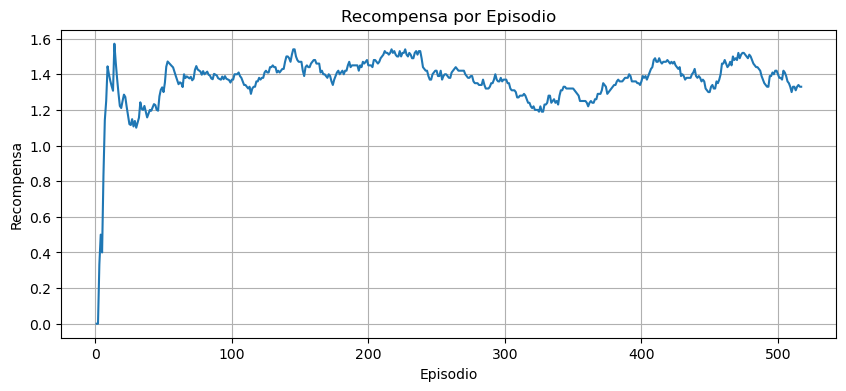

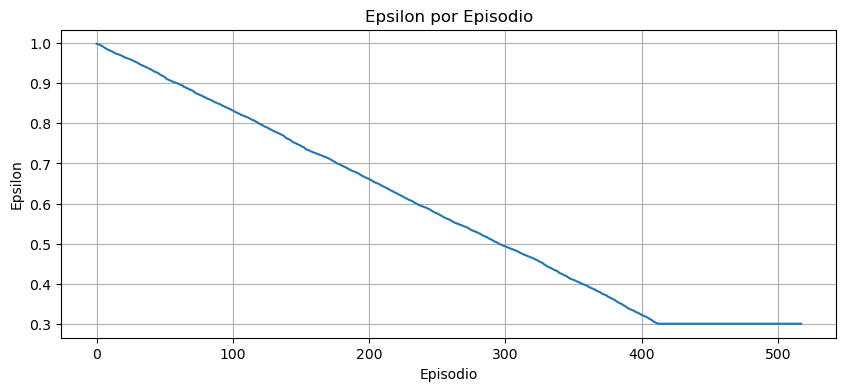

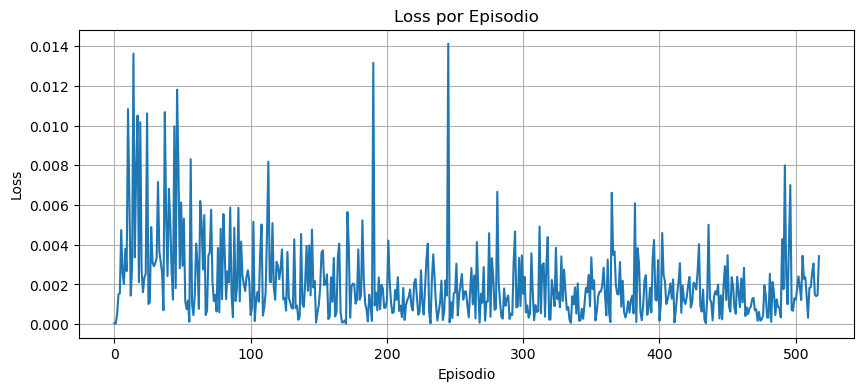

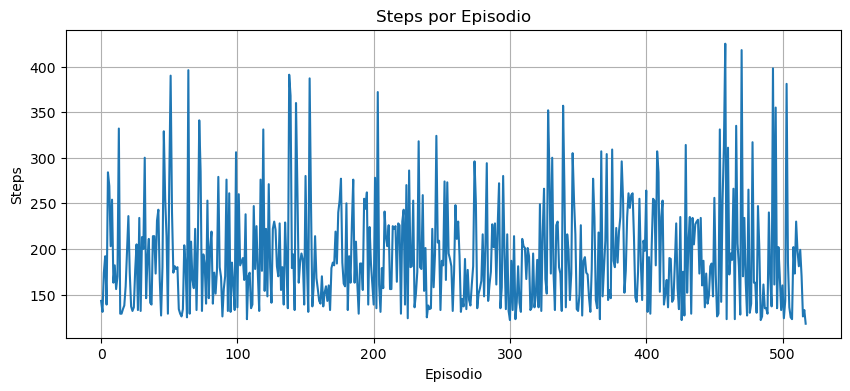

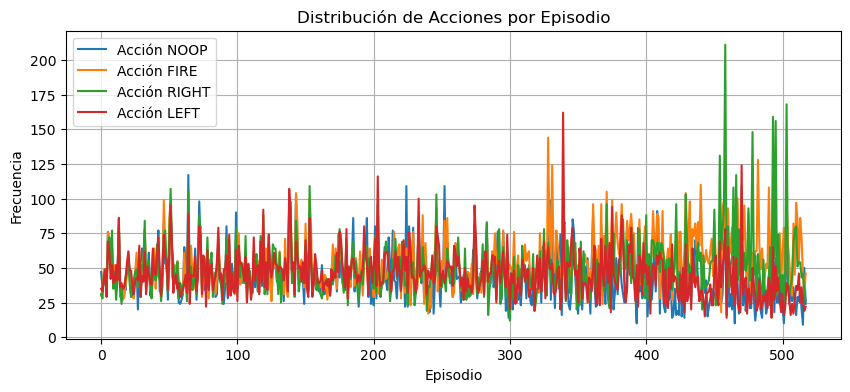

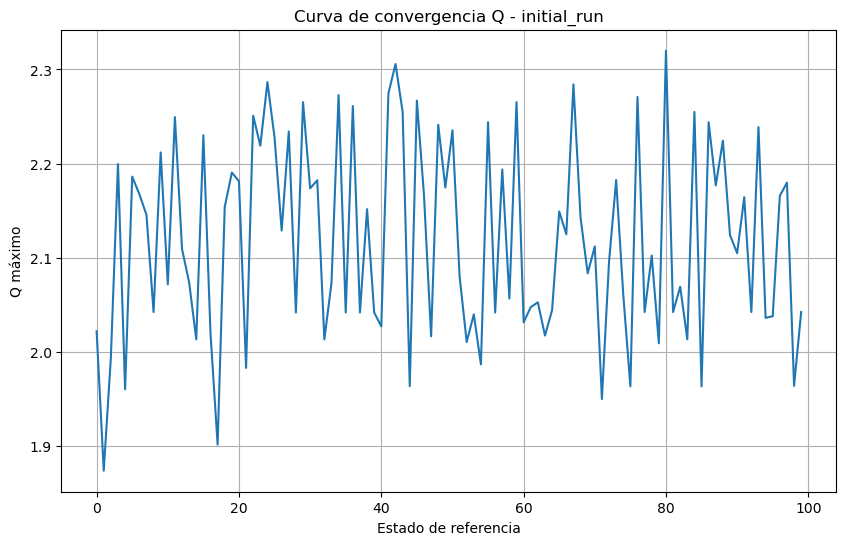

In [ ]:
METRICS_PATH = getMetricFilePath(True, PHASE_INITIAL_ID)
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_INITIAL_ID)

A lo largo de los **100.000 pasos realizados**, se observa que la recompensa promedio por episodio se mantiene en valores bajos, rondando entre **1.2 y 1.4 bloques destruidos**, sin una tendencia clara de mejora. Este comportamiento es completamente esperable, dado que en esta etapa el agente interactúa con el entorno de forma casi aleatoria, priorizando la diversidad de experiencias sobre la eficacia inmediata.

Este diseño se refleja en la evolución de *epsilon*, que parte de un valor máximo y desciende lentamente, asegurando que la exploración siga siendo predominante. La pérdida, por su parte, se mantiene en niveles muy bajos, con algunas oscilaciones iniciales propias de una red que apenas comienza a ajustar sus predicciones. Además, el número de pasos por episodio y la distribución de acciones confirman que no existe aún una preferencia clara por estrategias específicas, lo cual es coherente con el carácter puramente exploratorio de esta etapa. En conclusión, esta fase inicial logra sentar una base de experiencias amplia y diversa, clave para que el agente pueda aprender de forma más estable y eficaz en las fases siguientes.


### Evaluamos comportamiento del agente - Fase Inicial

In [ ]:
video_path = execute_agent_play(dqn_agent, PHASE_INITIAL_ID)
Video(video_path, embed=True, width=600)

Ejecutando agente initial_run en fase initial_run con tipo dqn
Ruta al archivo de vídeo en tu sistema de ficheros: ./videos/dqn/validation/initial_run
<TransformReward<FrameStackObservation<AtariPreprocessing<RecordVideo<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Breakout-v5>>>>>>>>


A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1216428046


Recompensa total del episodio 0: 0.0
Recompensa total promedio: 0.0


## FASE 2: Exploración

En esta etapa el agente ya tuvo un primer contacto con el entorno y comenzó a identificar algunas asociaciones básicas entre acciones y recompensas. A partir de esto, se extiende el entrenamiento a 2.000.000 de pasos, con el objetivo de reforzar la exploración y permitir que el agente acumule más experiencia antes de consolidar una política.

Dado que en la fase anterior las recompensas fueron bajas, se mantiene una exploración fuerte mediante el esquema de epsilon-decay:
- `ε_ini = 1.0:` exploración completamente aleatoria al inicio.
- `ε_min = 0.1:` se conserva cierto grado de exploración al final.
- `ε_anneal_steps = 1.500.000:` el descenso de epsilon es gradual durante casi toda la fase.

Este enfoque busca evitar que el agente se estanque prematuramente en políticas sub-óptimas. Como señalan Sutton y Barto (2018), una exploración sostenida es clave cuando el entorno es complejo o tiene recompensas poco frecuentes.

Para esta fase, se aplica también lo concluido en el análisis de gamma, utilizando un exploration gamma de 0.97, valor que en pruebas previas mostró un mejor equilibrio entre aprendizaje inmediato y planificación a mediano plazo.

Durante esta fase se espera una mejora progresiva en el rendimiento, evidenciada por mayores recompensas, episodios más largos y una menor pérdida en la estimación de valores Q.

In [ ]:
# gamma 0.97
EXPLORATION_GAMMA = 0.97
print(f"net a cargar con PHASE_ID: {PHASE_INITIAL_ID}")
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_INITIAL_ID)

PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: initial_run
PHASE_ID: phase_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 1, EPSILON_MIN: 0.1, EPSILON_ANNEAL_STEPS: 1500000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-initial_run.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(
  PHASE_ID,
  reference_states,
  loadPath=LOAD_NET_PATH,
  total_steps = TOTAL_STEPS,
  episodes = EPISODES,
  epsilon_i = EPSILON_INI,
  epsilon_f = EPSILON_MIN,
  epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
  gamma=EXPLORATION_GAMMA
)

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-initial_run.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.97
epsilon_i: 1
epsilon_f: 0.1
epsilon_anneal_steps: 1500000
episode_block: 100
run_name: phase_2


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_2, con los siguientes hiperparametros:

gamma: 0.97, epsilon_i: 1, epsilon_f: 0.1, epsilon_anneal_steps: 1500000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   8%|▊         | 786/10000 [11:34<2:46:40,  1.09s/episode, reward=1.32, epsilon=0.91, steps=150115]


=== Recompensa actual: 1.32, Epsilon: 0.909931, Total steps: 150115 ===


Entrenando:  16%|█▌        | 1572/10000 [23:17<2:10:17,  1.08episode/s, reward=1.56, epsilon=0.82, steps=3e+5]


=== Recompensa actual: 1.56, Epsilon: 0.8199796, Total steps: 300034 ===


Entrenando:  23%|██▎       | 2258/10000 [35:05<2:20:37,  1.09s/episode, reward=2.68, epsilon=0.73, steps=450046]


=== Recompensa actual: 2.68, Epsilon: 0.7299724, Total steps: 450046 ===


Entrenando:  29%|██▊       | 2853/10000 [46:46<2:13:18,  1.12s/episode, reward=3.37, epsilon=0.64, steps=6e+5]


=== Recompensa actual: 3.37, Epsilon: 0.6398524, Total steps: 600246 ===


Entrenando:  34%|███▎      | 3374/10000 [58:32<2:35:14,  1.41s/episode, reward=4.34, epsilon=0.55, steps=750146]


=== Recompensa actual: 4.34, Epsilon: 0.5499124, Total steps: 750146 ===


Entrenando:  38%|███▊      | 3834/10000 [1:10:24<2:19:19,  1.36s/episode, reward=5.61, epsilon=0.46, steps=9e+5]


=== Recompensa actual: 5.61, Epsilon: 0.45994899999999994, Total steps: 900085 ===


Entrenando:  42%|████▏     | 4223/10000 [1:22:08<3:14:07,  2.02s/episode, reward=7.15, epsilon=0.37, steps=1050367]


=== Recompensa actual: 7.15, Epsilon: 0.3697798, Total steps: 1050367 ===


Entrenando:  46%|████▌     | 4579/10000 [1:33:43<3:19:18,  2.21s/episode, reward=8.19, epsilon=0.28, steps=1.2e+6]


=== Recompensa actual: 8.19, Epsilon: 0.27978879999999995, Total steps: 1200352 ===


Entrenando:  49%|████▉     | 4894/10000 [1:45:27<4:01:03,  2.83s/episode, reward=9.81, epsilon=0.19, steps=1350252]


=== Recompensa actual: 9.81, Epsilon: 0.18984880000000004, Total steps: 1350252 ===


Entrenando:  52%|█████▏    | 5187/10000 [1:57:21<3:12:47,  2.40s/episode, reward=10.6, epsilon=0.1, steps=1.5e+6]


=== Recompensa actual: 10.56, Epsilon: 0.1, Total steps: 1500215 ===


Entrenando:  55%|█████▍    | 5455/10000 [2:09:38<3:14:07,  2.56s/episode, reward=10.8, epsilon=0.1, steps=1650252]


=== Recompensa actual: 10.78, Epsilon: 0.1, Total steps: 1650252 ===


Entrenando:  57%|█████▋    | 5719/10000 [2:22:02<3:32:54,  2.98s/episode, reward=11.9, epsilon=0.1, steps=1.8e+6]


=== Recompensa actual: 11.94, Epsilon: 0.1, Total steps: 1800424 ===


Entrenando:  60%|█████▉    | 5977/10000 [2:34:19<2:56:14,  2.63s/episode, reward=12.4, epsilon=0.1, steps=1950419]


=== Recompensa actual: 12.41, Epsilon: 0.1, Total steps: 1950419 ===


Entrenando:  61%|██████    | 6062/10000 [2:38:21<1:42:52,  1.57s/episode, reward=12.5, epsilon=0.1, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Resultados del entrenamiento - Fase 2

Datos cargados de metrics/dqn/metrics_phase_2.npz: [[ 97  98  81  88]
 [ 41  41  37  46]
 [ 52  51  62  51]
 ...
 [ 96 161 187 165]
 [ 28  75  39  71]
 [ 23  48  43  60]]


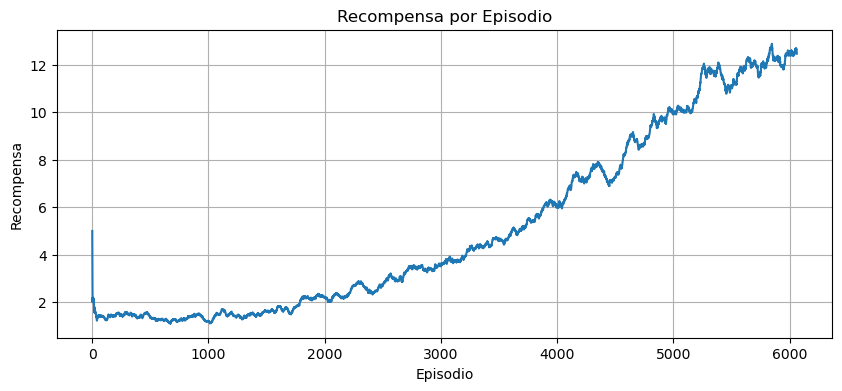

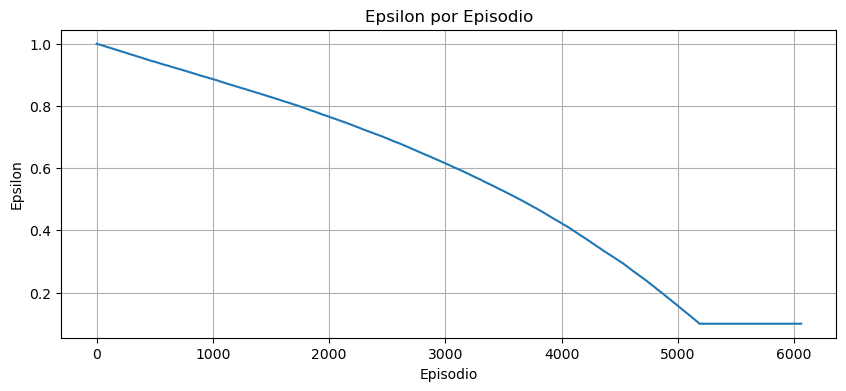

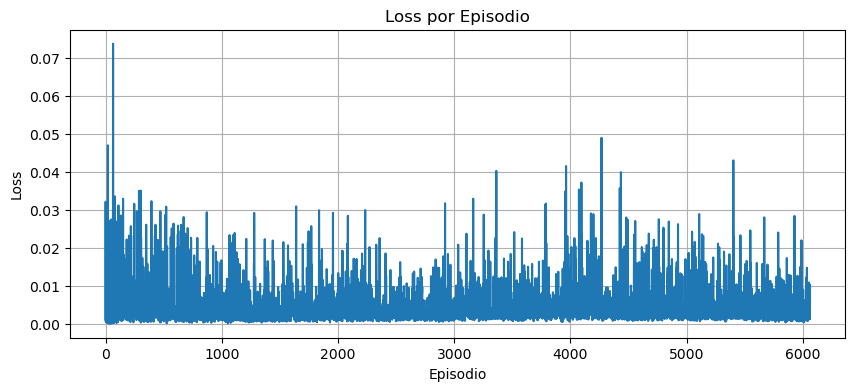

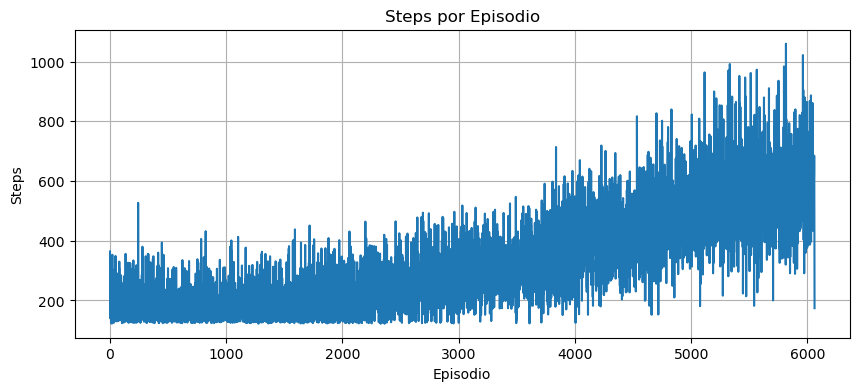

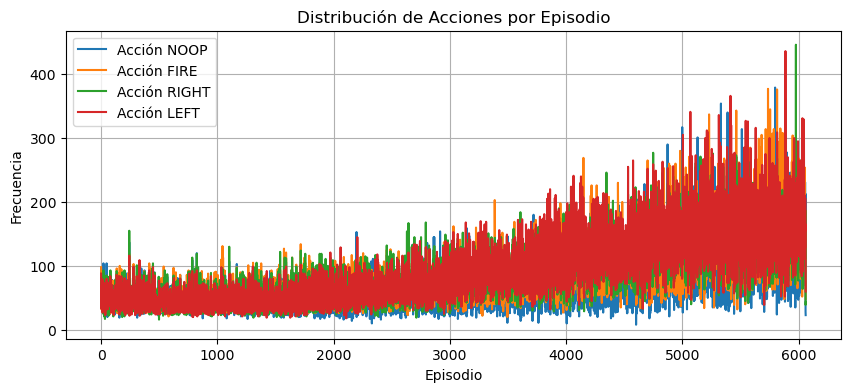

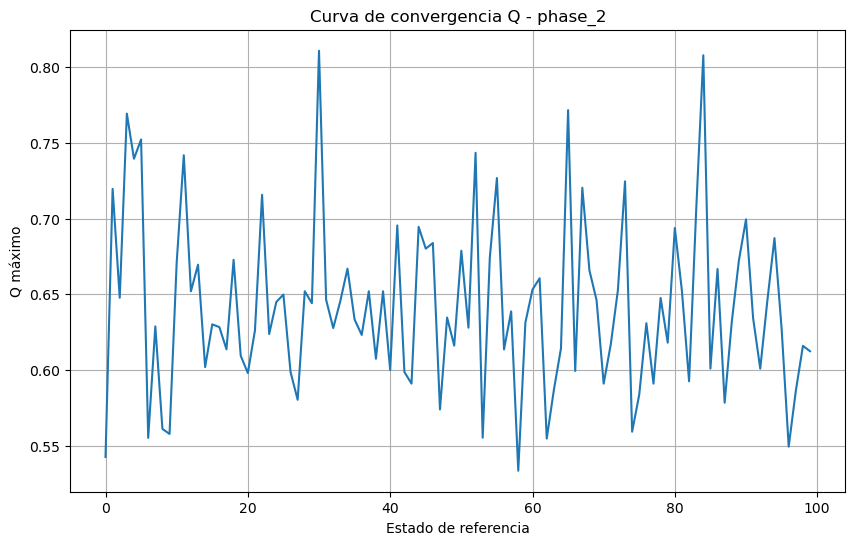

In [ ]:
METRICS_PATH = getMetricFilePath(True, PHASE_2_ID)
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_2_ID)

Completados los **6.000 episodios** resultantes, se observa un crecimiento sostenido y claro de la recompensa promedio, pasando de valores cercanos a **2 bloques rotos** a superar los **12**, lo que demuestra que el agente comienza a identificar y reforzar secuencias de acciones que le permiten mantener la pelota en juego durante más tiempo.

Esta evolución está estrechamente relacionada con la disminución progresiva del *epsilon*, que partiendo de **1.0** desciende de forma lenta y controlada hasta valores cercanos a **0.1**, lo que permite mantener la exploración activa a lo largo de toda la fase sin sacrificar del todo la explotación de comportamientos ya aprendidos.

Por su parte, la gráfica de pérdida muestra valores bajos con algunos picos dispersos, lo cual es natural en esta etapa, ya que la red neuronal ajusta continuamente los valores Q a partir de experiencias cada vez más variadas. Esto explica también la baja varianza general observada. El aumento progresivo de la cantidad de pasos por episodio refuerza esta interpretación, evidenciando que el agente es capaz de sostener las partidas durante más tiempo, resultado directo de una política más eficiente.

Finalmente, la curva de convergencia de los valores Q refleja un comportamiento más regular en comparación con la fase inicial, señal de que el aprendizaje comienza a estabilizarse y a aproximarse de forma más coherente a una política que pueda ser explotada en fases posteriores.


### Evaluamos comportamiento del Agente - Fase 2

In [ ]:
video_path = execute_agent_play(dqn_agent, PHASE_ID)
Video(video_path, embed=True, width=600)

Recompensa total del episodio 0: 12.0
Recompensa total promedio: 12.0


## FASE 3: Ajuste de la política - exploración vs explotación

Luego de una etapa de exploración intensiva, en esta tercera fase el objetivo es observar cómo se comporta el agente al **reducir significativamente la exploración** y comenzar a `explotar` con mayor frecuencia el conocimiento adquirido. Se mantienen **2.000.000 de pasos**, pero con un nuevo esquema de epsilon enfocado en la explotación:
- `ε_ini = 0.1:` el agente comienza con un nivel de exploración reducido.
- `ε_min = 0.01:` se permite una exploración mínima al final, para evitar sobre-ajuste.
- `ε_anneal_steps = 1.000.000:` el descenso es más corto que en fases anteriores, promoviendo una transición más rápida hacia políticas más deterministas.

Esta fase busca evaluar el comportamiento cuando se comienza a priorizar la explotación y corroborar la robustez de la política definida, lo cual permitirá refinar las fases siguientes, en caso de que se necesite mayor exploración.

In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_2_ID)
print(f"net a cargar con PHASE_ID: {PHASE_2_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_2
PHASE_ID: phase_3, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.1, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_2.dat


In [ ]:
# Creamos, cargamos pesos anteriores y entrenemos el agente
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_2.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.1
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
episode_block: 100
run_name: phase_3
Use prioritized memory: False


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_3, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.1, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   3%|▎         | 334/10000 [12:07<6:28:29,  2.41s/episode, reward=10.6, epsilon=0.0865, steps=150496]


=== Recompensa actual: 10.61, Epsilon: 0.08645536000000001, Total steps: 150496 ===


Entrenando:   6%|▌         | 606/10000 [24:13<7:16:34,  2.79s/episode, reward=12.3, epsilon=0.073, steps=3e+5]


=== Recompensa actual: 12.28, Epsilon: 0.07297435, Total steps: 300285 ===


Entrenando:   9%|▊         | 851/10000 [36:11<9:03:28,  3.56s/episode, reward=14.2, epsilon=0.0594, steps=450584]


=== Recompensa actual: 14.2, Epsilon: 0.059447440000000004, Total steps: 450584 ===


Entrenando:  11%|█         | 1091/10000 [48:09<7:31:15,  3.04s/episode, reward=13.8, epsilon=0.046, steps=6e+5]


=== Recompensa actual: 13.77, Epsilon: 0.045996220000000004, Total steps: 600042 ===


Entrenando:  13%|█▎        | 1315/10000 [1:00:10<8:55:03,  3.70s/episode, reward=15.3, epsilon=0.0324, steps=750784]


=== Recompensa actual: 15.26, Epsilon: 0.032429440000000004, Total steps: 750784 ===


Entrenando:  15%|█▌        | 1537/10000 [1:12:00<8:25:16,  3.58s/episode, reward=15.8, epsilon=0.0189, steps=900657]


=== Recompensa actual: 15.82, Epsilon: 0.01894087, Total steps: 900657 ===


Entrenando:  18%|█▊        | 1754/10000 [1:23:50<7:16:45,  3.18s/episode, reward=15.7, epsilon=0.01, steps=1050423]


=== Recompensa actual: 15.7, Epsilon: 0.01, Total steps: 1050423 ===


Entrenando:  20%|█▉        | 1968/10000 [1:35:35<6:44:51,  3.02s/episode, reward=16.3, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 16.31, Epsilon: 0.01, Total steps: 1200082 ===


Entrenando:  22%|██▏       | 2166/10000 [1:47:35<7:46:43,  3.57s/episode, reward=18.9, epsilon=0.01, steps=1350271]


=== Recompensa actual: 18.86, Epsilon: 0.01, Total steps: 1350271 ===


Entrenando:  24%|██▎       | 2362/10000 [1:59:21<9:57:50,  4.70s/episode, reward=18.4, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 18.36, Epsilon: 0.01, Total steps: 1500015 ===


Entrenando:  26%|██▌       | 2567/10000 [2:11:15<6:16:26,  3.04s/episode, reward=17.1, epsilon=0.01, steps=1650285]


=== Recompensa actual: 17.05, Epsilon: 0.01, Total steps: 1650285 ===


Entrenando:  28%|██▊       | 2770/10000 [2:23:02<6:21:38,  3.17s/episode, reward=17.2, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 17.24, Epsilon: 0.01, Total steps: 1800129 ===


Entrenando:  30%|██▉       | 2975/10000 [2:35:00<6:28:57,  3.32s/episode, reward=17.5, epsilon=0.01, steps=1950351]


=== Recompensa actual: 17.48, Epsilon: 0.01, Total steps: 1950351 ===


Entrenando:  30%|███       | 3039/10000 [2:39:05<6:04:23,  3.14s/episode, reward=18.1, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Resultados del entrenamiento - Fase 3

Datos cargados de metrics/dqn/metrics_phase_3.npz: [[107  74  47 179]
 [ 41  13  85 251]
 [ 50  64  84  96]
 ...
 [322 150  92 124]
 [330 230 121 150]
 [370 205 121 166]]


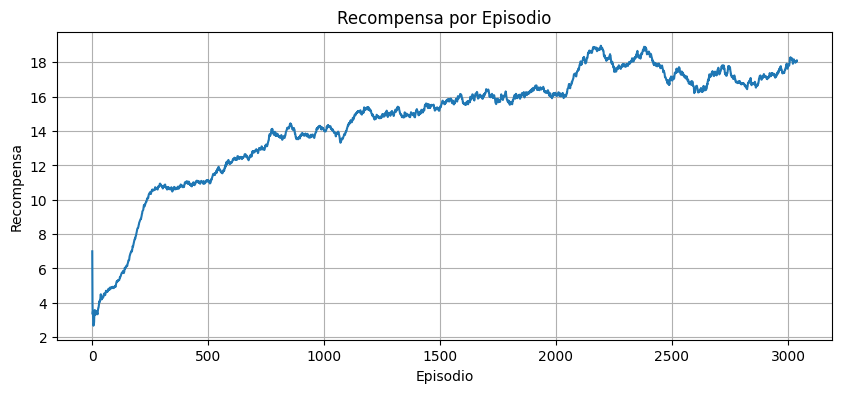

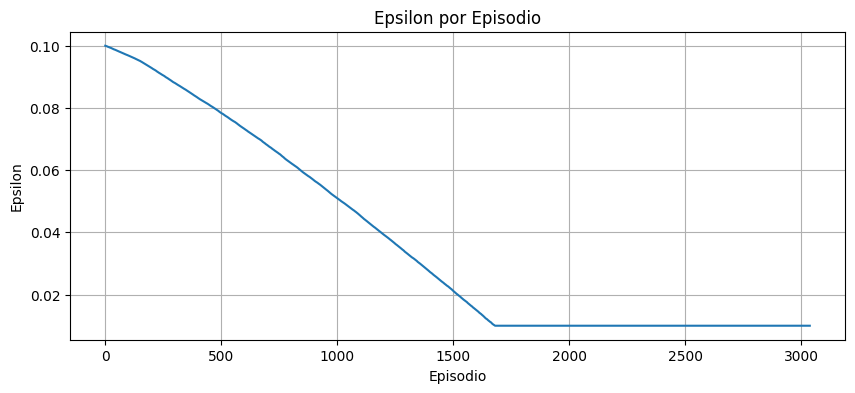

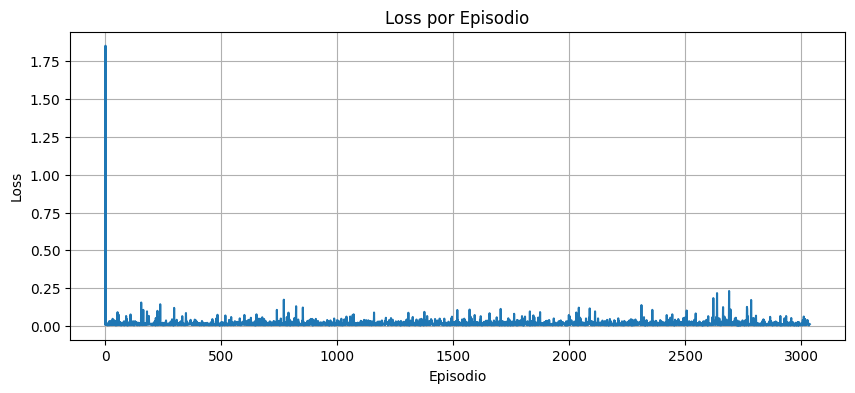

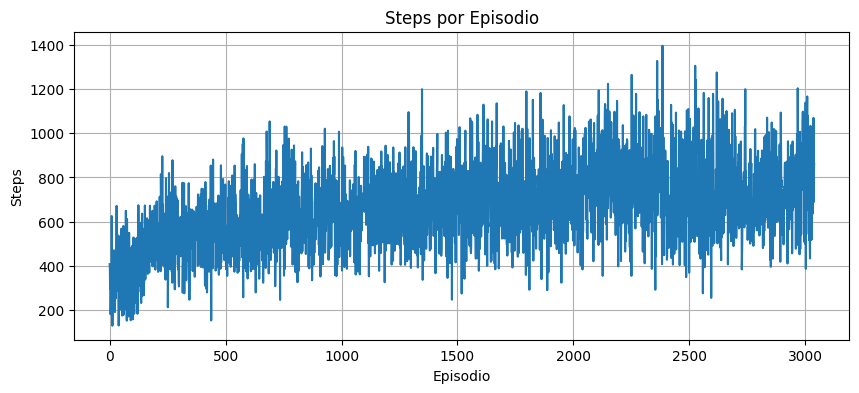

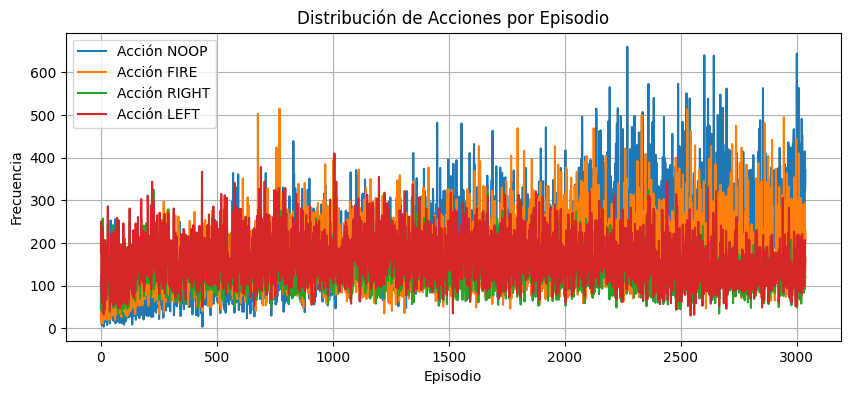

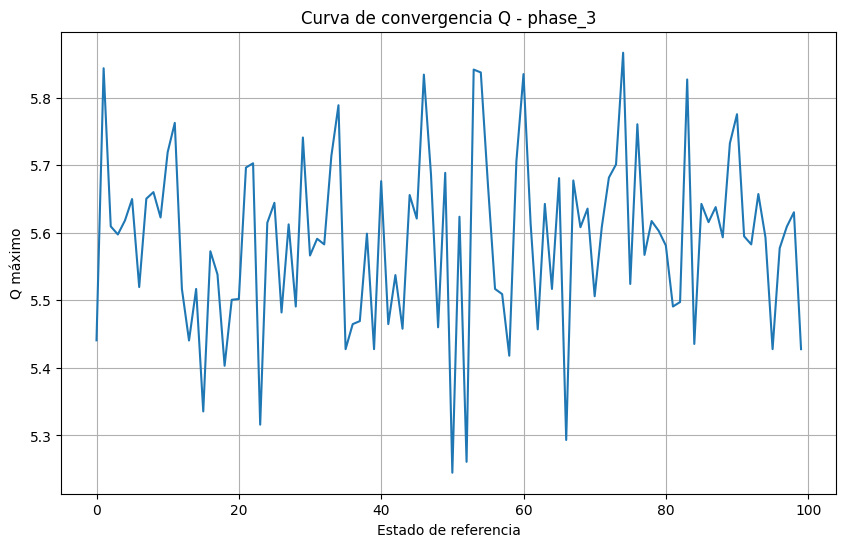

In [ ]:
METRICS_PATH = getMetricFilePath(True, PHASE_3_ID)
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_3_ID)

En la **fase 2**, el agente establece una política. Sin embargo, una vez desarrollada, los pasos de explotación son limitados. A partir de un porcentaje de exploración menor, se observa que el agente avanza considerablemente en los primeros 2000 episodios. A partir de este punto, las recompensas oscilan entre **16 y 18**, lo que indica un estancamiento. Esta zona de estancamiento coincide con el mayor porcentaje de explotación del entrenamiento, ya que, aproximadamente desde el **episodio 1700**, el valor de **épsilon** alcanzó su mínimo de **0.01**.

En la **fase 2**, el agente establece una política. Sin embargo, una vez desarrollada, los pasos de explotación son limitados. A partir de un porcentaje de exploración menor, se observa que el agente avanza considerablemente en los primeros 2000 episodios. A partir de este punto, las recompensas oscilan entre **16 y 18**, lo que indica un estancamiento. Esta zona de estancamiento coincide con el mayor porcentaje de explotación del entrenamiento, ya que, aproximadamente desde el **episodio 1700**, el valor de **épsilon** alcanzó su mínimo de **0.01**.

A partir de esa observación, entendemos dos posibles escenarios:

1.  **Exploración Insuficiente:** Es posible que no se haya explorado lo suficiente la política establecida, lo que sugiere la necesidad de más pasos de exploración en esta etapa.
2.  **Sobreajuste a una Política Subóptima:** El agente podría estar sobreajustando a una política ya establecida, pero que es subóptima. Esta política tiene un rendimiento aceptable, pero no es la óptima, lo que podría haberlo "atrapado" en un máximo local. Esto explicaría por qué en la sección de mayor explotación, el valor de las recompensas comienza a oscilar.

Para descartar la primera hipótesis, optamos por añadir la Fase 3_2 con mas pasos de exploración.


### Evaluamos comportamiento del Agente - Fase 3

In [ ]:
video_path = execute_agent_play(dqn_agent, PHASE_3_ID)
Video(video_path, embed=True, width=600)

Recompensa total del episodio 0: 21.0
Recompensa total promedio: 21.0


### FASE 3_2: Exploración complementaria

Como mencionamos en la conclusión de la fase 3, para intentar solucionar el problema de estancamiento se incluyó una nueva fase con mayor nivel de exploración.

En esta etapa, se mantuvieron los **2.000.000 de pasos**, pero se ajustaron los valores de epsilon para aumentar la aleatoriedad al comienzo:

- `ε_ini = 0.5:` se vuelve a explorar con más intensidad al inicio.
- `ε_min = 0.01:` se reduce la exploración gradualmente, pero no se elimina por completo.
- `ε_anneal_steps = 1.000.000:` se mantiene un descenso progresivo y balanceado.


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_3_ID)
print(f"net a cargar con PHASE_ID: {PHASE_3_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_3
PHASE_ID: phase_3_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.5, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_3.dat


In [ ]:
# Creamos, cargamos pesos anteriores y entrenemos el agente
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_3.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.5
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
episode_block: 100
run_name: phase_3_2
Use prioritized memory: False


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_3_2, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.5, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   4%|▍         | 391/10000 [11:02<5:52:38,  2.20s/episode, reward=7.87, epsilon=0.426, steps=150016]


=== Recompensa actual: 7.87, Epsilon: 0.42649216, Total steps: 150016 ===


Entrenando:   7%|▋         | 728/10000 [22:10<6:25:14,  2.49s/episode, reward=8.74, epsilon=0.353, steps=3e+5]


=== Recompensa actual: 8.74, Epsilon: 0.35278244000000003, Total steps: 300444 ===


Entrenando:  10%|█         | 1040/10000 [33:18<5:00:28,  2.01s/episode, reward=9.35, epsilon=0.279, steps=450117]


=== Recompensa actual: 9.35, Epsilon: 0.27944267, Total steps: 450117 ===


Entrenando:  13%|█▎        | 1318/10000 [44:32<6:08:24,  2.55s/episode, reward=11.5, epsilon=0.206, steps=6e+5]


=== Recompensa actual: 11.47, Epsilon: 0.20582310999999998, Total steps: 600361 ===


Entrenando:  16%|█▌        | 1572/10000 [55:53<6:40:13,  2.85s/episode, reward=13.1, epsilon=0.132, steps=750383]


=== Recompensa actual: 13.13, Epsilon: 0.13231232999999998, Total steps: 750383 ===


Entrenando:  18%|█▊        | 1815/10000 [1:07:17<6:26:54,  2.84s/episode, reward=14.4, epsilon=0.0587, steps=900568]


=== Recompensa actual: 14.44, Epsilon: 0.05872168, Total steps: 900568 ===


Entrenando:  20%|██        | 2036/10000 [1:18:38<8:33:31,  3.87s/episode, reward=14.9, epsilon=0.01, steps=1050418]


=== Recompensa actual: 14.95, Epsilon: 0.01, Total steps: 1050418 ===


Entrenando:  22%|██▏       | 2243/10000 [1:30:05<6:57:38,  3.23s/episode, reward=16.2, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 16.22, Epsilon: 0.01, Total steps: 1200120 ===


Entrenando:  25%|██▍       | 2451/10000 [1:41:29<6:34:46,  3.14s/episode, reward=17.6, epsilon=0.01, steps=1350011]


=== Recompensa actual: 17.56, Epsilon: 0.01, Total steps: 1350011 ===


Entrenando:  27%|██▋       | 2655/10000 [1:52:59<7:22:00,  3.61s/episode, reward=18.9, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 18.94, Epsilon: 0.01, Total steps: 1500605 ===


Entrenando:  29%|██▊       | 2855/10000 [2:04:18<6:37:26,  3.34s/episode, reward=17.8, epsilon=0.01, steps=1650604]


=== Recompensa actual: 17.81, Epsilon: 0.01, Total steps: 1650604 ===


Entrenando:  31%|███       | 3056/10000 [2:15:43<6:40:17,  3.46s/episode, reward=17.3, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 17.28, Epsilon: 0.01, Total steps: 1800005 ===


Entrenando:  33%|███▎      | 3258/10000 [2:27:04<5:49:52,  3.11s/episode, reward=17.3, epsilon=0.01, steps=1950042]


=== Recompensa actual: 17.29, Epsilon: 0.01, Total steps: 1950042 ===


Entrenando:  33%|███▎      | 3324/10000 [2:30:51<5:03:00,  2.72s/episode, reward=17.8, epsilon=0.01, steps=2e+6]
/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)



Entrenamiento detenido: se alcanzaron 2000001 pasos.


#### Resultados del entrenamiento - Fase 3_2

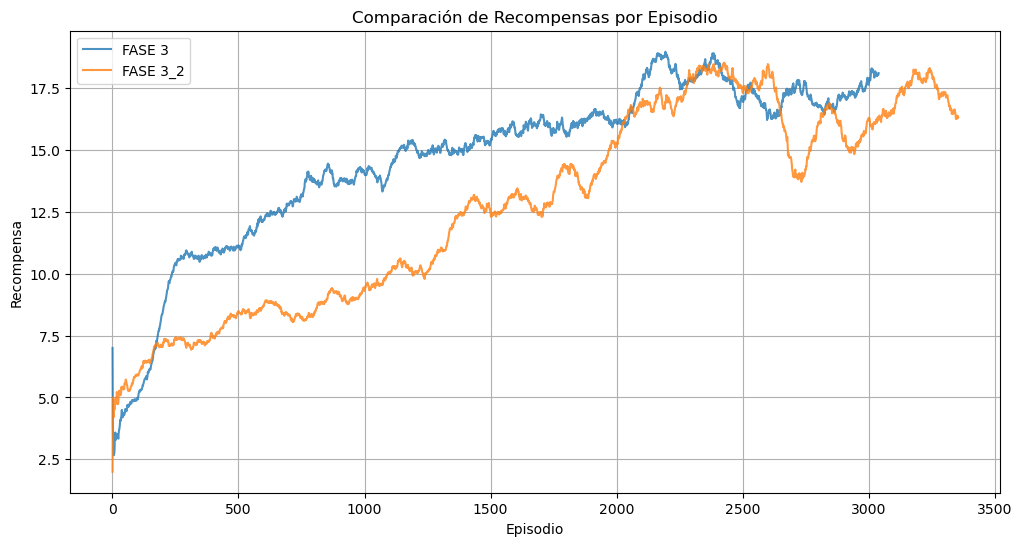

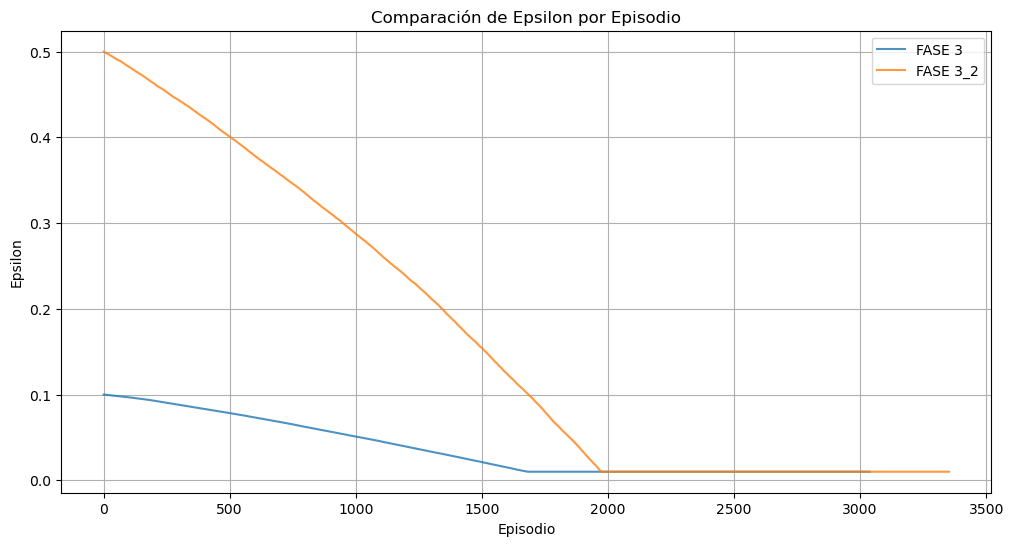

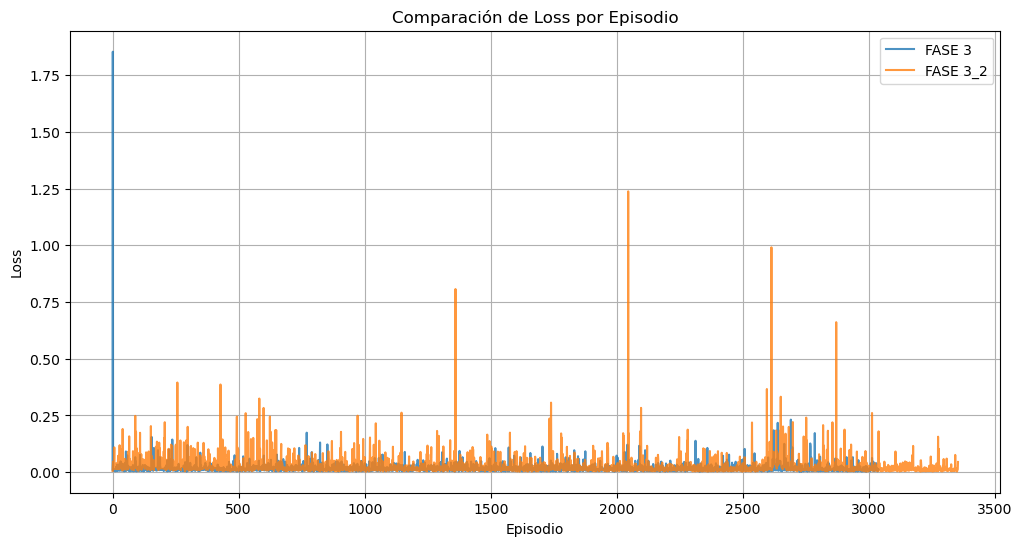


=== RESUMEN ESTADÍSTICO ===

FASE 3:
  Recompensa promedio: 14.59 ± 3.35
  Recompensa máxima: 18.97
  Recompensa mínima: 2.67
  Loss promedio: 0.0171 ± 0.0373
  Steps promedio: 658.1 ± 185.3
  Epsilon final: 0.0100
  Episodios totales: 3039
  Episodios con recompensas válidas: 3038
  Porcentaje de datos válidos: 100.0%

FASE 3_2:
  Recompensa promedio: 12.75 ± 3.98
  Recompensa máxima: 18.53
  Recompensa mínima: 2.00
  Loss promedio: 0.0275 ± 0.0469
  Steps promedio: 596.3 ± 199.9
  Epsilon final: 0.0100
  Episodios totales: 3354
  Episodios con recompensas válidas: 3353
  Porcentaje de datos válidos: 100.0%


In [ ]:
metrics_paths = [getMetricFilePath(True, PHASE_3_ID), getMetricFilePath(True, f"{PHASE_3_2_ID}")]
compare_metrics(metrics_paths, labels=["FASE 3", "FASE 3_2"], show_rewards=True, show_losses=True, show_steps=False, show_actions=False, show_epsilons=True)

A partir de la gráfica se observa que, aunque se aumentó la exploración y por ende se generó más diversidad de trayectorias, no fue suficiente para superar la recompensa máxima alcanzada en la **Fase 3**. Las recompensas promedio se mantuvieron por debajo y la política continuó atrapada en soluciones subóptimas. Además, los picos frecuentes en la **pérdida** reflejan la dificultad para ajustar correctamente los valores Q debido al **sesgo de maximización**, que lleva a sobreestimar transiciones poco útiles. Esto confirma que más exploración por sí sola no garantiza mejoras si persiste la sobreestimación, y destaca la ventaja de usar **Double Q-Learning** para reducir este sesgo y favorecer una convergencia más estable.

## FASE 4: Consolidación de la política aprendida

Esta última etapa del entrenamiento se planteó con el objetivo de consolidar la política que el agente fue aprendiendo en las fases anteriores. En esta parte ya no se busca seguir explorando el entorno, sino que el agente actúe principalmente explotando lo que aprendió, con muy poca aleatoriedad.

La fase se dividió en tres bloques de **2.000.000 de pasos** cada uno. Esta división respondió a una cuestión práctica: entrenamientos tan largos pueden verse afectados por problemas de cómputo, uso de memoria o interrupciones. Al separar la fase en partes, fue posible guardar checkpoints intermedios, lo que ayuda a evitar la pérdida de datos y facilita el monitoreo del progreso.

En cuanto a la estrategia de exploración, se optó por valores bajos de epsilon:
- `En la fase 4.1`, el agente parte de `ε = 0.05` y baja gradualmente hasta `ε = 0.01`.
- `En las fases 4.2 y 4.3`, ε se mantiene fijo en `0.01`.

Este esquema está alineado con lo planteado en Sutton y Barto (2018), donde se señala que una política casi determinista es adecuada en etapas avanzadas del entrenamiento, cuando el agente ya tiene una representación sólida del entorno y puede enfocarse en explotar lo aprendido. Mantener un mínimo de aleatoriedad (ε > 0) también permite evitar sobreajuste a trayectorias específicas, especialmente en entornos parcialmente observables o con pequeñas variaciones.

En total, esta etapa suma **6.000.000 de pasos**, durante los cuales el agente actúa casi de forma determinista. Esta fase permite evaluar si la política final es estable, consistente y capaz de mantener un buen rendimiento sin depender ya de la exploración.


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_3_2_ID)
print(f"net a cargar con PHASE_ID: {PHASE_3_2_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_1)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_3_2
PHASE_ID: phase_4_1, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.05, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_3_2.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

net a cargar con PHASE_ID: initial_run
PHASE_ID: phase_4_1, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.05, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_3.dat
Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_3.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.05
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
episode_block: 100
run_name: phase_4_1


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn/phase_4_1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_4_1, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.05, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   2%|▏         | 221/10000 [11:35<8:41:39,  3.20s/episode, reward=16.4, epsilon=0.044, steps=150152]


=== Recompensa actual: 16.38, Epsilon: 0.043993920000000006, Total steps: 150152 ===


Entrenando:   4%|▍         | 427/10000 [23:33<10:16:28,  3.86s/episode, reward=17.4, epsilon=0.038, steps=3e+5]


=== Recompensa actual: 17.37, Epsilon: 0.03799604, Total steps: 300099 ===


Entrenando:   6%|▋         | 628/10000 [35:26<7:41:45,  2.96s/episode, reward=18.5, epsilon=0.032, steps=450329]


=== Recompensa actual: 18.48, Epsilon: 0.03198684, Total steps: 450329 ===


Entrenando:   8%|▊         | 830/10000 [46:57<8:50:08,  3.47s/episode, reward=17.9, epsilon=0.026, steps=6e+5]


=== Recompensa actual: 17.95, Epsilon: 0.025983320000000004, Total steps: 600417 ===


Entrenando:  10%|█         | 1022/10000 [58:34<8:49:44,  3.54s/episode, reward=18.4, epsilon=0.02, steps=750282]


=== Recompensa actual: 18.38, Epsilon: 0.01998872, Total steps: 750282 ===


Entrenando:  12%|█▏        | 1224/10000 [1:10:05<8:42:40,  3.57s/episode, reward=17.8, epsilon=0.014, steps=9e+5] 


=== Recompensa actual: 17.83, Epsilon: 0.013980720000000002, Total steps: 900482 ===


Entrenando:  14%|█▍        | 1418/10000 [1:21:36<8:14:32,  3.46s/episode, reward=18.7, epsilon=0.01, steps=1050488]


=== Recompensa actual: 18.67, Epsilon: 0.01, Total steps: 1050488 ===


Entrenando:  16%|█▌        | 1603/10000 [1:33:18<10:31:10,  4.51s/episode, reward=19.4, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 19.41, Epsilon: 0.01, Total steps: 1200835 ===


Entrenando:  18%|█▊        | 1789/10000 [1:44:49<8:24:34,  3.69s/episode, reward=19.4, epsilon=0.01, steps=1350627]


=== Recompensa actual: 19.41, Epsilon: 0.01, Total steps: 1350627 ===


Entrenando:  20%|█▉        | 1981/10000 [1:56:12<8:25:49,  3.78s/episode, reward=18.6, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 18.56, Epsilon: 0.01, Total steps: 1500120 ===


Entrenando:  22%|██▏       | 2164/10000 [2:07:55<7:20:53,  3.38s/episode, reward=20.1, epsilon=0.01, steps=1650496]


=== Recompensa actual: 20.09, Epsilon: 0.01, Total steps: 1650496 ===


Entrenando:  23%|██▎       | 2341/10000 [2:19:30<7:16:04,  3.42s/episode, reward=19.7, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 19.71, Epsilon: 0.01, Total steps: 1800675 ===


Entrenando:  25%|██▌       | 2523/10000 [2:31:12<7:09:39,  3.45s/episode, reward=19.4, epsilon=0.01, steps=1950009]


=== Recompensa actual: 19.44, Epsilon: 0.01, Total steps: 1950009 ===


Entrenando:  26%|██▌       | 2584/10000 [2:35:07<7:25:11,  3.60s/episode, reward=19.4, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_4_1_ID)
print(f"net a cargar con PHASE_ID: {PHASE_4_1_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_4_2
PHASE_ID: phase_4_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.01, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 2000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_4_1.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

net a cargar con PHASE_ID: phase_4_1
PHASE_ID: phase_4_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.01, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 2000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_4_1.dat
Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_4_1.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.01
epsilon_f: 0.01
epsilon_anneal_steps: 2000000
episode_block: 100
run_name: phase_4_2


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_4_2, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.01, epsilon_f: 0.01, epsilon_anneal_steps: 2000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   2%|▏         | 205/10000 [13:28<13:13:17,  4.86s/episode, reward=17.8, epsilon=0.01, steps=150470]


=== Recompensa actual: 17.75, Epsilon: 0.01, Total steps: 150470 ===


Entrenando:   4%|▍         | 392/10000 [27:00<11:40:45,  4.38s/episode, reward=20, epsilon=0.01, steps=3e+5]


=== Recompensa actual: 19.99, Epsilon: 0.01, Total steps: 300328 ===


Entrenando:   6%|▌         | 585/10000 [40:27<10:54:37,  4.17s/episode, reward=18.6, epsilon=0.01, steps=450693]


=== Recompensa actual: 18.59, Epsilon: 0.01, Total steps: 450693 ===


Entrenando:   8%|▊         | 768/10000 [53:47<12:32:17,  4.89s/episode, reward=19.5, epsilon=0.01, steps=6e+5]


=== Recompensa actual: 19.49, Epsilon: 0.01, Total steps: 600252 ===


Entrenando:   9%|▉         | 948/10000 [1:07:35<10:13:50,  4.07s/episode, reward=19.8, epsilon=0.01, steps=750545]


=== Recompensa actual: 19.78, Epsilon: 0.01, Total steps: 750545 ===


Entrenando:  11%|█▏        | 1133/10000 [1:21:10<10:04:38,  4.09s/episode, reward=20.1, epsilon=0.01, steps=9e+5]


=== Recompensa actual: 20.08, Epsilon: 0.01, Total steps: 900450 ===


Entrenando:  13%|█▎        | 1313/10000 [1:34:48<8:45:38,  3.63s/episode, reward=19.8, epsilon=0.01, steps=1050563]


=== Recompensa actual: 19.84, Epsilon: 0.01, Total steps: 1050563 ===


Entrenando:  15%|█▌        | 1501/10000 [1:48:12<10:04:56,  4.27s/episode, reward=19.1, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 19.1, Epsilon: 0.01, Total steps: 1200817 ===


Entrenando:  17%|█▋        | 1695/10000 [2:01:38<9:19:26,  4.04s/episode, reward=18.3, epsilon=0.01, steps=1350257] 


=== Recompensa actual: 18.32, Epsilon: 0.01, Total steps: 1350257 ===


Entrenando:  19%|█▉        | 1883/10000 [2:14:59<10:03:44,  4.46s/episode, reward=19.4, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 19.35, Epsilon: 0.01, Total steps: 1500696 ===


Entrenando:  21%|██        | 2065/10000 [2:28:19<12:28:33,  5.66s/episode, reward=20, epsilon=0.01, steps=1651049]


=== Recompensa actual: 19.96, Epsilon: 0.01, Total steps: 1651049 ===


Entrenando:  22%|██▎       | 2250/10000 [2:41:39<11:03:07,  5.13s/episode, reward=19.8, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 19.78, Epsilon: 0.01, Total steps: 1800280 ===


Entrenando:  24%|██▍       | 2433/10000 [2:55:05<9:11:16,  4.37s/episode, reward=19.2, epsilon=0.01, steps=1950531]


=== Recompensa actual: 19.17, Epsilon: 0.01, Total steps: 1950531 ===


Entrenando:  25%|██▍       | 2490/10000 [2:59:32<9:01:31,  4.33s/episode, reward=20.1, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_4_2_ID)
print(f"net a cargar con PHASE_ID: {PHASE_4_2_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_4_2
PHASE_ID: phase_4_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.01, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 2000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_4_2.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn/phase_4_2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_4_2.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.01
epsilon_f: 0.01
epsilon_anneal_steps: 2000000
episode_block: 100
run_name: phase_4_2


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_4_2, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.01, epsilon_f: 0.01, epsilon_anneal_steps: 2000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   2%|▏         | 193/10000 [13:06<11:35:10,  4.25s/episode, reward=18.9, epsilon=0.01, steps=150763]


=== Recompensa actual: 18.94, Epsilon: 0.01, Total steps: 150763 ===


Entrenando:   4%|▍         | 380/10000 [25:55<11:32:12,  4.32s/episode, reward=19.7, epsilon=0.01, steps=3e+5]


=== Recompensa actual: 19.69, Epsilon: 0.01, Total steps: 300107 ===


Entrenando:   6%|▌         | 560/10000 [39:07<12:10:45,  4.64s/episode, reward=20.7, epsilon=0.01, steps=450235]


=== Recompensa actual: 20.7, Epsilon: 0.01, Total steps: 450235 ===


Entrenando:   7%|▋         | 736/10000 [52:06<11:36:32,  4.51s/episode, reward=20.5, epsilon=0.01, steps=600728]


=== Recompensa actual: 20.5, Epsilon: 0.01, Total steps: 600728 ===


Entrenando:   9%|▉         | 917/10000 [1:04:57<11:36:10,  4.60s/episode, reward=20.1, epsilon=0.01, steps=750070]


=== Recompensa actual: 20.13, Epsilon: 0.01, Total steps: 750070 ===


Entrenando:  11%|█         | 1100/10000 [1:17:57<10:22:18,  4.20s/episode, reward=20.2, epsilon=0.01, steps=9e+5]


=== Recompensa actual: 20.2, Epsilon: 0.01, Total steps: 900048 ===


Entrenando:  13%|█▎        | 1282/10000 [1:31:23<9:56:00,  4.10s/episode, reward=20.1, epsilon=0.01, steps=1050076] 


=== Recompensa actual: 20.11, Epsilon: 0.01, Total steps: 1050076 ===


Entrenando:  15%|█▍        | 1470/10000 [1:44:31<9:33:24,  4.03s/episode, reward=20, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 19.97, Epsilon: 0.01, Total steps: 1200619 ===


Entrenando:  17%|█▋        | 1652/10000 [1:57:29<8:59:32,  3.88s/episode, reward=19.5, epsilon=0.01, steps=1350197]


=== Recompensa actual: 19.51, Epsilon: 0.01, Total steps: 1350197 ===


Entrenando:  18%|█▊        | 1820/10000 [2:10:24<10:50:26,  4.77s/episode, reward=22.6, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 22.62, Epsilon: 0.01, Total steps: 1500010 ===


Entrenando:  20%|█▉        | 1993/10000 [2:23:27<9:56:59,  4.47s/episode, reward=21.4, epsilon=0.01, steps=1650433]


=== Recompensa actual: 21.45, Epsilon: 0.01, Total steps: 1650433 ===


Entrenando:  22%|██▏       | 2159/10000 [2:36:17<8:20:34,  3.83s/episode, reward=21.8, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 21.77, Epsilon: 0.01, Total steps: 1800035 ===


Entrenando:  23%|██▎       | 2333/10000 [2:49:11<8:32:26,  4.01s/episode, reward=21, epsilon=0.01, steps=1950626]


=== Recompensa actual: 21.0, Epsilon: 0.01, Total steps: 1950626 ===


Entrenando:  24%|██▍       | 2395/10000 [2:53:21<9:10:29,  4.34s/episode, reward=19.5, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.


#### Resultados del entrenamiento - Fase 4

['phase_4_1', 'phase_4_2', 'phase_4_3']
['metrics/dqn/metrics_phase_4_1.npz', 'metrics/dqn/metrics_phase_4_2.npz', 'metrics/dqn/metrics_phase_4_3.npz']


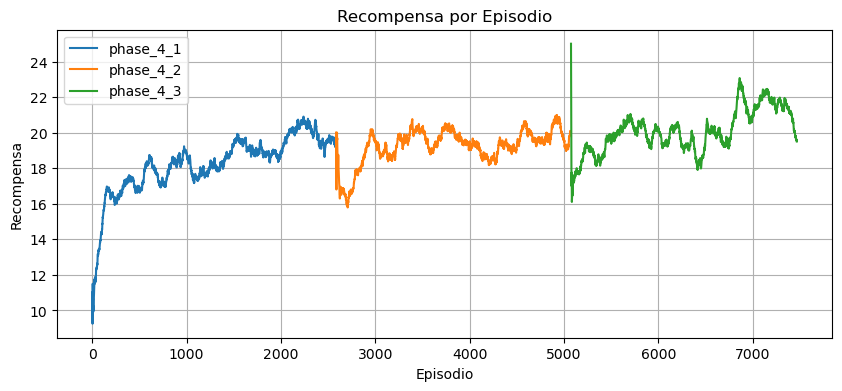

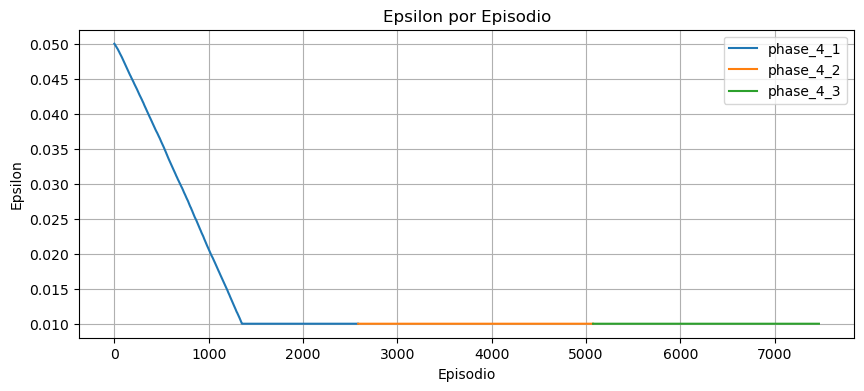

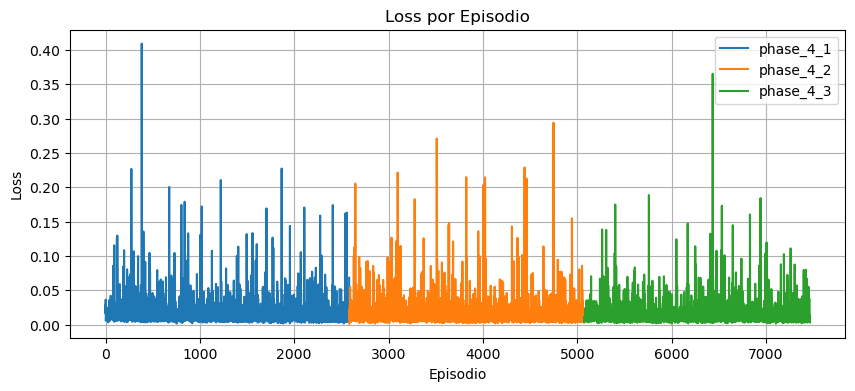

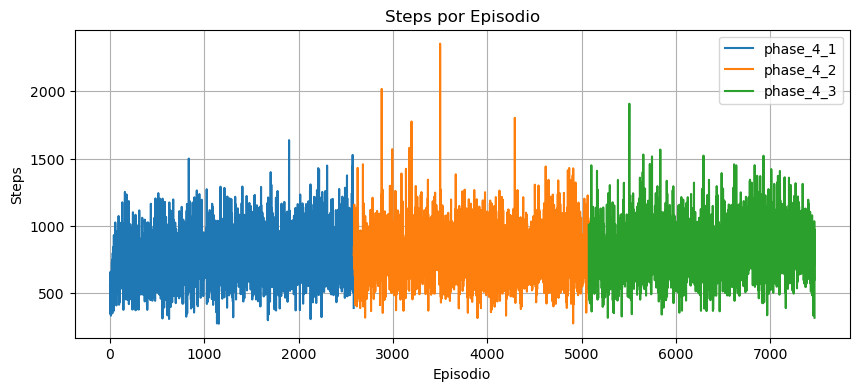

In [ ]:
phase_ids = [PHASE_4_1_ID, PHASE_4_2_ID, PHASE_4_3_ID]
metrics_path = getMetricFilePathList(True, phase_ids)
print(metrics_path)
graph_metrics_accumulated(metrics_path, phase_ids)

Al observar los resultados, concluimos que la **Fase 4** confirma que una política de explotación prolongada, con exploración mínima, es clave para pulir el desempeño aprendido y maximizar la recompensa alcanzable. Los resultados de *play* demuestran que el agente es capaz de ejecutar episodios de alta calidad, alcanzando niveles de desempeño cercanos a **40 bloques destruidos**, lo que valida la utilidad de la estrategia de entrenamiento en fases y deja claro que el refinamiento final es indispensable para convertir una política prometedora en una política verdaderamente robusta y eficiente en la práctica.

## Análisis final del proceso de entrenamiento

Planteamos en una gráfica el comportamiento del agente a lo largo de todas las fases de entrenamiento

['initial_run', 'phase_2', 'phase_3', 'phase_3_2', 'phase_4_1', 'phase_4_2', 'phase_4_3']


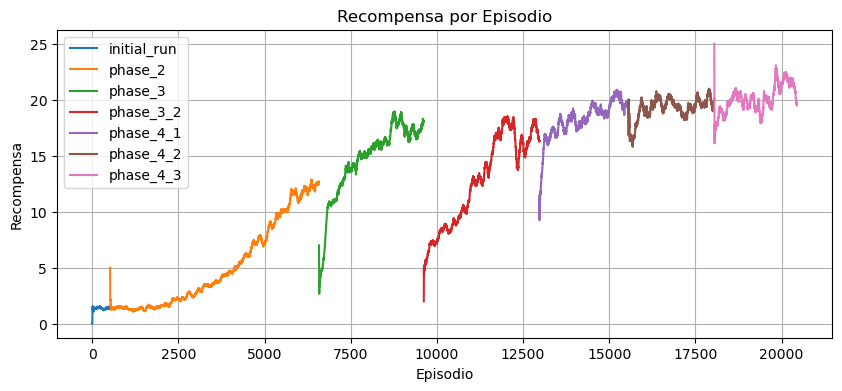

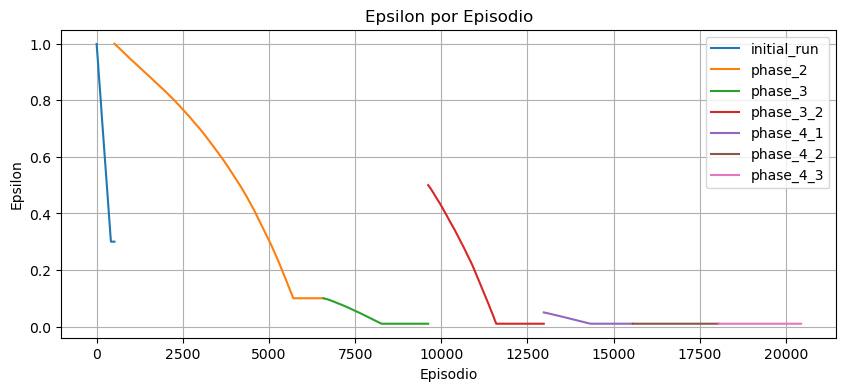

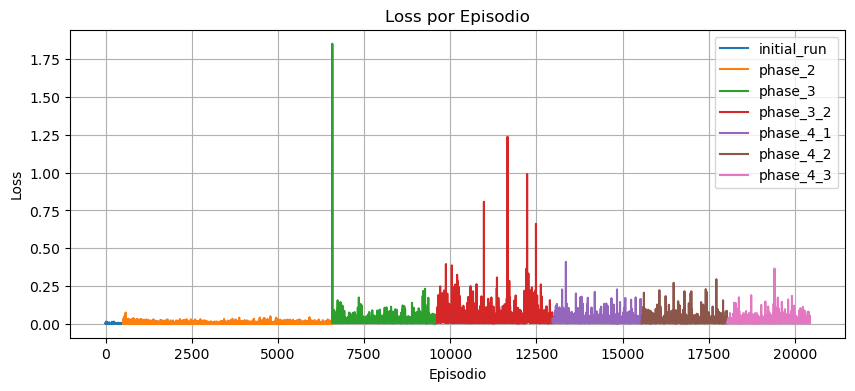

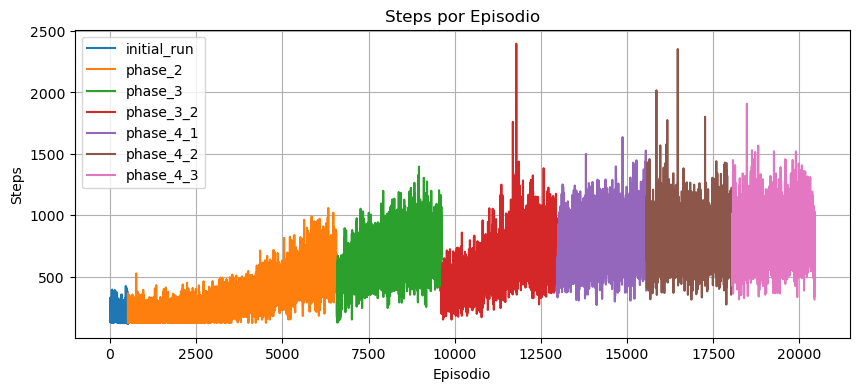

In [27]:
phase_ids = [PHASE_INITIAL_ID, PHASE_2_ID, PHASE_3_ID, PHASE_3_2_ID, PHASE_4_1_ID, PHASE_4_2_ID, PHASE_4_3_ID]
metrics_path = getMetricFilePathList(True, phase_ids)
graph_metrics_accumulated(metrics_path, phase_ids)

El análisis global de todas las fases evidencia que la estrategia de entrenamiento progresivo, permitió que el agente **DQN** supere la recompensa mínima planteada `(romper > 10 bloques)`, para resolver el entorno **Breakout**, alcanzando una política razonablemente eficaz para mantener la pelota en juego y destruir bloques de forma consistente alcanzando los `40 bloques` en ejecuciones de validación.

Sin embargo, al observar la evolución acumulada de la **recompensa promedio**, se advierte que, aunque se logra un crecimiento sostenido a lo largo de las fases, el agente tiende a estabilizarse alrededor de valores cercanos a **20–25 bloques destruidos**, lo cual está lejos de los máximos alcanzables en este entorno. Este comportamiento sugiere que, pese a la fase de re-exploración (*phase 3.2*), donde se comprobó que incluso aumentando la exploración no se logró superar lo alcanzado en *phase 3.1*, el agente aún puede quedar atrapado en políticas subóptimas, limitando así su potencial de mejora a largo plazo.

El análisis de la **pérdida** y de los **pasos por episodio** refuerza esta interpretación: aunque la duración de los episodios aumenta y se mantiene elevada, los picos persistentes de pérdida en fases intermedias y finales sugieren la presencia de un sesgo de sobreestimación, ya que algunas de las acciones valoradas como óptimas podrían no ser realmente las más eficaces.

Estas observaciones destaca la importancia de considerar variantes mejoradas del algoritmo, como **Double DQN (DDQN)**, que introduce un mecanismo para reducir la sobreestimación de los valores Q. Este enfoque contribuye a mitigar el sesgo optimista que suele derivar en políticas menos eficientes. Tanto en la literatura como en experimentos preliminares, **DDQN** ha demostrado generar políticas más estables, con menor varianza y un rendimiento promedio superior en entornos como Breakout, precisamente porque desacopla la selección de acciones de su evaluación, reduciendo así la probabilidad de fijarse en trayectorias poco óptimas.


## Mejor jugada obtenida para DQN

`Recompensa alcanzada = 42`

In [ ]:
video_path = f'./videos/dqn/validation/{PHASE_4_3_ID}/breakout-episode-0.mp4'
Video(video_path, embed=True, width=600)

# Double Deep Q Learning

Double DQN mejora la versión clásica de DQN corrigiendo el sesgo de sobreestimación de los valores
𝑄
Q. Para ello, desacopla la selección de la acción de su evaluación: en cada paso, la red online elige la acción que maximiza
𝑄
Q, pero la red objetivo distinta estima el valor de esa acción. Esta separación reduce el sesgo hacia valores demasiado optimistas y aporta mayor estabilidad al entrenamiento. El resto de la estructura —replay buffer, política ε-greedy, etc— se mantiene igual que en DQN, aprovechando así un diseño casi idéntico al original pero con resultados más fiables .

Fuente: [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)

> Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

# Entrenamiento Progresivo de un Agente DDQN en Breakout

En esta sección del obligatorio implementamos un agente basado en Double Deep Q-Network (DQN) para resolver el entorno **Breakout** de Atari.

El objetivo es demostrar progresivamente cómo el agente mejora su rendimiento a través de fases de entrenamiento, visualización de métricas y evaluación.


### Los Hiperparámetros fijos y dinámicos se mantuvieron iguales que el entrenamiento con DQN

* Fijos:
    - BATCH_SIZE = 32
    - BUFFER_SIZE = 50_000
    - EPISODE_BLOCK = 100
    - LEARNING_RATE = 1e-5
    - STEPS_PER_EPISODE = 20_000
    - EPISODES = 10_000
    - GAMMA = 0.995

* Dinámicos:
    - TOTAL_STEPS
    - EPSILON_INI
    - EPSILON_MIN
    - EPSILON_ANNEAL_STEPS

## FASE INICIAL: Exploración Inicial

La fase inicial del entrenamiento con DDQN se mantiene igual a la usada en DQN, con el objetivo de que el agente explore el entorno de forma amplia y recopile experiencias variadas para llenar el buffer de memoria.

Se configuraron **100.000 pasos** con un esquema de exploración alto:

- `ε_ini = 1.0`
- `ε_min = 0.3`
- `ε_anneal_steps = 80.000`

Durante esta etapa no se busca optimizar aún la política, sino generar una base de datos rica que permita que el aprendizaje posterior con DDQN sea más estable y efectivo.


In [ ]:
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_INITIAL)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}")
ddqn_agent = execute_ddqn_training_phase(PHASE_ID, reference_states, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

PHASE_ID: initial_run, TOTAL_STEPS: 100000, EPISODES: 10000, EPSILON_INI: 1, EPSILON_MIN: 0.3, EPSILON_ANNEAL_STEPS: 80000
Parametros del agente:
loadPath: None
gamma: 0.995
epsilon_i: 1
epsilon_f: 0.3
epsilon_anneal_steps: 80000
run_name: initial_run


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento initial_run, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 1, epsilon_f: 0.3, epsilon_anneal_steps: 80000, max_steps: 100000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   5%|▍         | 491/10000 [08:19<2:41:07,  1.02s/episode, reward=1.72, epsilon=0.3, steps=1e+5]


Entrenamiento detenido: se alcanzaron 100001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Resultados del entrenamiento - Fase Inicial

Datos cargados de metrics/ddqn/metrics_initial_run.npz: [[60 42 63 41]
 [30 35 41 33]
 [51 58 54 42]
 ...
 [34 60 21 17]
 [38 38 48 12]
 [14 22 32 17]]


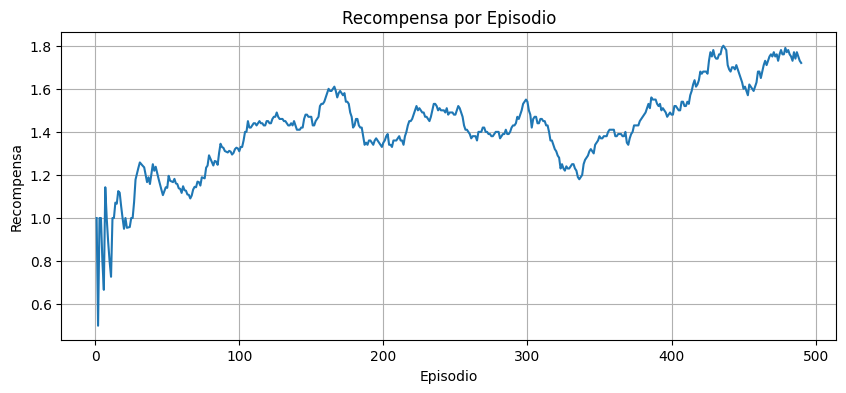

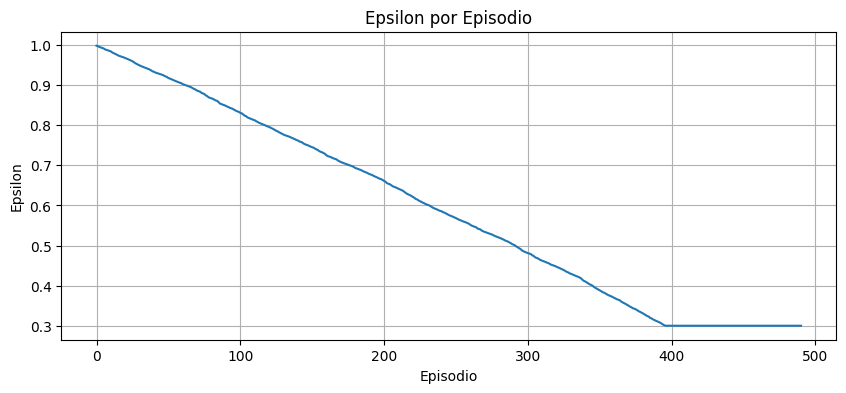

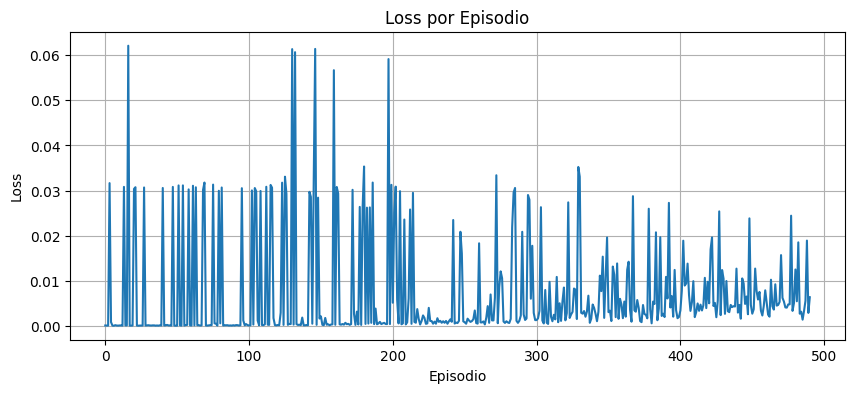

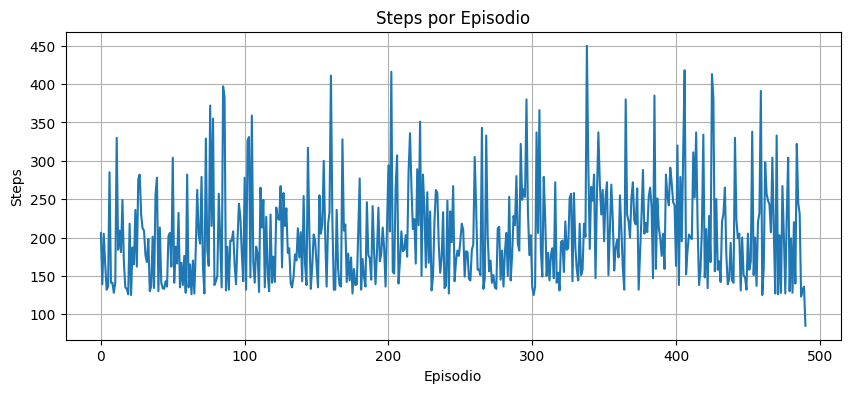

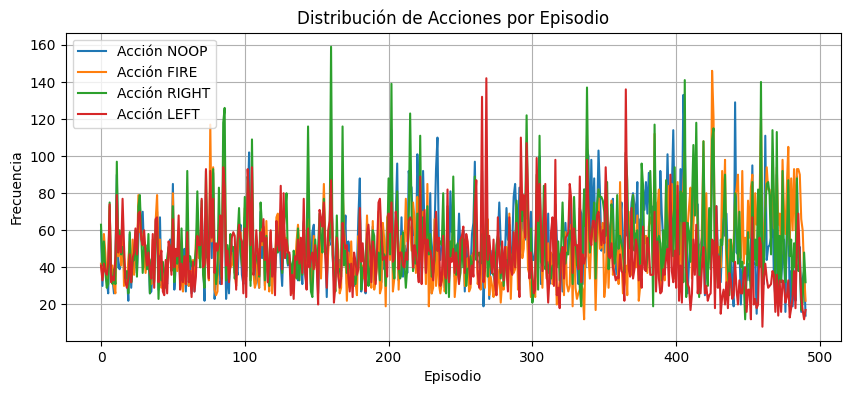

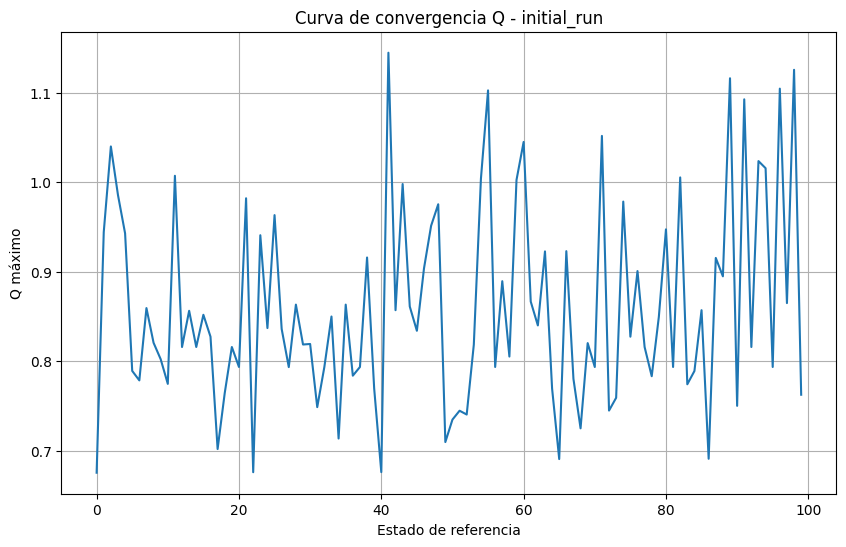

In [ ]:
METRICS_PATH = getMetricFilePath(False, PHASE_INITIAL["id"])
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_INITIAL["id"], type=DOUBLE_DQN_TYPE)


El comportamiento de `DDQN` durante la fase inicial es `coherente con lo esperado`. El agente explora adecuadamente, el loss se mantiene controlado, y las recompensas muestran una mejora gradual. Las gráficas validan la hipótesis planteada: `DDQN ofrece un aprendizaje más estable y menos ruidoso que DQN desde las primeras etapas, sin comprometer la capacidad de exploración.`

### Evaluamos comportamiento del agente - Fase Inicial

In [ ]:
video_path = execute_agent_play(ddqn_agent, PHASE_INITIAL["id"], DOUBLE_DQN_TYPE)
Video(video_path, embed=True, width=600)

Ejecutando el agente ddqn en modo evaluación...
Recompensa total del episodio 0: 0.0
Recompensa total promedio: 0.0


## Fase 2 de entrenamiento: Exploración

En esta fase se continúa con una exploración intensa para que el agente siga acumulando experiencias diversas y comience a refinar sus decisiones.

Se utilizaron **2.000.000 de pasos** con los siguientes parámetros:

- `ε_ini = 1.0:`
- `ε_min = 0.1:`
- `ε_anneal_steps = 1.500.000:`

Al igual que en DQN, se emplea un `gamma de 0.97`, definido previamente como el valor más adecuado para esta etapa de aprendizaje.

### Hipótesis comparativa:
Como DDQN corrige el **problema de sobreestimación** de Q-values que tiene DQN (Mnih et al., 2015), esperamos que el aprendizaje en esta etapa sea más estable y con menos variaciones bruscas en la pérdida. Según Sutton y Barto (2018), este tipo de corrección ayuda a que el agente se enfoque mejor en aprender valores realistas sin que decisiones aleatorias inflen demasiado las estimaciones. Por eso, aunque el entorno y el esquema de exploración son los mismos que en DQN, deberíamos ver una mejora más progresiva y menos ruidosa


In [ ]:
EXPLORATION_GAMMA = 0.97
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_INITIAL_ID)
print(f"LOAD_NET_PATH: {LOAD_NET_PATH}")

PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")
ddqn_agent = execute_ddqn_training_phase(PHASE_ID, reference_states, load_net_path=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS, gamma=EXPLORATION_GAMMA)

### Resultados del entrenamiento - Fase 2

Datos cargados de metrics/ddqn/metrics_phase_2.npz: [[ 44  52  47  38]
 [ 43  48  39  44]
 [ 33  37  30  35]
 ...
 [127 199 118 188]
 [123 214 133 155]
 [ 95 135  96 105]]


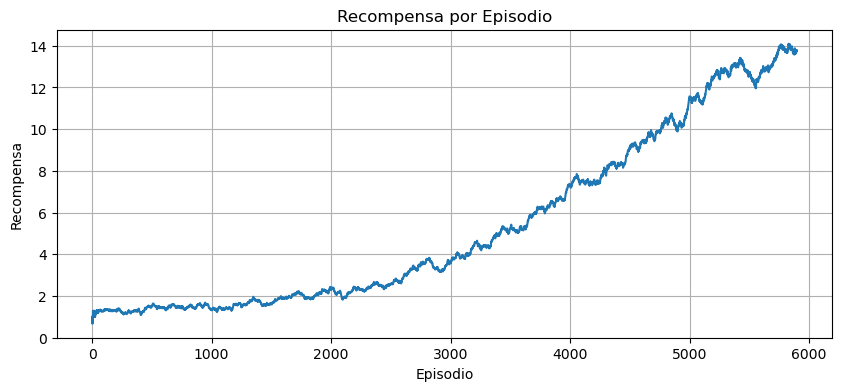

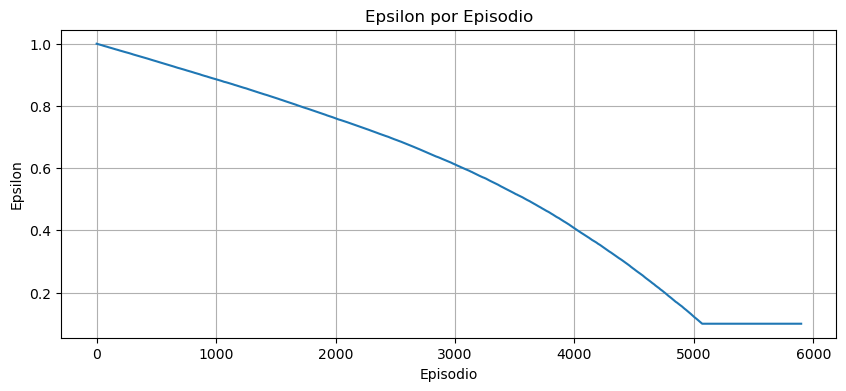

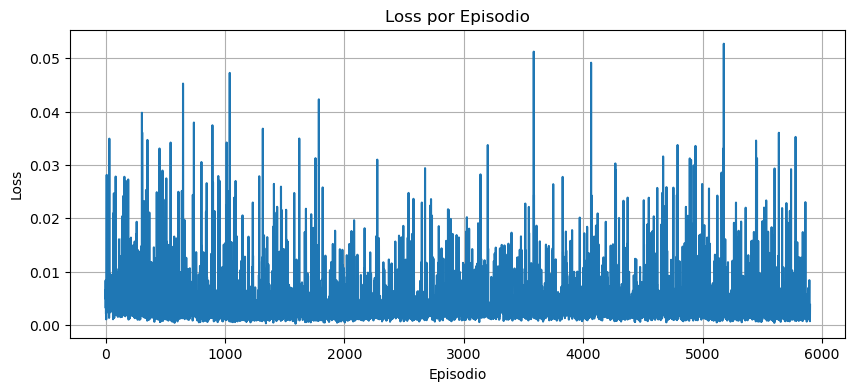

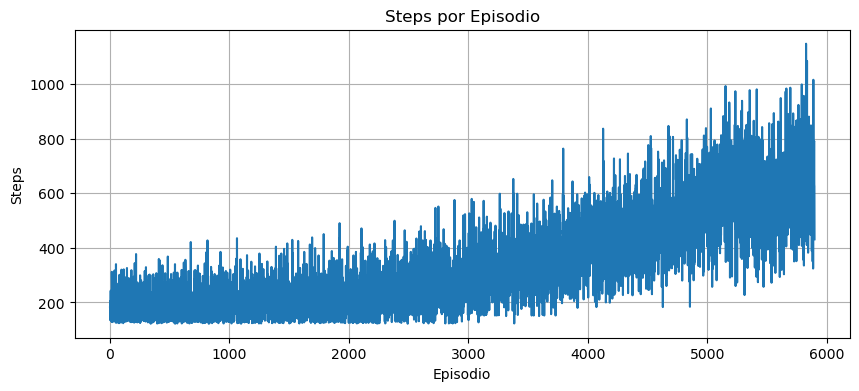

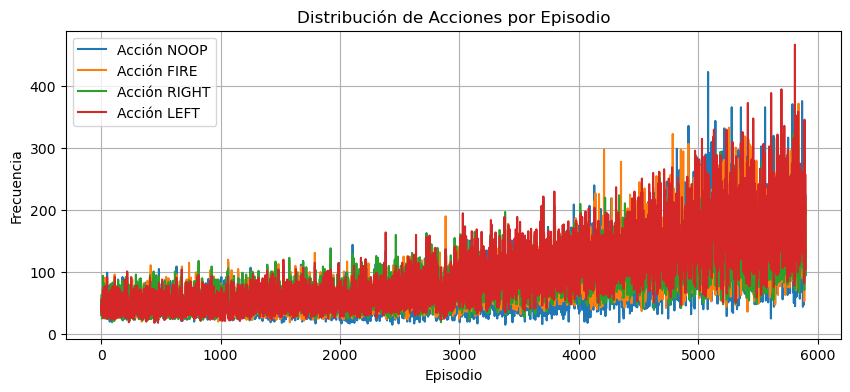

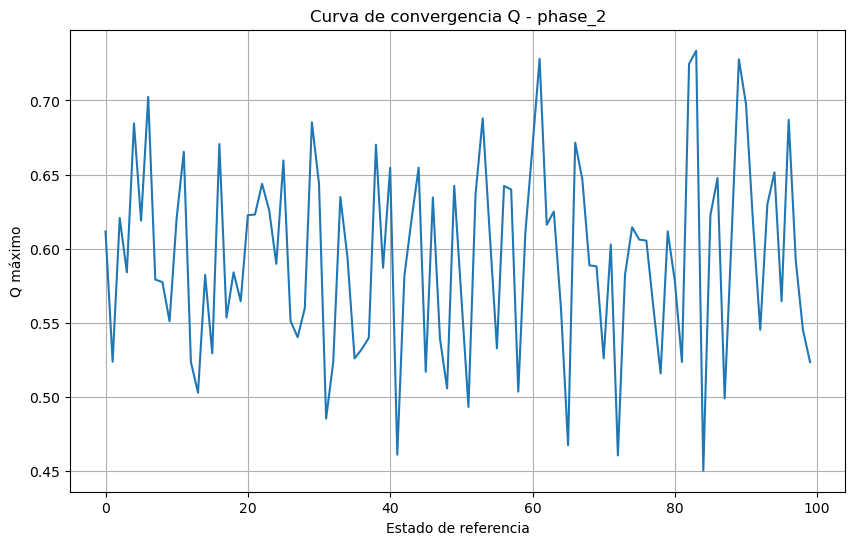

In [ ]:
METRICS_PATH = getMetricFilePath(False, PHASE_2["id"])
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_2["id"], type=DOUBLE_DQN_TYPE)

Durante la Fase 2, DDQN mostró una mejora clara y sostenida en la recompensa, `alcanzando una recompensa maxima de 14`, superando los 12 logrados por DQN bajo los mismos parámetros. La pérdida fue más estable y el agente acumuló más pasos por episodio, lo que indica decisiones más efectivas. Esto valida la hipótesis planteada: El aprendizaje en esta etapa es más estable y con menos variaciones bruscas en la pérdida (Mnih et al., 2015), logrando una política más precisa y consistente.

### Evaluamos comportamiento del Agente - Fase 2

In [ ]:
video_path = execute_agent_play(ddqn_agent, PHASE_2["id"], DOUBLE_DQN_TYPE, play=False)
Video(video_path, embed=True, width=600)

## Fase 3 de entrenamiento: Ajuste de la política - exploración vs explotación

En esta etapa el agente comienza a explotar de forma más activa las políticas que fue aprendiendo. Se reduce significativamente la exploración para consolidar comportamientos efectivos.

- `2.000.000 de pasos`
- `ε_ini = 0.1:`
- `ε_min = 0.01:`
- `ε_anneal_steps = 1.000.000:`

### Hipótesis comparativa:
En esta fase, donde el agente empieza a explotar más seguido, se espera que DDQN `tome mejores decisiones que DQN`. Al evitar la sobreestimación de Q-values, es más probable que no se quede atrapado en políticas subóptimas. En teoría, deberíamos ver **más consistencia** en el rendimiento y posiblemente una mejor recompensa media que en el entrenamiento anterior con DQN.

In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_2["id"])
print(f"LOAD_NET_PATH: {LOAD_NET_PATH}")

PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")
ddqn_agent = execute_ddqn_training_phase(PHASE_ID, reference_states, load_net_path=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

LOAD_NET_PATH: net_history/ddqn/GenericDDQNAgent-phase_2.dat
PHASE_ID: phase_3, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.1, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/ddqn/GenericDDQNAgent-phase_2.dat
Parametros del agente:
loadPath: net_history/ddqn/GenericDDQNAgent-phase_2.dat
gamma: 0.995
epsilon_i: 0.1
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
run_name: phase_3


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_3, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.1, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   3%|▎         | 267/10000 [13:06<7:46:43,  2.88s/episode, reward=12.3, epsilon=0.0865, steps=150306]


=== Recompensa actual: 12.28, Epsilon: 0.08647246, Total steps: 150306 ===


Entrenando:   5%|▌         | 508/10000 [26:14<8:14:44,  3.13s/episode, reward=13.8, epsilon=0.073, steps=3e+5]


=== Recompensa actual: 13.8, Epsilon: 0.07297615, Total steps: 300265 ===


Entrenando:   7%|▋         | 749/10000 [39:16<9:20:23,  3.63s/episode, reward=13.3, epsilon=0.0594, steps=450684]


=== Recompensa actual: 13.26, Epsilon: 0.05943844, Total steps: 450684 ===


Entrenando:  10%|▉         | 980/10000 [52:18<10:03:16,  4.01s/episode, reward=15.6, epsilon=0.0459, steps=600635]


=== Recompensa actual: 15.58, Epsilon: 0.04594284999999999, Total steps: 600635 ===


Entrenando:  12%|█▏        | 1189/10000 [1:05:20<9:30:03,  3.88s/episode, reward=16.8, epsilon=0.0325, steps=750347]


=== Recompensa actual: 16.76, Epsilon: 0.032468769999999994, Total steps: 750347 ===


Entrenando:  14%|█▍        | 1381/10000 [1:18:20<9:55:39,  4.15s/episode, reward=17.9, epsilon=0.019, steps=9e+5]


=== Recompensa actual: 17.92, Epsilon: 0.018984699999999993, Total steps: 900170 ===


Entrenando:  16%|█▌        | 1573/10000 [1:31:29<10:10:30,  4.35s/episode, reward=18.4, epsilon=0.01, steps=1050569]


=== Recompensa actual: 18.38, Epsilon: 0.01, Total steps: 1050569 ===


Entrenando:  18%|█▊        | 1762/10000 [1:44:26<9:18:13,  4.07s/episode, reward=18.6, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 18.64, Epsilon: 0.01, Total steps: 1200378 ===


Entrenando:  19%|█▉        | 1943/10000 [1:57:23<10:03:07,  4.49s/episode, reward=20.7, epsilon=0.01, steps=1350658]


=== Recompensa actual: 20.66, Epsilon: 0.01, Total steps: 1350658 ===


Entrenando:  21%|██        | 2120/10000 [2:10:24<9:32:38,  4.36s/episode, reward=20.4, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 20.36, Epsilon: 0.01, Total steps: 1500159 ===


Entrenando:  23%|██▎       | 2296/10000 [2:23:19<9:04:57,  4.24s/episode, reward=20, epsilon=0.01, steps=1650688]


=== Recompensa actual: 20.0, Epsilon: 0.01, Total steps: 1650688 ===


Entrenando:  25%|██▍       | 2463/10000 [2:36:07<11:36:16,  5.54s/episode, reward=22.8, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 22.77, Epsilon: 0.01, Total steps: 1800387 ===


Entrenando:  26%|██▌       | 2624/10000 [2:49:03<10:23:19,  5.07s/episode, reward=23.3, epsilon=0.01, steps=1950694]


=== Recompensa actual: 23.33, Epsilon: 0.01, Total steps: 1950694 ===


Entrenando:  27%|██▋       | 2680/10000 [2:53:17<7:53:18,  3.88s/episode, reward=22, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Resultados del entrenamiento - Fase 3

Datos cargados de metrics/ddqn/metrics_phase_3.npz: [[ 28 144 140 164]
 [198 149 192 223]
 [101  96 129 128]
 ...
 [368 230 227 234]
 [110 377 181 182]
 [236 176 173 212]]


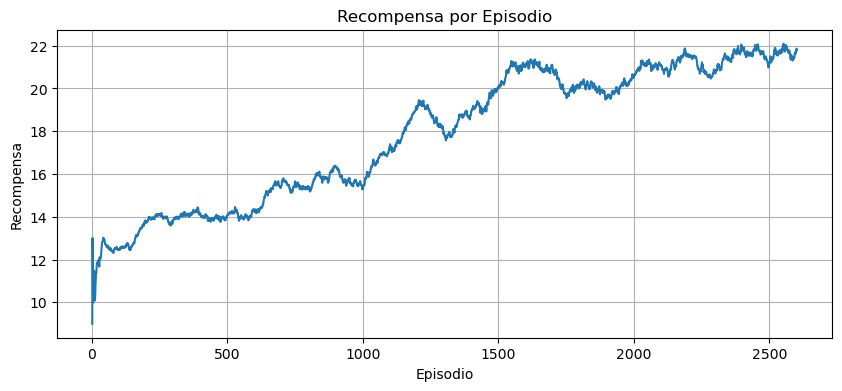

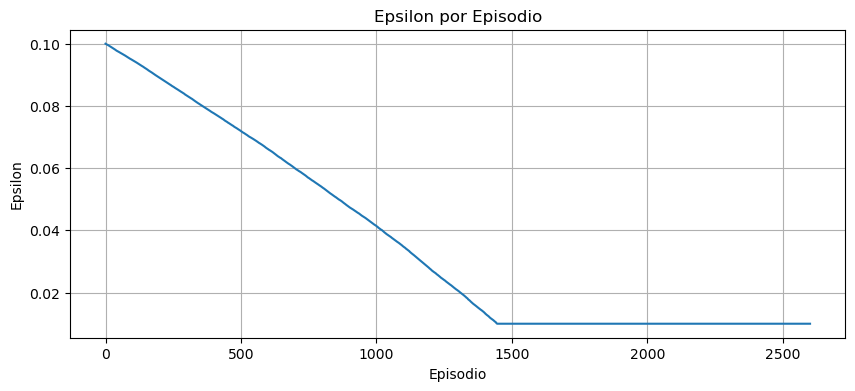

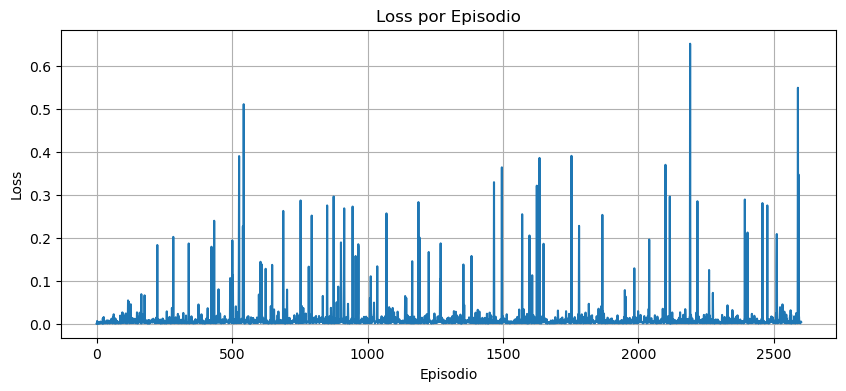

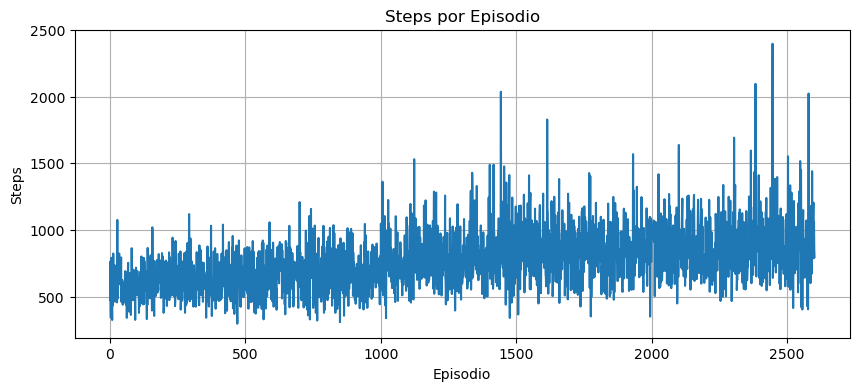

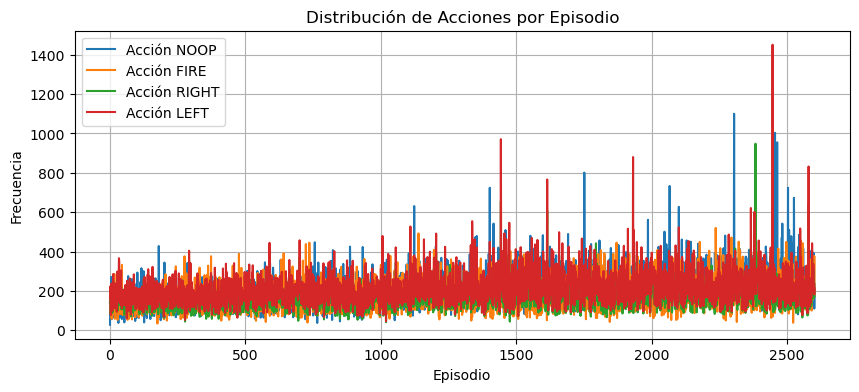

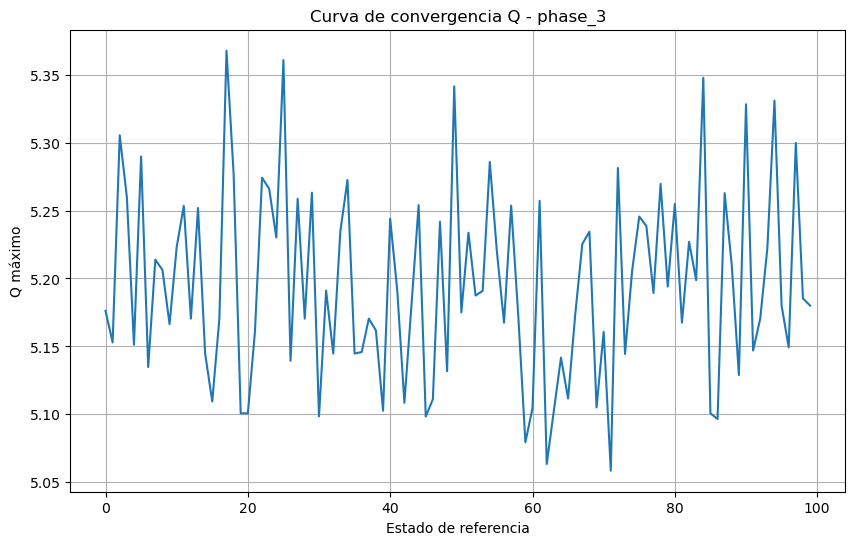

In [ ]:
METRICS_PATH = getMetricFilePath(False, PHASE_3["id"])
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_3["id"], type=DOUBLE_DQN_TYPE)

En la Fase 3, DDQN alcanzó una recompensa máxima de 22, superando a DQN que se había estancado entre 16 y 18. La curva de recompensa muestra una mejora sostenida con picos más altos y menos retrocesos abruptos, lo que indica una explotación más efectiva. Esto confirma la hipótesis planteada: al corregir la sobreestimación de Q-values, DDQN evitó políticas subóptimas y logró decisiones más eficientes, reflejadas también en un aumento progresivo de pasos por episodio y una pérdida más estable.

### Evaluamos comportamiento del Agente - Fase 3

In [ ]:
video_path = execute_agent_play(ddqn_agent, PHASE_ID, DOUBLE_DQN_TYPE, play=False)
Video(video_path, embed=True, width=600)

### Fase 3_2: Exploración complementaria

Siguiendo los parámetros de las fases de entrenamiento definidas, mantenemos la fase 3_2 para evitar que el agente llegue a políticas sub-óptimas, agregando mas pasos de exploración antes de explotar continuamente.


- `ε_ini = 0.5:` se vuelve a explorar con más intensidad al inicio.
- `ε_min = 0.01:` se reduce la exploración gradualmente, pero no se elimina por completo.
- `ε_anneal_steps = 1.000.000:` se mantiene un descenso progresivo y balanceado.

#### Hipótesis comparativa:
Al aplicar esta fase con DDQN, esperamos que el agente aproveche mejor la exploración adicional que en DQN, ya que sus estimaciones de valor son más estables. Esto le podría permitir descubrir trayectorias más útiles sin verse tan afectado por errores de sobreestimación. En teoría, debería lograr recuperar el aprendizaje más rápido y con mayor precisión.

In [28]:
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_3_ID)
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

PHASE_ID: phase_3_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.5, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/ddqn/GenericDDQNAgent-phase_3.dat


In [ ]:
ddqn_agent_phase_3_2 = execute_ddqn_training_phase(PHASE_ID, reference_states, load_net_path=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

Parametros del agente:
loadPath: net_history/ddqn/GenericDDQNAgent-phase_3.dat
gamma: 0.995
epsilon_i: 0.5
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
run_name: phase_3_2


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/ddqn/phase_3_2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_3_2, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.5, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   4%|▎         | 359/10000 [12:36<5:54:15,  2.20s/episode, reward=8.32, epsilon=0.426, steps=150270]


=== Recompensa actual: 8.32, Epsilon: 0.4263677, Total steps: 150270 ===


Entrenando:   7%|▋         | 667/10000 [25:21<7:32:12,  2.91s/episode, reward=10, epsilon=0.353, steps=300538]


=== Recompensa actual: 10.03, Epsilon: 0.35273637999999996, Total steps: 300538 ===


Entrenando:   9%|▉         | 938/10000 [38:06<7:10:13,  2.85s/episode, reward=12, epsilon=0.279, steps=450539]


=== Recompensa actual: 12.04, Epsilon: 0.27923589, Total steps: 450539 ===


Entrenando:  12%|█▏        | 1180/10000 [50:54<8:18:33,  3.39s/episode, reward=14.1, epsilon=0.206, steps=6e+5]


=== Recompensa actual: 14.07, Epsilon: 0.20585202000000002, Total steps: 600302 ===


Entrenando:  14%|█▍        | 1400/10000 [1:03:37<8:22:09,  3.50s/episode, reward=15.5, epsilon=0.132, steps=750384]


=== Recompensa actual: 15.53, Epsilon: 0.13231183999999996, Total steps: 750384 ===


Entrenando:  16%|█▌        | 1595/10000 [1:16:29<11:07:42,  4.77s/episode, reward=18.7, epsilon=0.0586, steps=900888]


=== Recompensa actual: 18.74, Epsilon: 0.058564879999999986, Total steps: 900888 ===


Entrenando:  18%|█▊        | 1769/10000 [1:29:12<8:10:23,  3.57s/episode, reward=21.8, epsilon=0.01, steps=1050408]


=== Recompensa actual: 21.76, Epsilon: 0.01, Total steps: 1050408 ===


Entrenando:  19%|█▉        | 1932/10000 [1:42:01<10:13:55,  4.57s/episode, reward=22.3, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 22.29, Epsilon: 0.01, Total steps: 1200617 ===


Entrenando:  21%|██        | 2089/10000 [1:54:53<10:53:57,  4.96s/episode, reward=23.5, epsilon=0.01, steps=1350891]


=== Recompensa actual: 23.53, Epsilon: 0.01, Total steps: 1350891 ===


Entrenando:  23%|██▎       | 2253/10000 [2:07:33<9:15:01,  4.30s/episode, reward=22.2, epsilon=0.01, steps=1.5e+6] 


=== Recompensa actual: 22.17, Epsilon: 0.01, Total steps: 1500436 ===


Entrenando:  24%|██▍       | 2411/10000 [2:20:18<11:48:35,  5.60s/episode, reward=23.9, epsilon=0.01, steps=1650790]


=== Recompensa actual: 23.93, Epsilon: 0.01, Total steps: 1650790 ===


Entrenando:  26%|██▌       | 2566/10000 [2:33:05<8:39:04,  4.19s/episode, reward=23.4, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 23.41, Epsilon: 0.01, Total steps: 1800079 ===


Entrenando:  27%|██▋       | 2723/10000 [2:45:48<9:21:02,  4.63s/episode, reward=23.5, epsilon=0.01, steps=1950055]


=== Recompensa actual: 23.46, Epsilon: 0.01, Total steps: 1950055 ===


Entrenando:  28%|██▊       | 2774/10000 [2:50:01<7:22:54,  3.68s/episode, reward=23.9, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


#### Resultados del entrenamiento - Fase 3_2

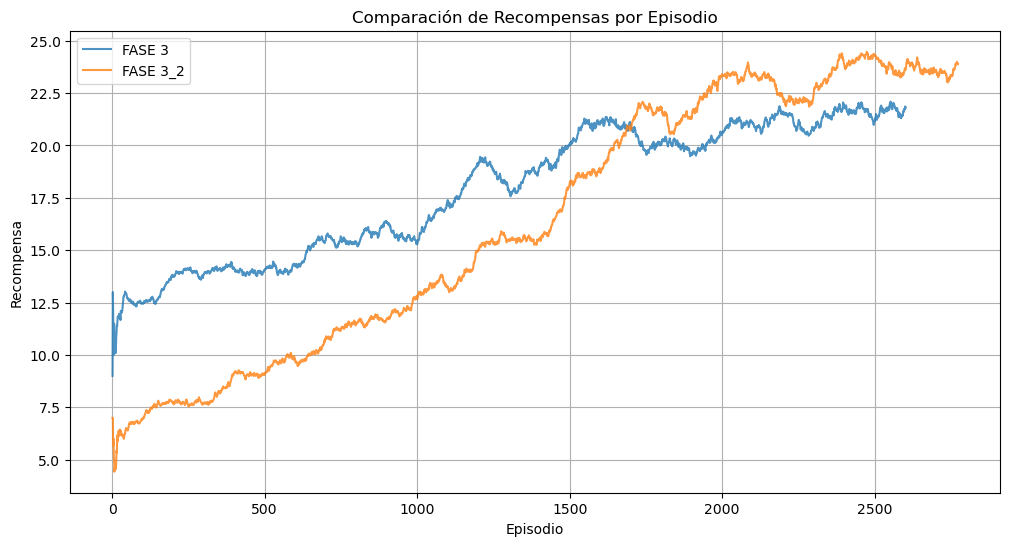

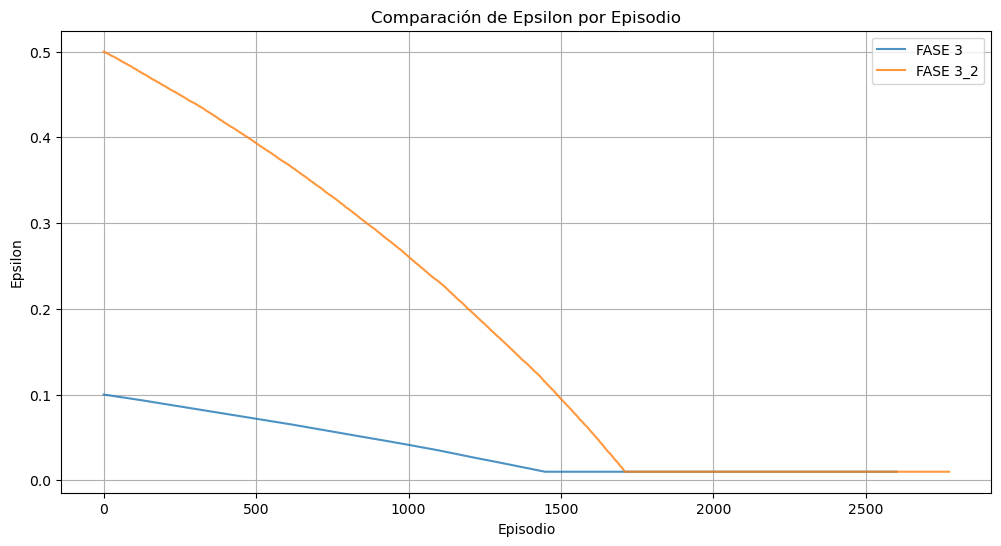

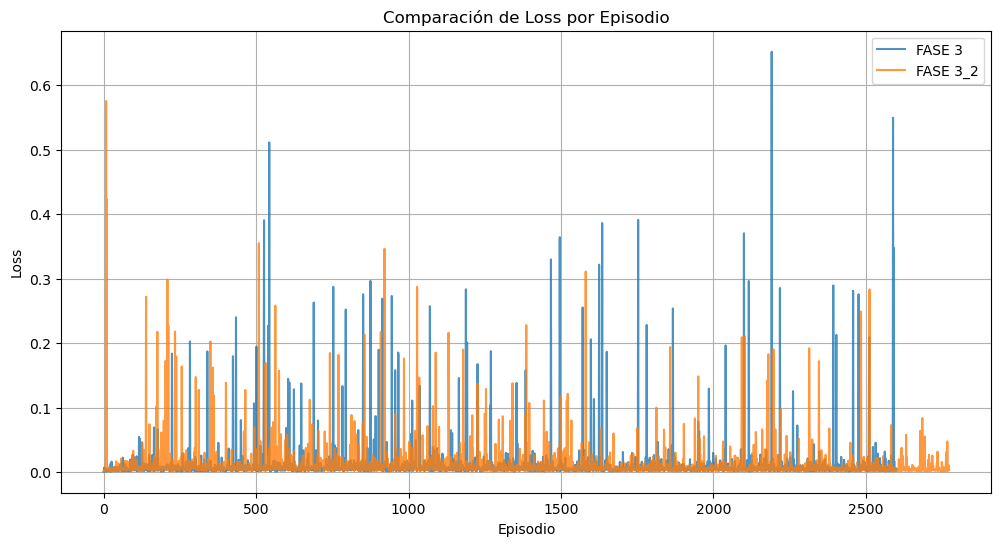


=== RESUMEN ESTADÍSTICO ===

FASE 3:
  Recompensa promedio: 17.85 ± 3.11
  Recompensa máxima: 22.09
  Recompensa mínima: 9.00
  Loss promedio: 0.0126 ± 0.0403
  Steps promedio: 768.6 ± 212.0
  Epsilon final: 0.0100
  Episodios totales: 2602
  Episodios con recompensas válidas: 2601
  Porcentaje de datos válidos: 100.0%

FASE 3_2:
  Recompensa promedio: 16.32 ± 6.10
  Recompensa máxima: 24.47
  Recompensa mínima: 4.43
  Loss promedio: 0.0133 ± 0.0317
  Steps promedio: 721.0 ± 277.3
  Epsilon final: 0.0100
  Episodios totales: 2774
  Episodios con recompensas válidas: 2773
  Porcentaje de datos válidos: 100.0%


In [29]:
metrics_paths = [getMetricFilePath(False, PHASE_3_ID), getMetricFilePath(False, f"{PHASE_3_2_ID}")]
compare_metrics(metrics_paths, labels=["FASE 3", "FASE 3_2"], show_rewards=True, show_losses=True, show_steps=False, show_actions=False, show_epsilons=True)

En la Fase 3_2, se observa que, a diferencia de DQN, cuyo promedio de recompensa se mantuvo en torno a 18 incluso tras añadir pasos extra de exploración, DDQN logró `aprovechar mejor esta etapa`. Su recompensa máxima `aumentó de 22 a 25`, lo que indica una mejora efectiva en la política aprendida. Esta diferencia también se refleja al evaluar el agente en modo play, donde DDQN demuestra un **comportamiento más estable, eficiente y con una política mejor definida.**

## Fase 4: Consolidación de la política aprendida

Esta última etapa está pensada para que el agente consolide su política final. Ya no se busca explorar, sino actuar casi siempre según lo que aprendió. Por cuestiones prácticas (guardar checkpoints y evitar perder progreso), esta fase se dividió en tres bloques iguales.

Cada subfase tiene:
- `2.000.000 pasos`
- `En Fase 4.1: ε_ini = 0.05 → ε_min = 0.01`
- `En Fases 4.2 y 4.3: ε = 0.01 constante`

### Hipótesis comparativa:
Durante esta etapa, DDQN debería mostrar un comportamiento más consistente y menos sensible a errores que DQN, ya que sus actualizaciones son más conservadoras y menos propensas a sobrevalorar ciertas acciones. Esto debería traducirse en políticas más estables y robustas al final del entrenamiento.



In [ ]:
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_1)
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_3_2_ID)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")
VIDEO_FOLDER = f"./videos/dqn_training_{PHASE_ID}"


PHASE_ID: phase_4_1, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.05, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/ddqn/GenericDDQNAgent-phase_3_2.dat


In [ ]:
ddqn_agent_phase_4_1 = execute_ddqn_training_phase(PHASE_ID, reference_states, load_net_path=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/ddqn/phase_4_1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Parametros del agente:
loadPath: net_history/ddqn/GenericDDQNAgent-phase_3_2.dat
gamma: 0.995
epsilon_i: 0.05
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
run_name: phase_4_1


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_4_1, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.05, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




Entrenando:   2%|▏         | 179/10000 [12:57<13:28:03,  4.94s/episode, reward=20.6, epsilon=0.044, steps=150163]


=== Recompensa actual: 20.63, Epsilon: 0.04399348, Total steps: 150163 ===


Entrenando:   3%|▎         | 347/10000 [25:59<12:53:30,  4.81s/episode, reward=22.1, epsilon=0.038, steps=300764]


=== Recompensa actual: 22.07, Epsilon: 0.03796944000000001, Total steps: 300764 ===


Entrenando:   5%|▌         | 513/10000 [38:59<11:20:59,  4.31s/episode, reward=22.8, epsilon=0.032, steps=450196]


=== Recompensa actual: 22.82, Epsilon: 0.031992160000000006, Total steps: 450196 ===


Entrenando:   7%|▋         | 681/10000 [51:56<11:36:19,  4.48s/episode, reward=22.4, epsilon=0.026, steps=6e+5]


=== Recompensa actual: 22.41, Epsilon: 0.0259966, Total steps: 600085 ===


Entrenando:   8%|▊         | 846/10000 [1:05:07<10:23:52,  4.09s/episode, reward=21.9, epsilon=0.02, steps=750001]


=== Recompensa actual: 21.95, Epsilon: 0.01999996, Total steps: 750001 ===


Entrenando:  10%|█         | 1004/10000 [1:18:25<16:37:04,  6.65s/episode, reward=22.7, epsilon=0.0139, steps=901543]


=== Recompensa actual: 22.71, Epsilon: 0.013938280000000004, Total steps: 901543 ===


Entrenando:  12%|█▏        | 1155/10000 [1:31:23<17:09:42,  6.98s/episode, reward=24.5, epsilon=0.01, steps=1050536]


=== Recompensa actual: 24.49, Epsilon: 0.01, Total steps: 1050536 ===


Entrenando:  13%|█▎        | 1311/10000 [1:44:26<11:54:40,  4.94s/episode, reward=23.5, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 23.47, Epsilon: 0.01, Total steps: 1200908 ===


Entrenando:  15%|█▍        | 1460/10000 [1:57:27<13:19:33,  5.62s/episode, reward=24.6, epsilon=0.01, steps=1350181]


=== Recompensa actual: 24.62, Epsilon: 0.01, Total steps: 1350181 ===


Entrenando:  16%|█▌        | 1610/10000 [2:10:26<13:38:38,  5.85s/episode, reward=25.2, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 25.23, Epsilon: 0.01, Total steps: 1500901 ===


Entrenando:  18%|█▊        | 1759/10000 [2:23:22<13:29:38,  5.89s/episode, reward=25.5, epsilon=0.01, steps=1650545]


=== Recompensa actual: 25.49, Epsilon: 0.01, Total steps: 1650545 ===


Entrenando:  19%|█▉        | 1914/10000 [2:36:23<9:53:27,  4.40s/episode, reward=24.7, epsilon=0.01, steps=1.8e+6] 


=== Recompensa actual: 24.72, Epsilon: 0.01, Total steps: 1800588 ===


Entrenando:  21%|██        | 2071/10000 [2:49:26<9:37:23,  4.37s/episode, reward=23.9, epsilon=0.01, steps=1950557] 


=== Recompensa actual: 23.91, Epsilon: 0.01, Total steps: 1950557 ===


Entrenando:  21%|██        | 2119/10000 [2:53:42<10:46:04,  4.92s/episode, reward=24.3, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_4_1_ID)
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

PHASE_ID: phase_4_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.01, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 2000000, LOAD_NET_PATH: net_history/ddqn/GenericDDQNAgent-phase_4_1.dat


In [ ]:
ddqn_agent_phase_4_2 = execute_ddqn_training_phase(PHASE_ID, reference_states, load_net_path=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

Parametros del agente:
loadPath: net_history/ddqn/GenericDDQNAgent-phase_4_1.dat
gamma: 0.995
epsilon_i: 0.01
epsilon_f: 0.01
epsilon_anneal_steps: 2000000
run_name: phase_4_2


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_4_2, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.01, epsilon_f: 0.01, epsilon_anneal_steps: 2000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   2%|▏         | 157/10000 [13:43<12:30:37,  4.58s/episode, reward=23.8, epsilon=0.01, steps=150659]


=== Recompensa actual: 23.8, Epsilon: 0.01, Total steps: 150659 ===


Entrenando:   3%|▎         | 313/10000 [27:08<14:17:59,  5.31s/episode, reward=24.8, epsilon=0.01, steps=300658]


=== Recompensa actual: 24.84, Epsilon: 0.01, Total steps: 300658 ===


Entrenando:   5%|▍         | 462/10000 [40:45<14:59:37,  5.66s/episode, reward=25.4, epsilon=0.01, steps=450715]


=== Recompensa actual: 25.41, Epsilon: 0.01, Total steps: 450715 ===


Entrenando:   6%|▌         | 609/10000 [54:24<13:11:35,  5.06s/episode, reward=25.6, epsilon=0.01, steps=6e+5]


=== Recompensa actual: 25.55, Epsilon: 0.01, Total steps: 600155 ===


Entrenando:   8%|▊         | 756/10000 [1:08:01<15:00:33,  5.85s/episode, reward=25.9, epsilon=0.01, steps=750983]


=== Recompensa actual: 25.87, Epsilon: 0.01, Total steps: 750983 ===


Entrenando:   9%|▉         | 905/10000 [1:21:23<15:05:19,  5.97s/episode, reward=24.8, epsilon=0.01, steps=9e+5]


=== Recompensa actual: 24.81, Epsilon: 0.01, Total steps: 900118 ===


Entrenando:  11%|█         | 1051/10000 [1:35:05<14:06:55,  5.68s/episode, reward=26.4, epsilon=0.01, steps=1050513]


=== Recompensa actual: 26.43, Epsilon: 0.01, Total steps: 1050513 ===


Entrenando:  12%|█▏        | 1202/10000 [1:48:43<16:01:10,  6.55s/episode, reward=24.6, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 24.63, Epsilon: 0.01, Total steps: 1200936 ===


Entrenando:  14%|█▎        | 1354/10000 [2:02:14<11:44:21,  4.89s/episode, reward=24.6, epsilon=0.01, steps=1350298]


=== Recompensa actual: 24.56, Epsilon: 0.01, Total steps: 1350298 ===


Entrenando:  15%|█▌        | 1502/10000 [2:15:30<12:55:49,  5.48s/episode, reward=25.6, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 25.65, Epsilon: 0.01, Total steps: 1500105 ===


Entrenando:  17%|█▋        | 1653/10000 [2:29:21<13:01:20,  5.62s/episode, reward=24.5, epsilon=0.01, steps=1650211]


=== Recompensa actual: 24.52, Epsilon: 0.01, Total steps: 1650211 ===


Entrenando:  18%|█▊        | 1797/10000 [2:42:55<12:17:44,  5.40s/episode, reward=26.8, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 26.76, Epsilon: 0.01, Total steps: 1800352 ===


Entrenando:  20%|█▉        | 1950/10000 [2:56:29<12:54:46,  5.77s/episode, reward=24.5, epsilon=0.01, steps=1950503]


=== Recompensa actual: 24.52, Epsilon: 0.01, Total steps: 1950503 ===


Entrenando:  20%|██        | 2000/10000 [3:00:56<12:03:45,  5.43s/episode, reward=24.4, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_4_2_ID)
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")


PHASE_ID: phase_4_3, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.01, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 2000000, LOAD_NET_PATH: net_history/ddqn/GenericDDQNAgent-phase_4_2.dat


In [ ]:
ddqn_agent_phase_4_3 = execute_ddqn_training_phase(PHASE_ID, reference_states, load_net_path=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

Parametros del agente:
loadPath: net_history/ddqn/GenericDDQNAgent-phase_4_2.dat
gamma: 0.995
epsilon_i: 0.01
epsilon_f: 0.01
epsilon_anneal_steps: 2000000
run_name: phase_4_3


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_4_3, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.01, epsilon_f: 0.01, epsilon_anneal_steps: 2000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   2%|▏         | 158/10000 [14:15<13:47:58,  5.05s/episode, reward=23.3, epsilon=0.01, steps=150651]


=== Recompensa actual: 23.3, Epsilon: 0.01, Total steps: 150651 ===


Entrenando:   3%|▎         | 310/10000 [28:12<13:21:24,  4.96s/episode, reward=24.2, epsilon=0.01, steps=3e+5]


=== Recompensa actual: 24.17, Epsilon: 0.01, Total steps: 300036 ===


Entrenando:   5%|▍         | 459/10000 [42:10<13:43:52,  5.18s/episode, reward=25.9, epsilon=0.01, steps=450064]


=== Recompensa actual: 25.92, Epsilon: 0.01, Total steps: 450064 ===


Entrenando:   6%|▌         | 612/10000 [55:50<14:38:58,  5.62s/episode, reward=24.6, epsilon=0.01, steps=600695]


=== Recompensa actual: 24.57, Epsilon: 0.01, Total steps: 600695 ===


Entrenando:   8%|▊         | 760/10000 [1:09:44<15:23:56,  6.00s/episode, reward=24.4, epsilon=0.01, steps=750694]


=== Recompensa actual: 24.41, Epsilon: 0.01, Total steps: 750694 ===


Entrenando:   9%|▉         | 905/10000 [1:23:42<15:17:52,  6.06s/episode, reward=25.7, epsilon=0.01, steps=900908]


=== Recompensa actual: 25.73, Epsilon: 0.01, Total steps: 900908 ===


Entrenando:  11%|█         | 1056/10000 [1:37:40<11:32:57,  4.65s/episode, reward=24, epsilon=0.01, steps=1050017]


=== Recompensa actual: 24.03, Epsilon: 0.01, Total steps: 1050017 ===


Entrenando:  12%|█▏        | 1203/10000 [1:51:22<13:31:27,  5.53s/episode, reward=25, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 25.04, Epsilon: 0.01, Total steps: 1200385 ===


Entrenando:  14%|█▎        | 1354/10000 [2:05:20<14:12:03,  5.91s/episode, reward=24.6, epsilon=0.01, steps=1350005]


=== Recompensa actual: 24.63, Epsilon: 0.01, Total steps: 1350005 ===


Entrenando:  15%|█▍        | 1499/10000 [2:19:27<12:26:23,  5.27s/episode, reward=26, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 26.0, Epsilon: 0.01, Total steps: 1500620 ===


Entrenando:  16%|█▋        | 1646/10000 [2:33:37<13:23:09,  5.77s/episode, reward=26.1, epsilon=0.01, steps=1650462]


=== Recompensa actual: 26.09, Epsilon: 0.01, Total steps: 1650462 ===


Entrenando:  18%|█▊        | 1789/10000 [2:47:47<13:18:19,  5.83s/episode, reward=25.9, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 25.9, Epsilon: 0.01, Total steps: 1800588 ===


Entrenando:  19%|█▉        | 1929/10000 [3:02:11<14:47:53,  6.60s/episode, reward=26.9, epsilon=0.01, steps=1951018]


=== Recompensa actual: 26.92, Epsilon: 0.01, Total steps: 1951018 ===


Entrenando:  20%|█▉        | 1976/10000 [3:06:57<12:39:10,  5.68s/episode, reward=26.5, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Resultados del entrenamiento - Fase 4

In [ ]:
phase_ids = [PHASE_4_1_ID, PHASE_4_2_ID, PHASE_4_3_ID]
metrics_path = getMetricFilePathList(False, phase_ids)
print(metrics_path)

['phase_4_1', 'phase_4_2', 'phase_4_3']
['metrics/ddqn/metrics_phase_4_1.npz', 'metrics/ddqn/metrics_phase_4_2.npz', 'metrics/ddqn/metrics_phase_4_3.npz']


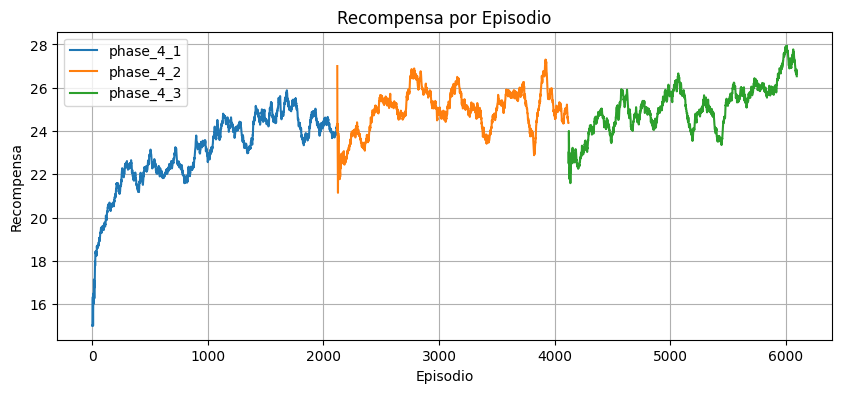

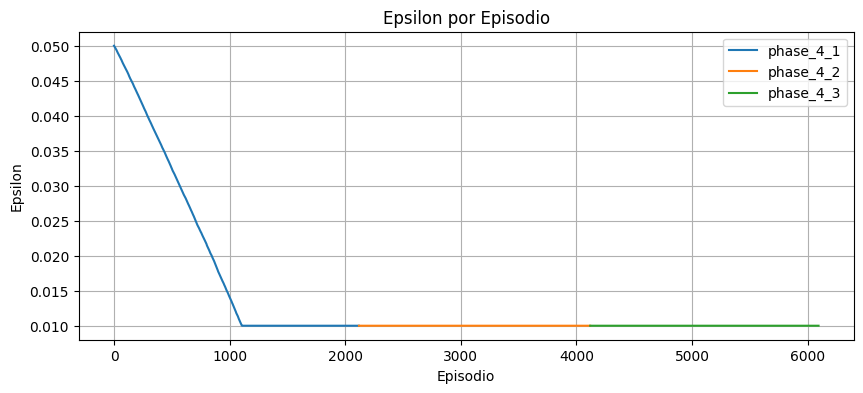

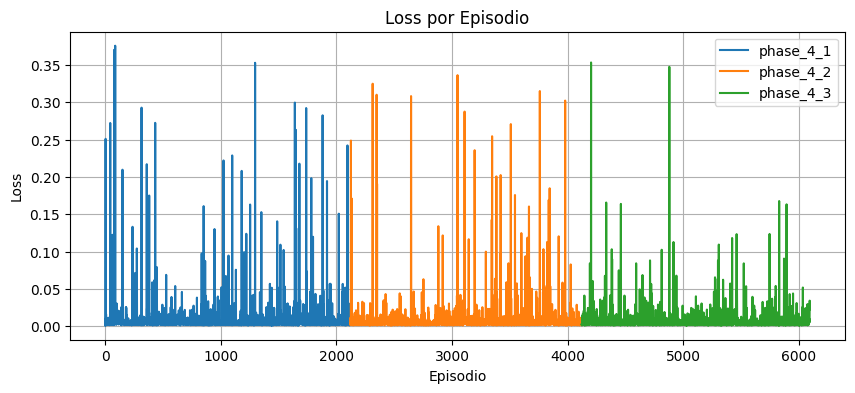

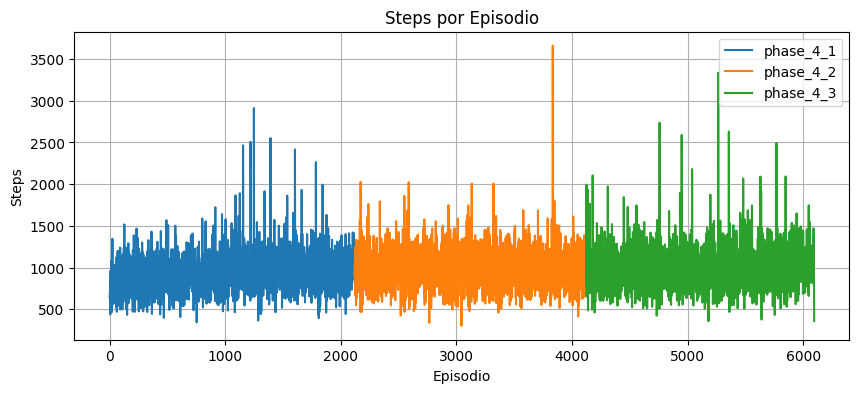

In [ ]:
graph_metrics_accumulated(metrics_path, phase_ids)

## Análisis final del proceso de entrenamiento


In [ ]:
phase_ids = [PHASE_INITIAL_ID, PHASE_2_ID, PHASE_3_ID, PHASE_3_2_ID, PHASE_4_1_ID, PHASE_4_2_ID, PHASE_4_3_ID]
metrics_path = getMetricFilePathList(False, phase_ids)
print(metrics_path)

['initial_run', 'phase_2', 'phase_3', 'phase_3_2', 'phase_4_1', 'phase_4_2', 'phase_4_3']
['metrics/ddqn/metrics_initial_run.npz', 'metrics/ddqn/metrics_phase_2.npz', 'metrics/ddqn/metrics_phase_3.npz', 'metrics/ddqn/metrics_phase_3_2.npz', 'metrics/ddqn/metrics_phase_4_1.npz', 'metrics/ddqn/metrics_phase_4_2.npz', 'metrics/ddqn/metrics_phase_4_3.npz']


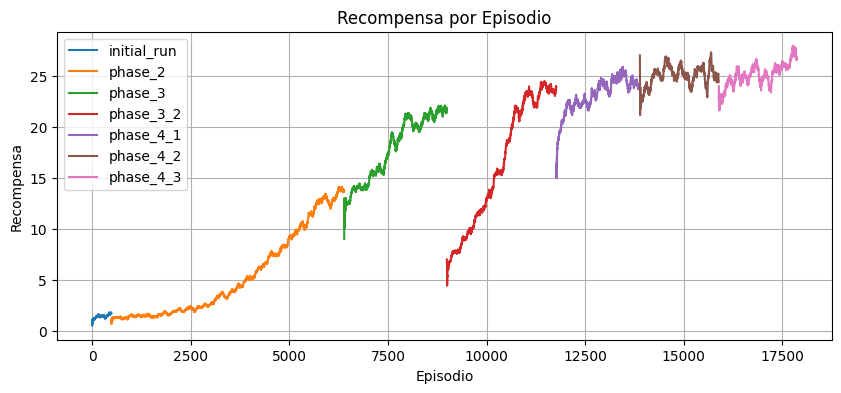

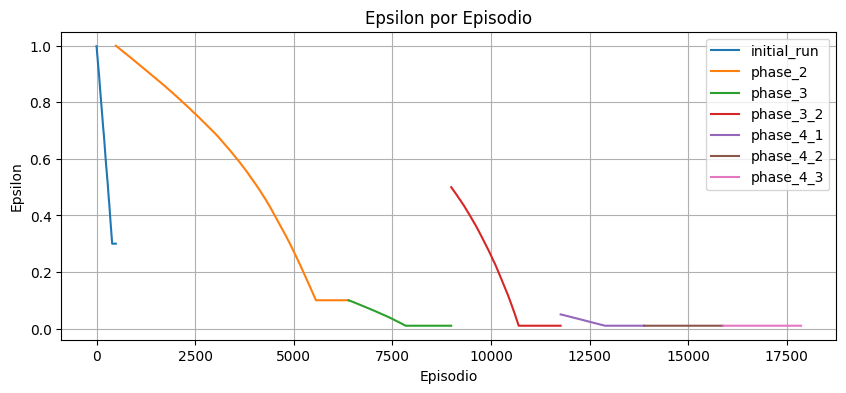

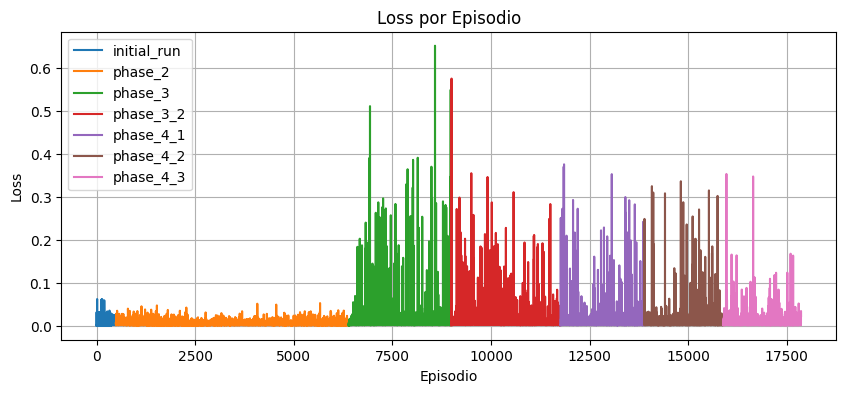

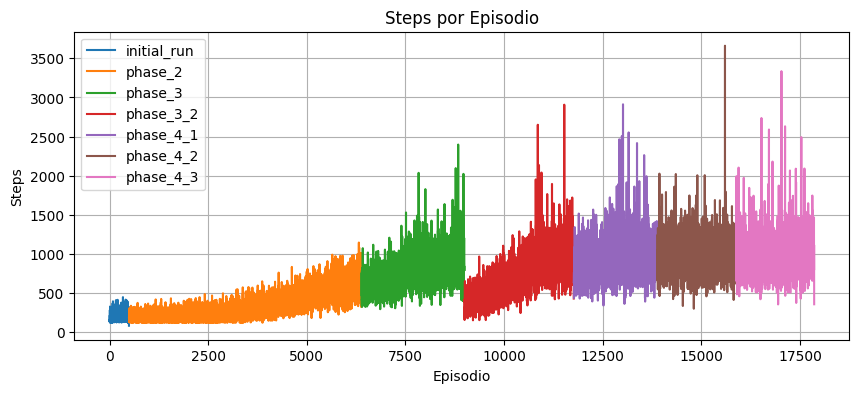

In [ ]:
graph_metrics_accumulated(metrics_path, phase_ids)

El agente **Double DQN** permitió mitigar el **sesgo de maximización** de Q-Learning usando una **red online** para seleccionar acciones y una **red target** para evaluarlas, logrando políticas más estables. **Gracias al bootstrapping**, se combinaron recompensas inmediatas con estimaciones futuras, equilibrando sesgo y varianza en cada actualización.

Las gráficas respaldan este comportamiento: la **recompensa promedio** muestra mejoras sostenidas a lo largo de las fases; la **curva de epsilon** refleja un buen balance exploración-explotación; y los **picos de loss y steps por episodio** indican que el agente aprende a sobrevivir más tiempo, consolidando mejores estrategias.

## Mejor resultado obtenido

`Recompensa = 67`

In [34]:
video_path = f'./videos/ddqn/validation/{PHASE_4_3_ID}/breakout-episode-0.mp4'
Video(video_path, embed=True, width=600)

# Experimentación Parte 1

## Prioritized Experience Replay: Acelerando el Aprendizaje con Muestreo Priorizado

### Motivación del Problema

Durante nuestros entrenamientos extensos con agentes **DQN** en el entorno **Breakout**, observamos que, a pesar de utilizar un **Replay Buffer tradicional**, el aprendizaje del agente mostraba períodos prolongados de estancamiento. Identificamos que, aunque se almacenaban miles de experiencias, no todas eran igual de útiles para seguir mejorando la política

Este comportamiento nos motivo a cuestionar si el esquema de muestreo uniforme era la mejor estrategia para maximizar el valor informativo de cada actualización de pesos, especialmente cuando se cuenta con buffers de gran capacidad.

### Fundamento Teórico

Basándonos en los principios de **aprendizaje y planificación indirecta** descritos por **Sutton y Barto**, y específicamente en la idea de **barrido priorizado** en **Programación Dinámica**, se sabe que no todos los estados o transiciones contribuyen de igual forma al aprendizaje. El barrido priorizado plantea que actualizar primero los estados con mayores cambios potenciales de valor mejora la eficiencia del entrenamiento.

En **Aprendizaje por Refuerzo**, esto se traduce en identificar transiciones con **alto error TD (Diferencia Temporal)**, ya que representan predicciones poco ajustadas al objetivo real y, por lo tanto, oportunidades de aprendizaje más ricas. El **Prioritized Experience Replay (PER)** traslada este principio a la práctica, modificando el Replay Buffer para muestrear de forma **no uniforme**, asignando mayores probabilidades a aquellas transiciones más “sorpresivas” o relevantes.

Para hacer esto viable en buffers de memoria grandes, se implementó la estructura **SumTree** ([ver referencia](https://www.sefidian.com/2022/11/09/sumtree-data-structure-for-prioritized-experience-replay-per-explained-with-python-code/)), un árbol binario que permite:
- Seleccionar experiencias con probabilidad proporcional a su prioridad en **O(log N)**.
- Actualizar eficientemente las prioridades a medida que los errores TD cambian tras cada batch de entrenamiento.

Esta estructura garantiza que el muestreo priorizado sea escalable y no suponga un cuello de botella computacional.


### Hipótesis de Investigación

Partiendo de este marco teórico, formulamos la hipótesis de que incorporar **Prioritized Experience Replay** permitirá:

- Acelerar la propagación de valores en la red neuronal.
- Reducir la cantidad de episodios con estancamiento en la recompensa promedio.
- Focalizar los recursos de cómputo en actualizar las transiciones más informativas.
- Lograr políticas más robustas y generalizables, al dedicar mayor atención a corregir predicciones con alto error.
- Mejorar la eficiencia del entrenamiento en comparación con el muestreo uniforme, especialmente en entornos con alta complejidad como **Breakout**.

Esta experimentación nos permitirá evaluar si la introducción de un esquema de **planificación indirecta** inspirado en el barrido priorizado es clave para superar los límites del Replay Buffer tradicional y maximizar la utilidad de cada paso de actualización


In [ ]:
def getReplayMemoryPhaseId(phase_id):
    return f"rm_{phase_id}"

In [ ]:
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_INITIAL)
PHASE_ID = getReplayMemoryPhaseId(PHASE_INITIAL_ID)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}")

PHASE_ID: initial_run, TOTAL_STEPS: 100000, EPISODES: 10000, EPSILON_INI: 1, EPSILON_MIN: 0.3, EPSILON_ANNEAL_STEPS: 80000


In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS, use_prioritized_replay=True)

Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 1
epsilon_f: 0.3
epsilon_anneal_steps: 80000
episode_block: 100
run_name: initial_run
Use prioritized memory: True


c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\OBL solo octa\obligatorio-taller-ia\videos\dqn\initial_run folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento initial_run, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 1, epsilon_f: 0.3, epsilon_anneal_steps: 80000, max_steps: 100000




c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   5%|▌         | 518/10000 [14:49<4:31:24,  1.72s/episode, reward=1.33, epsilon=0.3, steps=1e+5]   


Entrenamiento detenido: se alcanzaron 100001 pasos.



c:\Users\Octav\postgrado\taller ia\OBL solo octa\obligatorio-taller-ia\load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


In [ ]:
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}")

PHASE_ID: phase_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 1, EPSILON_MIN: 0.1, EPSILON_ANNEAL_STEPS: 1500000


In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS, use_prioritized_replay=True)

Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 1
epsilon_f: 0.1
epsilon_anneal_steps: 1500000
episode_block: 100
run_name: phase_2
Use prioritized memory: True


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_2, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 1, epsilon_f: 0.1, epsilon_anneal_steps: 1500000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   8%|▊         | 803/10000 [14:00<2:23:57,  1.06episode/s, reward=1.05, epsilon=0.91, steps=150116]


=== Recompensa actual: 1.05, Epsilon: 0.9099304, Total steps: 150116 ===


Entrenando:  16%|█▌        | 1581/10000 [28:06<3:04:24,  1.31s/episode, reward=1.64, epsilon=0.82, steps=3e+5]


=== Recompensa actual: 1.64, Epsilon: 0.8199466, Total steps: 300089 ===


Entrenando:  23%|██▎       | 2332/10000 [42:02<2:27:54,  1.16s/episode, reward=2.12, epsilon=0.73, steps=450136]


=== Recompensa actual: 2.12, Epsilon: 0.7299184, Total steps: 450136 ===


Entrenando:  30%|███       | 3021/10000 [55:52<2:32:51,  1.31s/episode, reward=2.26, epsilon=0.64, steps=6e+5]


=== Recompensa actual: 2.26, Epsilon: 0.639937, Total steps: 600105 ===


Entrenando:  37%|███▋      | 3695/10000 [1:10:02<2:12:36,  1.26s/episode, reward=2.53, epsilon=0.55, steps=750084]


=== Recompensa actual: 2.53, Epsilon: 0.5499496, Total steps: 750084 ===


Entrenando:  43%|████▎     | 4307/10000 [1:24:37<2:31:56,  1.60s/episode, reward=2.79, epsilon=0.46, steps=9e+5]


=== Recompensa actual: 2.79, Epsilon: 0.4599622, Total steps: 900063 ===


Entrenando:  49%|████▉     | 4936/10000 [1:38:47<2:46:33,  1.97s/episode, reward=2.98, epsilon=0.37, steps=1050047]


=== Recompensa actual: 2.98, Epsilon: 0.36997179999999996, Total steps: 1050047 ===


Entrenando:  54%|█████▍    | 5444/10000 [1:52:51<1:47:30,  1.42s/episode, reward=4.74, epsilon=0.28, steps=1.2e+6]


=== Recompensa actual: 4.74, Epsilon: 0.27993579999999996, Total steps: 1200107 ===


Entrenando:  59%|█████▉    | 5903/10000 [2:07:16<1:50:47,  1.62s/episode, reward=5.39, epsilon=0.19, steps=1350240]


=== Recompensa actual: 5.39, Epsilon: 0.18985600000000002, Total steps: 1350240 ===


Entrenando:  63%|██████▎   | 6286/10000 [2:21:55<2:06:33,  2.04s/episode, reward=7.5, epsilon=0.1, steps=1.5e+6]


=== Recompensa actual: 7.5, Epsilon: 0.1, Total steps: 1500126 ===


Entrenando:  66%|██████▌   | 6621/10000 [2:36:22<2:27:28,  2.62s/episode, reward=8.78, epsilon=0.1, steps=1650376]


=== Recompensa actual: 8.78, Epsilon: 0.1, Total steps: 1650376 ===


Entrenando:  69%|██████▉   | 6927/10000 [2:51:02<3:01:20,  3.54s/episode, reward=9.93, epsilon=0.1, steps=1.8e+6]


=== Recompensa actual: 9.93, Epsilon: 0.1, Total steps: 1800595 ===


Entrenando:  72%|███████▏  | 7219/10000 [3:05:34<2:33:05,  3.30s/episode, reward=10.5, epsilon=0.1, steps=1950376]


=== Recompensa actual: 10.54, Epsilon: 0.1, Total steps: 1950376 ===


Entrenando:  73%|███████▎  | 7310/10000 [3:10:23<1:10:03,  1.56s/episode, reward=11.1, epsilon=0.1, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_2_ID)
print(f"net a cargar con PHASE_ID: {PHASE_2_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_2
PHASE_ID: phase_3, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.1, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_2.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(
    PHASE_ID,
    reference_states,
    loadPath=LOAD_NET_PATH,
    total_steps = TOTAL_STEPS,
    episodes = EPISODES,
    epsilon_i = EPSILON_INI,
    epsilon_f = EPSILON_MIN,
    epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
    use_prioritized_replay=True
  )

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_2.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.1
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
episode_block: 100
run_name: phase_3
Use prioritized memory: True


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_3, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.1, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   3%|▎         | 278/10000 [15:14<9:23:36,  3.48s/episode, reward=11.6, epsilon=0.0865, steps=150077]


=== Recompensa actual: 11.58, Epsilon: 0.08649307, Total steps: 150077 ===


Entrenando:   5%|▌         | 546/10000 [29:41<8:28:52,  3.23s/episode, reward=11.7, epsilon=0.073, steps=3e+5]


=== Recompensa actual: 11.71, Epsilon: 0.07295698, Total steps: 300478 ===


Entrenando:   8%|▊         | 798/10000 [44:33<8:45:54,  3.43s/episode, reward=12.2, epsilon=0.0595, steps=450507]


=== Recompensa actual: 12.22, Epsilon: 0.05945437, Total steps: 450507 ===


Entrenando:  11%|█         | 1056/10000 [59:24<9:41:56,  3.90s/episode, reward=13, epsilon=0.046, steps=600512]


=== Recompensa actual: 13.01, Epsilon: 0.045953919999999995, Total steps: 600512 ===


Entrenando:  13%|█▎        | 1295/10000 [1:14:19<7:51:29,  3.25s/episode, reward=14.4, epsilon=0.0325, steps=750260]


=== Recompensa actual: 14.44, Epsilon: 0.032476599999999994, Total steps: 750260 ===


Entrenando:  15%|█▌        | 1522/10000 [1:29:13<9:26:15,  4.01s/episode, reward=15, epsilon=0.019, steps=9e+5]


=== Recompensa actual: 15.04, Epsilon: 0.018970749999999995, Total steps: 900325 ===


Entrenando:  17%|█▋        | 1745/10000 [1:44:07<8:45:22,  3.82s/episode, reward=14.3, epsilon=0.01, steps=1050096]


=== Recompensa actual: 14.27, Epsilon: 0.01, Total steps: 1050096 ===


Entrenando:  20%|█▉        | 1961/10000 [1:59:07<11:17:13,  5.05s/episode, reward=16, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 16.0, Epsilon: 0.01, Total steps: 1200517 ===


Entrenando:  22%|██▏       | 2166/10000 [2:13:20<7:25:36,  3.41s/episode, reward=17.2, epsilon=0.01, steps=1350099]


=== Recompensa actual: 17.19, Epsilon: 0.01, Total steps: 1350099 ===


Entrenando:  24%|██▍       | 2375/10000 [2:27:48<9:08:47,  4.32s/episode, reward=15.9, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 15.86, Epsilon: 0.01, Total steps: 1500117 ===


Entrenando:  26%|██▌       | 2579/10000 [2:42:19<8:58:52,  4.36s/episode, reward=16.7, epsilon=0.01, steps=1650109]


=== Recompensa actual: 16.67, Epsilon: 0.01, Total steps: 1650109 ===


Entrenando:  28%|██▊       | 2781/10000 [2:57:30<9:12:48,  4.59s/episode, reward=17.1, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 17.09, Epsilon: 0.01, Total steps: 1800557 ===


Entrenando:  30%|██▉       | 2987/10000 [3:12:07<10:00:19,  5.14s/episode, reward=16.9, epsilon=0.01, steps=1950128]


=== Recompensa actual: 16.89, Epsilon: 0.01, Total steps: 1950128 ===


Entrenando:  31%|███       | 3054/10000 [3:17:09<7:28:25,  3.87s/episode, reward=17.4, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_3_ID)
print(f"net a cargar con PHASE_ID: {PHASE_3_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_1)
PHASE_ID = f"rm_{PHASE_ID}"
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_3
PHASE_ID: rm_phase_4_1, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.05, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_3.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(
    PHASE_ID,
    reference_states,
    loadPath=LOAD_NET_PATH,
    total_steps = TOTAL_STEPS,
    episodes = EPISODES,
    epsilon_i = EPSILON_INI,
    epsilon_f = EPSILON_MIN,
    epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
    use_prioritized_replay=True
  )

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_3.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.05
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
episode_block: 100
run_name: rm_phase_4_1
Use prioritized memory: True


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento rm_phase_4_1, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.05, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   2%|▏         | 222/10000 [14:28<9:28:59,  3.49s/episode, reward=15.3, epsilon=0.044, steps=150325]


=== Recompensa actual: 15.33, Epsilon: 0.043987000000000005, Total steps: 150325 ===


Entrenando:   4%|▍         | 429/10000 [28:35<12:43:37,  4.79s/episode, reward=17.1, epsilon=0.038, steps=3e+5]


=== Recompensa actual: 17.12, Epsilon: 0.037993280000000004, Total steps: 300168 ===


Entrenando:   6%|▋         | 634/10000 [42:48<8:55:31,  3.43s/episode, reward=17, epsilon=0.032, steps=450208]


=== Recompensa actual: 16.98, Epsilon: 0.03199168, Total steps: 450208 ===


Entrenando:   8%|▊         | 838/10000 [56:52<12:37:05,  4.96s/episode, reward=16.7, epsilon=0.026, steps=6e+5]


=== Recompensa actual: 16.69, Epsilon: 0.025980640000000003, Total steps: 600484 ===


Entrenando:  10%|█         | 1031/10000 [1:11:03<10:45:12,  4.32s/episode, reward=18.2, epsilon=0.02, steps=750723]


=== Recompensa actual: 18.25, Epsilon: 0.019971080000000002, Total steps: 750723 ===


Entrenando:  12%|█▏        | 1221/10000 [1:25:26<10:59:20,  4.51s/episode, reward=18.9, epsilon=0.014, steps=9e+5]


=== Recompensa actual: 18.92, Epsilon: 0.013994239999999998, Total steps: 900144 ===


Entrenando:  14%|█▍        | 1411/10000 [1:40:00<11:22:33,  4.77s/episode, reward=18.2, epsilon=0.01, steps=1050287]


=== Recompensa actual: 18.19, Epsilon: 0.01, Total steps: 1050287 ===


Entrenando:  16%|█▌        | 1597/10000 [1:54:18<11:07:00,  4.76s/episode, reward=18.8, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 18.8, Epsilon: 0.01, Total steps: 1200721 ===


Entrenando:  18%|█▊        | 1782/10000 [2:08:25<8:59:11,  3.94s/episode, reward=19.1, epsilon=0.01, steps=1350315]


=== Recompensa actual: 19.14, Epsilon: 0.01, Total steps: 1350315 ===


Entrenando:  20%|█▉        | 1971/10000 [2:22:47<13:30:56,  6.06s/episode, reward=18.9, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 18.89, Epsilon: 0.01, Total steps: 1500400 ===


Entrenando:  22%|██▏       | 2158/10000 [2:37:03<11:55:57,  5.48s/episode, reward=19.6, epsilon=0.01, steps=1650048]


=== Recompensa actual: 19.59, Epsilon: 0.01, Total steps: 1650048 ===


Entrenando:  23%|██▎       | 2346/10000 [2:51:14<9:25:43,  4.43s/episode, reward=18.3, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 18.27, Epsilon: 0.01, Total steps: 1800254 ===


Entrenando:  25%|██▌       | 2533/10000 [3:05:28<9:48:23,  4.73s/episode, reward=19.2, epsilon=0.01, steps=1950193] 


=== Recompensa actual: 19.25, Epsilon: 0.01, Total steps: 1950193 ===


Entrenando:  26%|██▌       | 2600/10000 [3:10:11<9:01:17,  4.39s/episode, reward=18.8, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


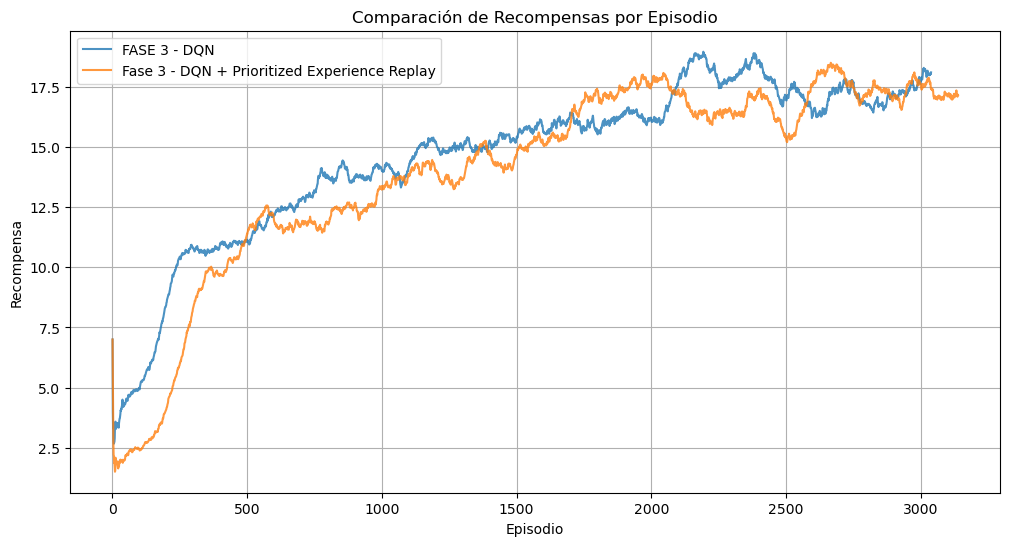

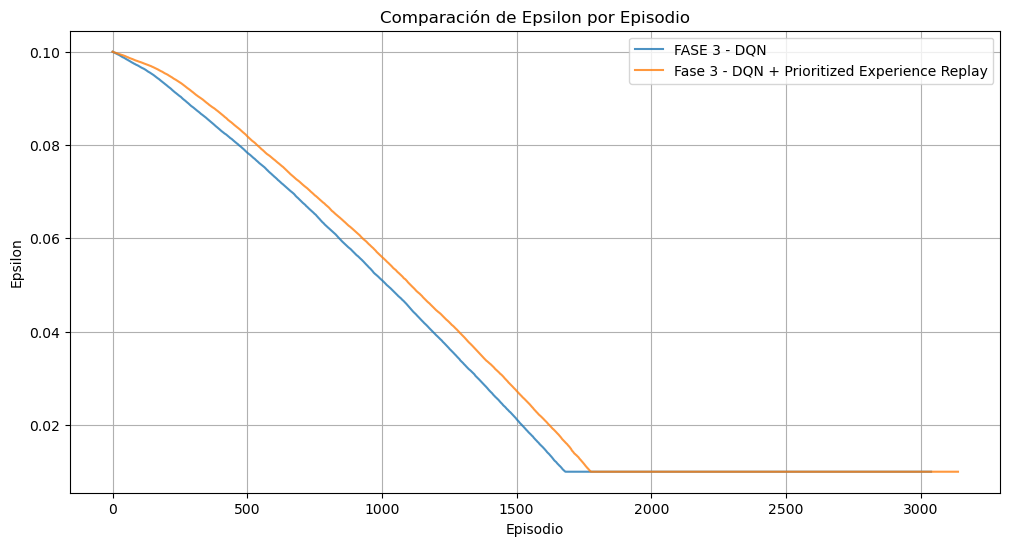

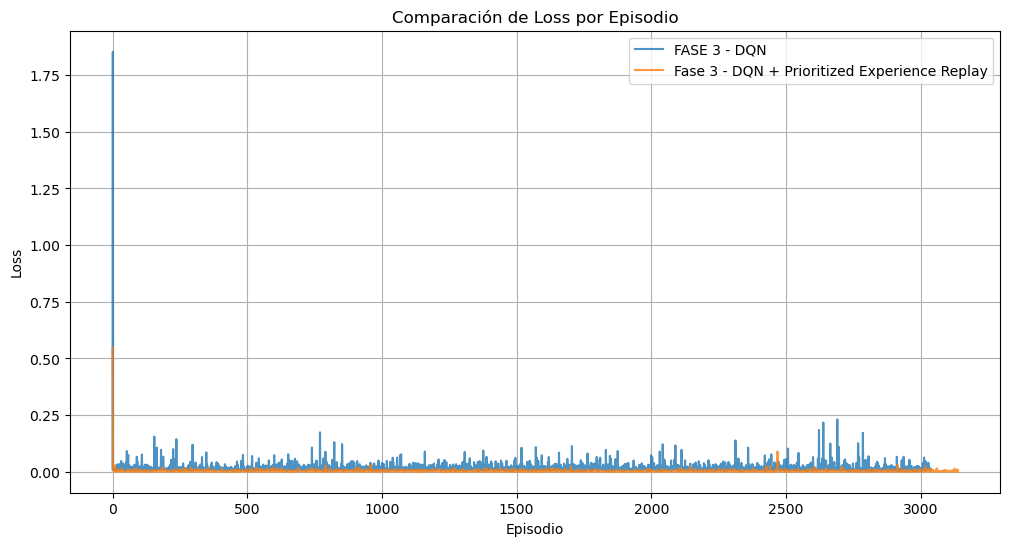


=== RESUMEN ESTADÍSTICO ===

FASE 3 - DQN:
  Recompensa promedio: 14.59 ± 3.35
  Recompensa máxima: 18.97
  Recompensa mínima: 2.67
  Loss promedio: 0.0171 ± 0.0373
  Steps promedio: 658.1 ± 185.3
  Epsilon final: 0.0100
  Episodios totales: 3039
  Episodios con recompensas válidas: 3038
  Porcentaje de datos válidos: 100.0%

Fase 3 - DQN + Prioritized Experience Replay:
  Recompensa promedio: 13.98 ± 4.09
  Recompensa máxima: 18.51
  Recompensa mínima: 1.50
  Loss promedio: 0.0038 ± 0.0103
  Steps promedio: 637.1 ± 199.0
  Epsilon final: 0.0100
  Episodios totales: 3139
  Episodios con recompensas válidas: 3138
  Porcentaje de datos válidos: 100.0%


In [37]:
metrics_paths = [getMetricFilePath(True, PHASE_3_ID), getMetricFilePath(True, f"rm_phase_3")]
compare_metrics(metrics_paths, labels=["FASE 3 - DQN", "Fase 3 - DQN + Prioritized Experience Replay"], show_rewards=True, show_losses=True, show_steps=False, show_actions=False, show_epsilons=True)

Al evaluar un agente **DQN** con **memoria uniformemente sampleada** frente a uno con **memoria priorizada**, para una misma fase de entrenamiento y con los mismos pesos iniciales. No observamos mejoras considerables en el rendimiento. Entendemos que esta falta de mejora significativa puede deberse a la naturaleza del **error TD** en el entorno **Breakout**. En este entorno particular, el error TD tiende a ser bastante uniforme entre las diferentes transiciones. Como consecuencia, el diferencial que ofrece la memoria priorizada (que se basa en seleccionar transiciones con mayores errores TD) no tendría un impacto significativo. Esto se debe a que las elecciones de memoria no se diferenciarán con facilidad basándose en la magnitud de su TD error, dado que la mayoría de ellos son similares. Por lo tanto, obtenemos resultados similares al utilizar una memoria priorizada en comparación con una memoria aleatoria (uniformemente sampleada) en este entorno y bajo estas condiciones específicas.

# Experimentación Parte 2

## Epsilon Decay Adaptativo: Una Solución al Estancamiento de Políticas en DQN

### Motivación del Problema
Durante nuestros entrenamientos extensos con agentes DQN en el entorno Breakout, observamos un patrón recurrente: las políticas se estancaban significativamente después de períodos de mejora inicial, específicamente durante las fases de entrenamiento donde se comienza a priorizar la explotación; identificamos que:

**1. Períodos prolongados sin mejora:** Los agentes experimentaban episodios consecutivos (20+ episodios) sin incrementos significativos en la recompensa promedio.

**2. Pérdida de oportunidades de mejora:** Una vez que el agente encontraba una estrategia sub-óptima pero funcional, tendía a explotarla exclusivamente, ignorando potenciales mejoras.

También, una razón significativa que nos llevo a evaluar lo mencionado es que durante la planeación y experimentación inicial, enfrentamos dificultades significativas para definir los valores óptimos de epsilon_min y epsilon_max, donde cada ajuste requería entrenamientos completos para evaluar su efectividad y los valores que funcionaban bien en etapas tempranas del entrenamiento no eran óptimos para etapas avanzadas.

Estos desafíos nos llevaron a cuestionar el enfoque estático y buscar una solución más dinámica y auto-adaptativa.

### Fundamento Teórico
El problema de exploración vs. explotación es fundamental en Reinforcement Learning. El esquema epsilon-greedy tradicional con decay lineal presenta limitaciones inherentes:

**- Rigidez temporal:** El epsilon decrece independientemente del progreso del agente
**- Falta de adaptabilidad:** No responde a períodos de estancamiento o mejora
**- Exploración insuficiente en etapas avanzadas:** Una vez que epsilon alcanza su valor mínimo, el agente explora muy poco
**- Dependencia excesiva de hiperparámetros manuales:** Requiere tuning extensivo para cada entorno y configuración

### Hipótesis de Investigación
Esperamos que el epsilon adaptativo resulte en:

- Mayor recompensa final comparado con el esquema lineal tradicional
- Menos episodios de estancamiento durante el entrenamiento
- Políticas más robustas que generalicen mejor a diferentes situaciones del juego
- Convergencia más rápida hacia estrategias óptimas
- Menor dependencia de hiperparámetros manuales para el tuning de exploración

Esta experimentación nos permitirá evaluar si la adaptabilidad en la exploración es clave para superar las limitaciones observadas en el agente DQN, y si un enfoque más dinámico puede resolver los desafíos de configuración que enfrentamos inicialmente.

## Fase 3:

La hipótesis se aplica en la Fase 3 del entrenamiento para evaluar el rendimiento del agente en una etapa donde se prioriza la explotación. Para ello, se cargan los pesos obtenidos en la Fase 2 y se reutilizan exactamente los mismos parámetros de entrenamiento.

In [ ]:
PHASE_NAME = PHASE_2["id"]
LOAD_NET_PATH = getGenericDataFilePath(True, f"{PHASE_NAME}")

PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

PHASE_ID: phase_3, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.1, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_2.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(
  f"{PHASE_ID}_adaptative_e",
  reference_states,
  loadPath=LOAD_NET_PATH,
  total_steps = TOTAL_STEPS,
  episodes = EPISODES,
  epsilon_i = EPSILON_INI,
  epsilon_f = EPSILON_MIN,
  epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
  gamma=GAMMA,
  adaptive_epsilon=True
)

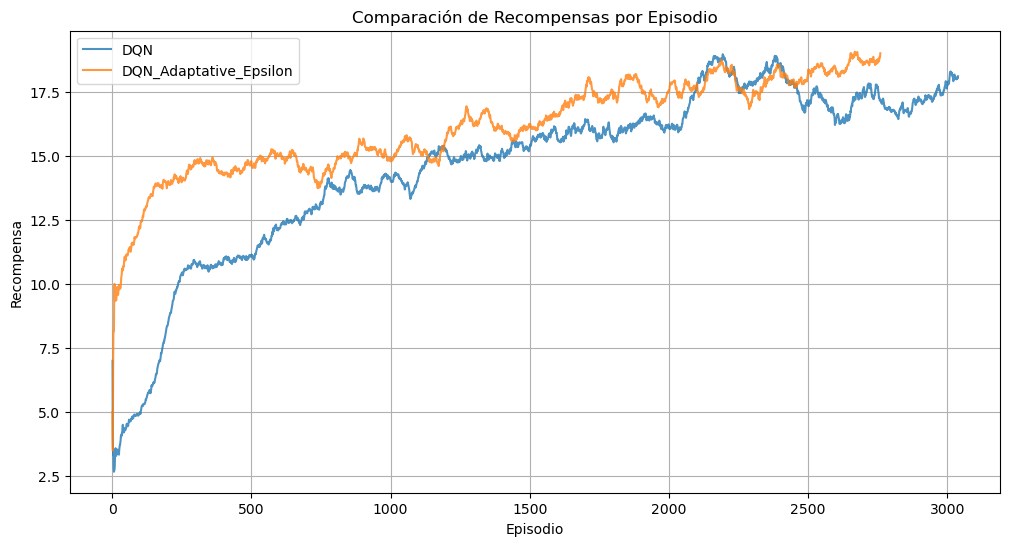

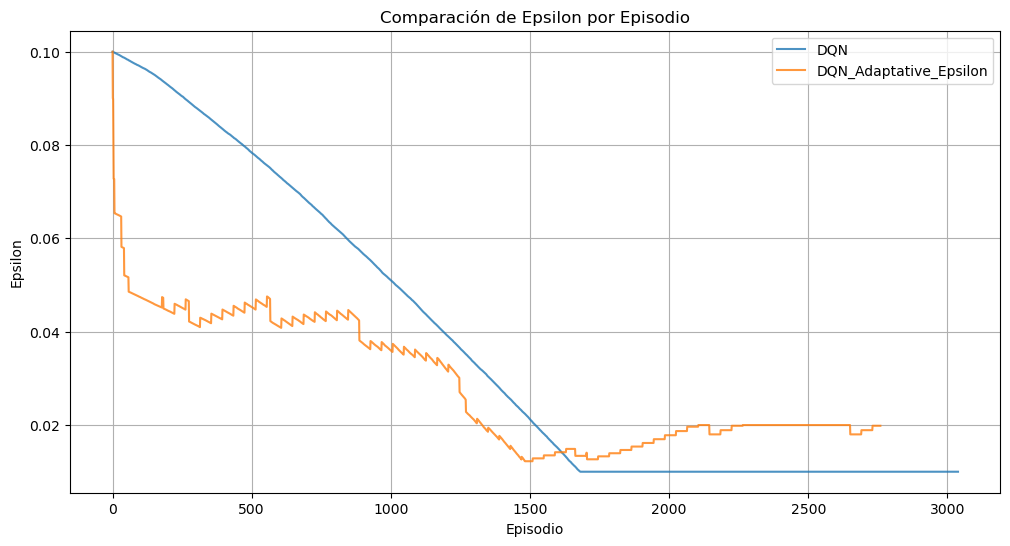

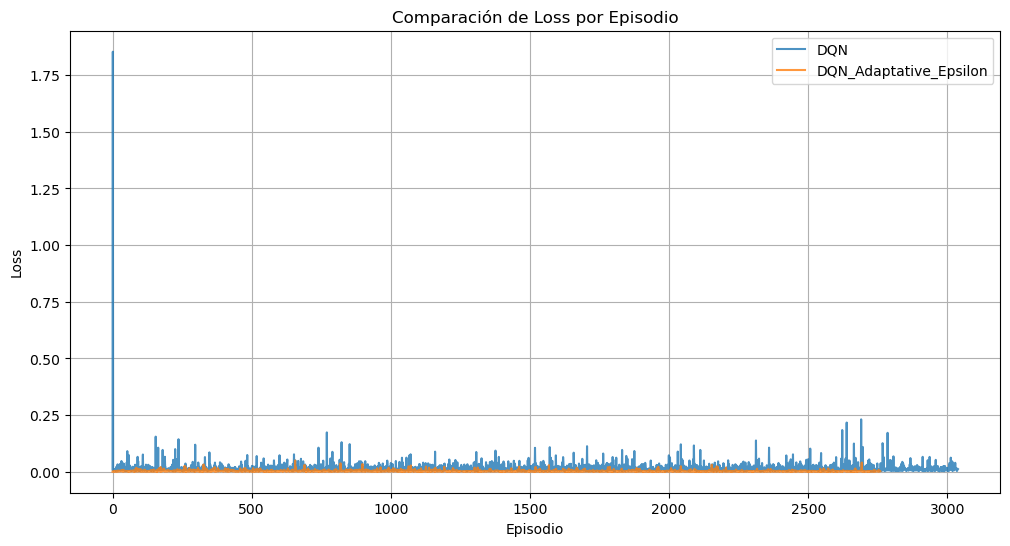


=== RESUMEN ESTADÍSTICO ===

DQN:
  Recompensa promedio: 14.59 ± 3.35
  Recompensa máxima: 18.97
  Recompensa mínima: 2.67
  Loss promedio: 0.0171 ± 0.0373
  Steps promedio: 658.1 ± 185.3
  Epsilon final: 0.0100
  Episodios totales: 3039
  Episodios con recompensas válidas: 3038
  Porcentaje de datos válidos: 100.0%

DQN_Adaptative_Epsilon:
  Recompensa promedio: 16.10 ± 1.88
  Recompensa máxima: 19.07
  Recompensa mínima: 3.50
  Loss promedio: 0.0033 ± 0.0037
  Steps promedio: 724.6 ± 195.3
  Epsilon final: 0.0198
  Episodios totales: 2760
  Episodios con recompensas válidas: 2759
  Porcentaje de datos válidos: 100.0%


In [ ]:
metrics_paths = [getMetricFilePath(True, PHASE_3_ID), getMetricFilePath(True, f"{PHASE_3_ID}_adaptative_e")]
compare_metrics(metrics_paths, labels=["DQN", "DQN_Adaptative_Epsilon"], show_rewards=True, show_losses=True, show_steps=False, show_actions=False, show_epsilons=True)

### Conclusión de resultados, Fase 3

**1. Gráfica de Recompensas:**

El agente con epsilon adaptativo alcanzó una recompensa `promedio superior (16.10 vs. 14.59)` y una `mayor estabilidad (menor desviación estándar)`. Aunque la recompensa máxima fue similar (19.07 vs. 18.97), la curva adaptativa mostró un ascenso más rápido y sostenido desde el inicio, lo que indica mejor aprovechamiento de la exploración inicial.

**2. Gráfica de Epsilon:**

El esquema adaptativo ajustó dinámicamente la exploración según el progreso, evitando caer prematuramente en explotación excesiva. El DQN estático alcanzó epsilon mínimo rápidamente, mientras que el adaptativo mantuvo un equilibrio y re introdujo exploración cuando fue necesario.

**3. Gráfica de Loss:**

El DQN adaptativo presentó `menor pérdida` promedio y `menor varianza`, lo que sugiere `actualizaciones más estables` y valores `Q menos erráticos`.

#### Conclusiones generales

Para la Fase 3, el epsilon adaptativo permitió una mejora en rendimiento, redujo el estancamiento, y promovió una exploración más inteligente sin comprometer la estabilidad. Si bien las diferencias no son drásticamente altas en términos de recompensa máxima, sí lo son en consistencia, estabilidad y eficiencia de aprendizaje. Esto sugiere que incorporar adaptabilidad en la explotación es una estrategia robusta y generalizable para superar limitaciones del DQN tradicional.

## Fase 3_2:

Como se explicó anteriormente, siguiendo el problema que durante el entrenamiento original en la fase 3 el agente se estancaba, motivo se introdujo una fase 3_2 con mayor explotación, decidimos también aplicar el epsilon adaptativo para esta fase específicamente y evaluar si efectivamente el agente logra aprovechar esta exploración extra, cosa que para el entrenamiento original no mejoro significativamente

In [35]:
PHASE_NAME = f"{PHASE_3_ID}_adaptative_e"
LOAD_NET_PATH = getGenericDataFilePath(True, f"{PHASE_NAME}")

PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

PHASE_ID: phase_3_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.5, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_3_adaptative_e.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(
  f"{PHASE_ID}_adaptative_e",
  reference_states,
  loadPath=LOAD_NET_PATH,
  total_steps = TOTAL_STEPS,
  episodes = EPISODES,
  epsilon_i = EPSILON_INI,
  epsilon_f = EPSILON_MIN,
  epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
  gamma=GAMMA,
  adaptive_epsilon=True
)

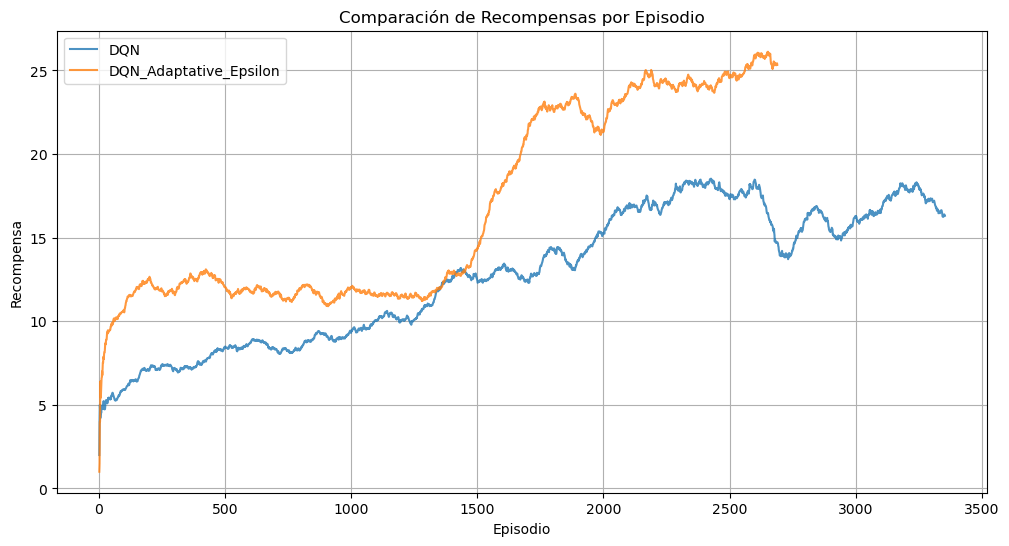

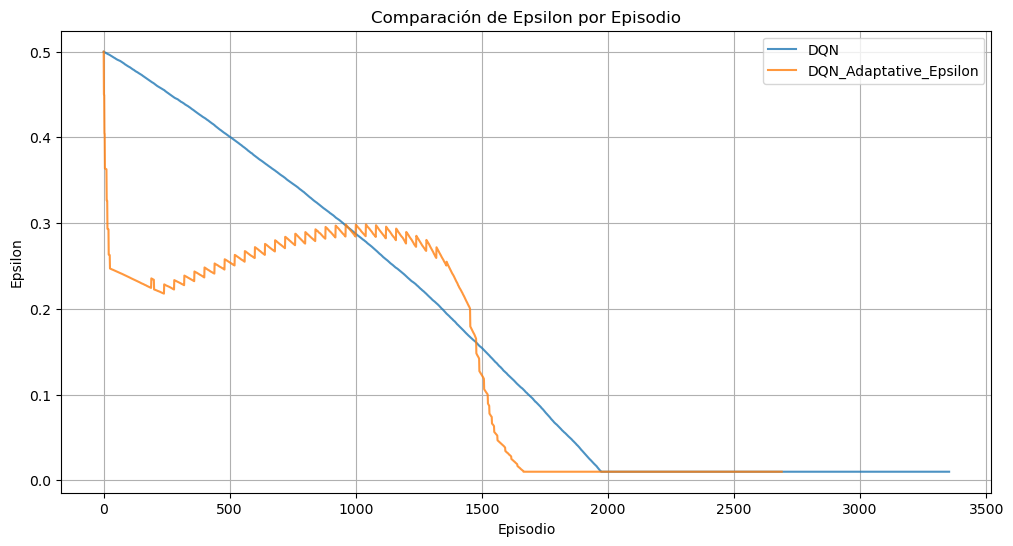

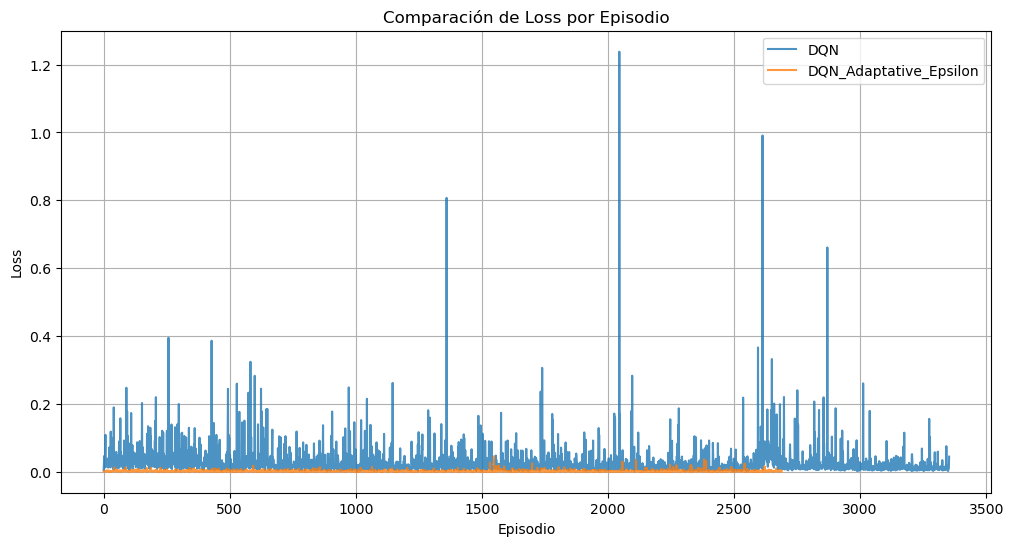


=== RESUMEN ESTADÍSTICO ===

DQN:
  Recompensa promedio: 12.75 ± 3.98
  Recompensa máxima: 18.53
  Recompensa mínima: 2.00
  Loss promedio: 0.0275 ± 0.0469
  Steps promedio: 596.3 ± 199.9
  Epsilon final: 0.0100
  Episodios totales: 3354
  Episodios con recompensas válidas: 3353
  Porcentaje de datos válidos: 100.0%

DQN_Adaptative_Epsilon:
  Recompensa promedio: 16.65 ± 5.79
  Recompensa máxima: 26.12
  Recompensa mínima: 1.00
  Loss promedio: 0.0025 ± 0.0027
  Steps promedio: 743.5 ± 288.7
  Epsilon final: 0.0100
  Episodios totales: 2690
  Episodios con recompensas válidas: 2689
  Porcentaje de datos válidos: 100.0%


In [ ]:
metrics_paths = [getMetricFilePath(True, PHASE_3_2_ID), getMetricFilePath(True, f"{PHASE_3_2_ID}_adaptative_e")]
compare_metrics(metrics_paths, labels=["DQN", "DQN_Adaptative_Epsilon"], show_rewards=True, show_losses=True, show_steps=False, show_actions=False, show_epsilons=True)

### Comparamos resultados con Double DQN (DQN_e_adaptativo vs DDQN)

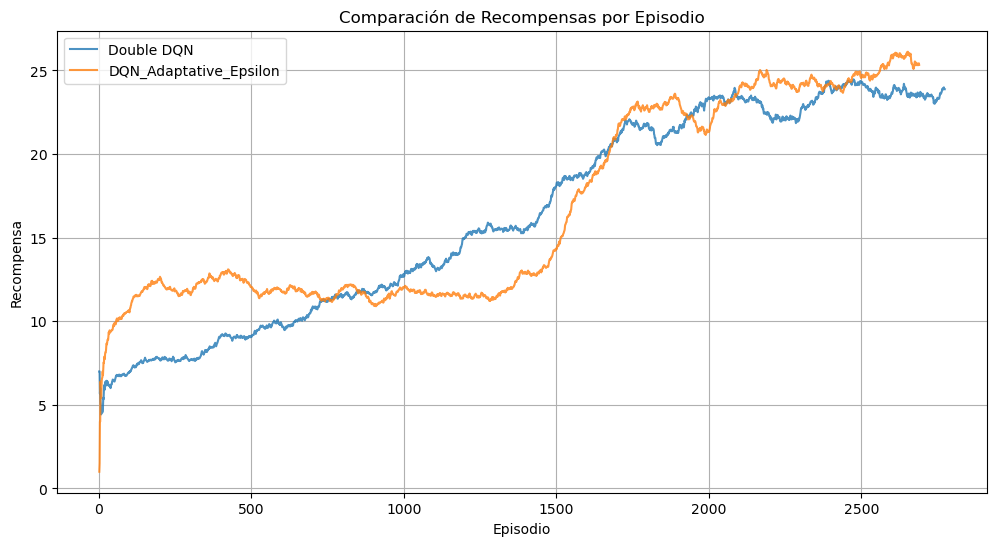

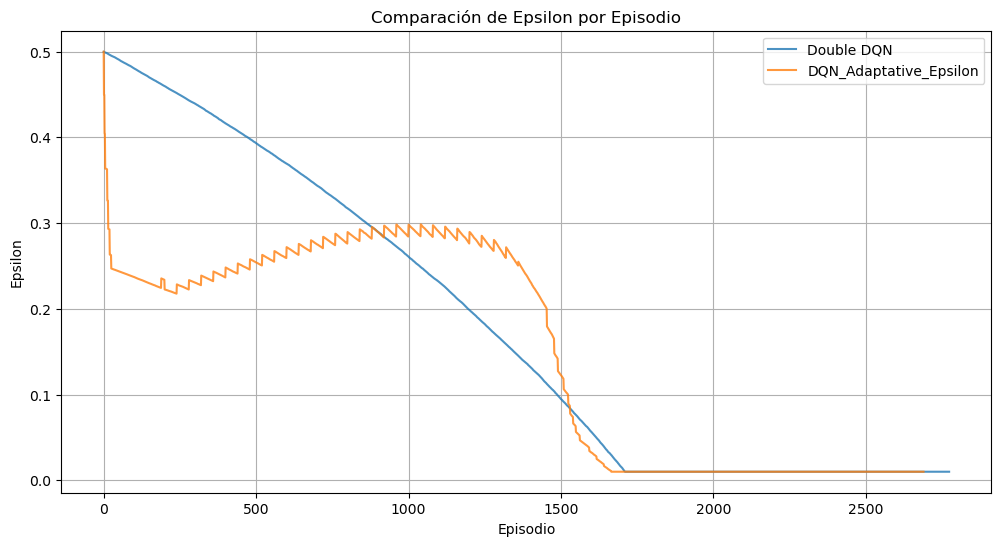

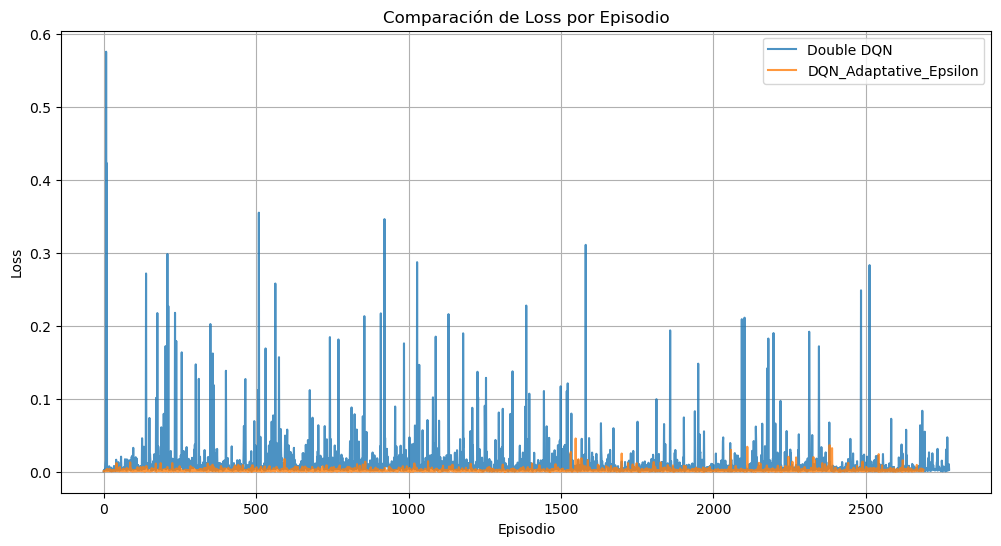


=== RESUMEN ESTADÍSTICO ===

Double DQN:
  Recompensa promedio: 16.32 ± 6.10
  Recompensa máxima: 24.47
  Recompensa mínima: 4.43
  Loss promedio: 0.0133 ± 0.0317
  Steps promedio: 721.0 ± 277.3
  Epsilon final: 0.0100
  Episodios totales: 2774
  Episodios con recompensas válidas: 2773
  Porcentaje de datos válidos: 100.0%

DQN_Adaptative_Epsilon:
  Recompensa promedio: 16.65 ± 5.79
  Recompensa máxima: 26.12
  Recompensa mínima: 1.00
  Loss promedio: 0.0025 ± 0.0027
  Steps promedio: 743.5 ± 288.7
  Epsilon final: 0.0100
  Episodios totales: 2690
  Episodios con recompensas válidas: 2689
  Porcentaje de datos válidos: 100.0%


In [23]:
metrics_paths = [getMetricFilePath(False, PHASE_3_2_ID), getMetricFilePath(True, f"{PHASE_3_2_ID}_adaptative_e")]
compare_metrics(metrics_paths, labels=["Double DQN", "DQN_Adaptative_Epsilon"], show_rewards=True, show_losses=True, show_steps=False, show_actions=False, show_epsilons=True)

### Conclusión de Resultados - Fase 3_2

Los resultados obtenidos `respaldan firmemente nuestra hipótesis inicial`. La incorporación de un esquema de epsilon adaptativo permitió al agente alcanzar `mayores recompensas finales`, ejecutando la **misma cantidad de pasos** pero en `menos episodios` que el agente con decaimiento lineal. Además, el entrenamiento evidenció una convergencia más rápida, con menor pérdida y menor variabilidad, señalando un proceso de aprendizaje más estable. El agente también mostró una política más robusta y efectiva, igualando el rendimiento alcanzado por el agente DDQN, el cual si bien su curva de recompensa es mas lineal y progresiva, para esta misma fase obtuvo un promedio de 16.32 y una maxima de 24.47, mientras que el DQN con epsilon adaptativo obtuvo una recompensa promedio de 16.65 y una máxima de 26.12, pero sin requerir ajustes manuales complejos de hiperparámetros. Esto sugiere que la exploración dinámica es una herramienta valiosa para evitar el estancamiento y mejorar significativamente la eficiencia y calidad del aprendizaje en DQN.

# Comparaciones, Resultados, Comentarios...


In [38]:
phase_ids = [PHASE_INITIAL_ID, PHASE_2_ID, PHASE_3_ID, PHASE_3_2_ID, PHASE_4_1_ID, PHASE_4_2_ID, PHASE_4_3_ID]
# Se obtiene la ruta de los archivos de métricas de las fases para el agente DQN
dqn_metrics_path = getMetricFilePathList(True, phase_ids)

# Se obtiene la ruta de los archivos de métricas de las fases para el agente DDQN
ddqn_metrics_path = getMetricFilePathList(False, phase_ids)

['initial_run', 'phase_2', 'phase_3', 'phase_3_2', 'phase_4_1', 'phase_4_2', 'phase_4_3']
['initial_run', 'phase_2', 'phase_3', 'phase_3_2', 'phase_4_1', 'phase_4_2', 'phase_4_3']


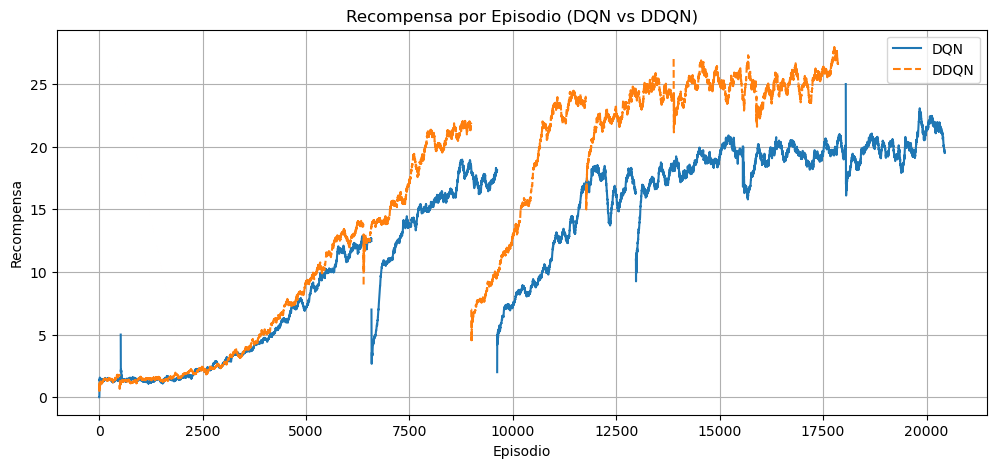

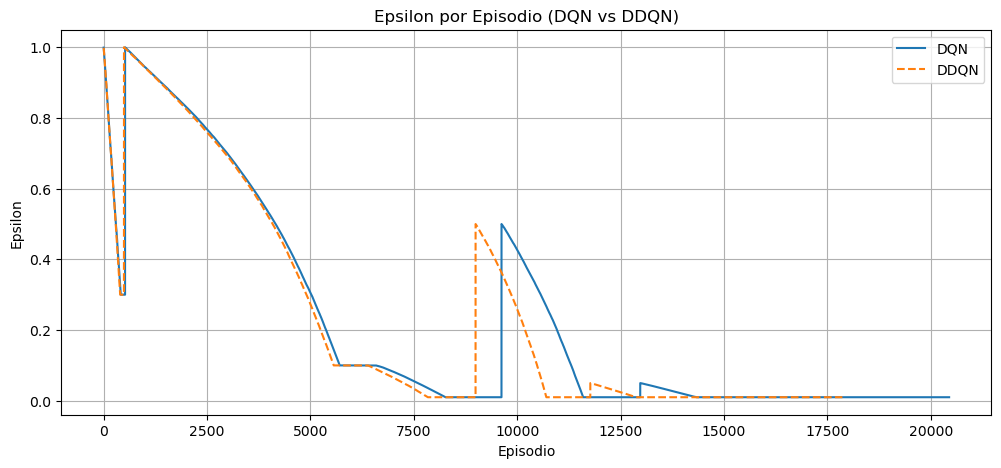

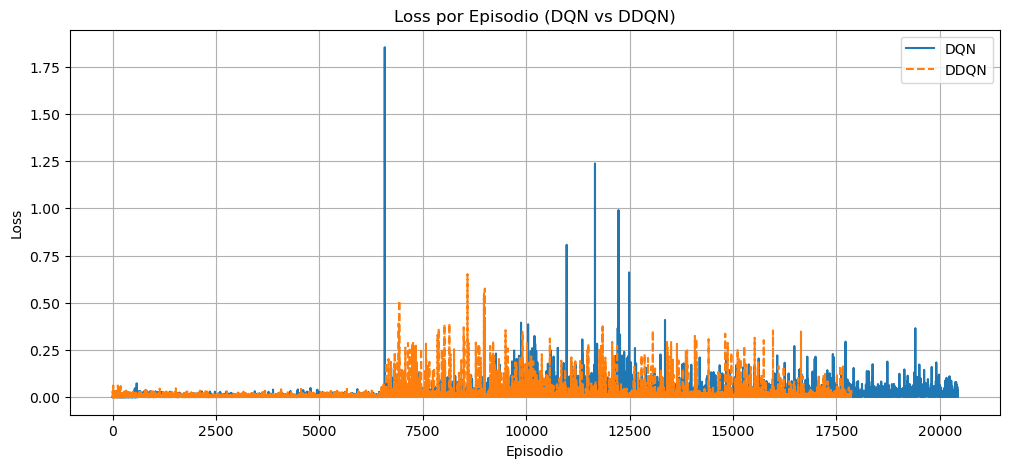

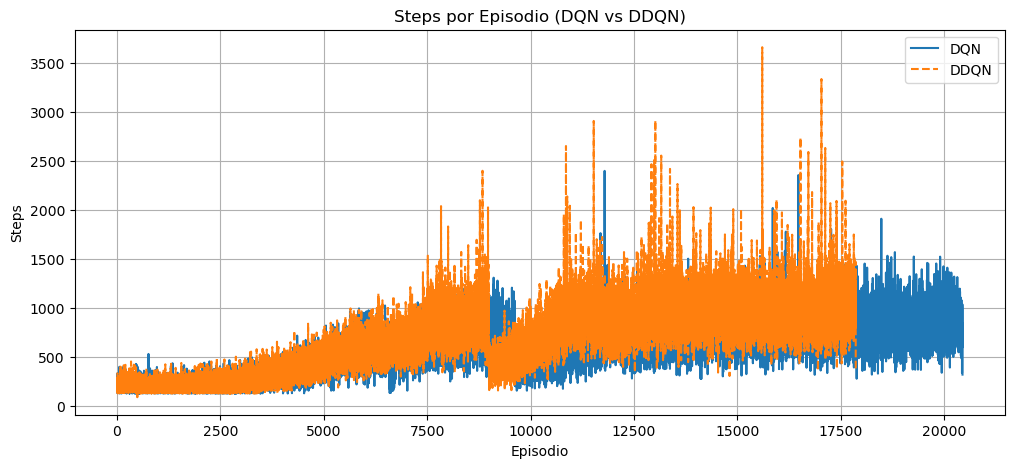

In [39]:
graph_metrics_comparison(dqn_metrics_path, ddqn_metrics_path)

A lo largo de este obligatorio se implementaron, entrenaron y analizaron dos de los algoritmos más relevantes del Aprendizaje por Refuerzo Profundo para entornos con estados complejos y espacios de acción discretos: **Deep Q-Learning (DQN)** y **Double Deep Q-Learning (DDQN)**, aplicados al juego **Breakout** como entorno de prueba.

Este trabajo permitió aplicar de forma práctica conceptos fundamentales del marco teórico del Aprendizaje por Refuerzo. Por un lado, se evidenció de forma clara el **sesgo de maximización** que caracteriza a Q-Learning: al seleccionar acciones mediante la operación *max*, las estimaciones de los valores Q tienden a sobrevalorarse debido al ruido inherente en la aproximación con redes neuronales. Esto se tradujo en políticas que, aunque efectivas para superar un umbral mínimo de rendimiento, mostraron signos de estancamiento y estabilización prematura en recompensas promedio moderadas (alrededor de **20–25 bloques**), sin alcanzar los máximos potenciales del entorno. Considerando lo anterior, se introdujo una experimentación con Epsilon Adaptativo, el cual dió excelentes resultados en relación a minimizar el estancamiento en políticas sub-óptimas, al igual que potenciar las mismas, llegando incluso a igualar resultados obtenidos en DDQN para la misma fase.

Como se plantea en el teórico, una solución directa para el sesgo de maximización resultante en DQN, es la implementación de **Double Q-Learning**, el cuál demostró ser una mejora directa y coherente frente a esta limitación, ya que desacopla la selección de la acción de su evaluación mediante el uso de dos redes (*online* y *target*). Esta idea, que coincide con lo planteado por **Sutton y Barto**, permitió mitigar la sobreestimación de valores y obtener trayectorias más estables, con menor varianza y mejor rendimiento promedio, reforzando la relevancia de abordar cuidadosamente los sesgos de estimación cuando se emplean métodos basados en Diferencia Temporal (**TD**).

Esto se refleja claramente en las **gráficas comparativas DQN vs DDQN**. La evolución de la **recompensa por episodio** muestra que DDQN logra superar de forma consistente el rendimiento de DQN, alcanzando medias de recompensa más altas y estables, sin caídas abruptas ni estancamientos prolongados. Al observar la **pérdida por episodio**, se confirma que DDQN mantiene valores de *loss* generalmente más bajos y con menos picos extremos que DQN, lo que evidencia una convergencia más suave y un menor sesgo de sobreestimación. Por último, los **pasos por episodio** alcanzados por DDQN son, en promedio, mayores que los de DQN,lo que se puede visualizar fácilmente en la gráfica al ejecutarse exactamente la misma cantidad de pasos pero DDQN ejecutando menos episodios, lo que indica que la política aprendida es capaz de sostener la partida durante más tiempo, maximizando la recompensa acumulada y demostrando mayor robustez.

En línea con la perspectiva de aprendizaje y planificación, se empleó una **Replay Buffer**, que posibilitó la reutilización de transiciones pasadas y la generación de actualizaciones adicionales a partir de datos previamente almacenados. Esta estrategia se asemeja a la planificación indirecta, ya que el agente “revive” experiencias previas como si generara pasos simulados, reforzando la consolidación de políticas aprendidas. Asimismo, se experimentó con una versión de **memoria priorizada**, inspirada en el barrido priorizado de la Programación Dinámica, para concentrar el aprendizaje en transiciones con mayor error TD. Si bien su aplicación no garantizó mejoras sustanciales en este caso, puso de manifiesto que la efectividad de estas técnicas depende en gran medida de la calidad de la exploración.

Este trabajo deja sentadas bases sólidas para continuar investigando variantes más avanzadas, como **replay prioritizado robusto**, ajustes adaptativos de hiperparámetros y, en especial, la exploración de **métodos basados en gradiente de política**, que permitirán abordar problemas más complejos y entornos con espacios de acción continuos de forma más eficiente y generalizable.

